In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
import seaborn as sns
import impyute as impy

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [348]:
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [349]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [350]:
cleaned_dataset = pd.read_csv('cleaned_dataset.csv')

In [351]:
# drop cloumn Unnamed: 0

# Fixing date column datatype
cleaned_dataset['date'] = pd.to_datetime(cleaned_dataset['date']);
# all_countries_dataset['location'] = all_countries_dataset['location'].astype('category');
# all_countries_dataset['continent'] = all_countries_dataset['continent'].astype('category');

# all_countries_dataset.set_index('date', inplace=True)

In [352]:
# take only numerical variables
numerical_variables = [
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index'
]

# take non-numerical variables
non_numerical_variables = [
    'continent',
    'location',
    'date'
]

svr_dataset = cleaned_dataset.copy()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

obj_dataset = svr_dataset[non_numerical_variables].copy()
num_dataset = svr_dataset[numerical_variables].copy()
# num_dataset = sc.fit_transform(num_dataset)

num_dataset = pd.DataFrame(num_dataset, columns=numerical_variables)


num_dataset = np.log(num_dataset)

# Take First Difference to Remove Trend
num_dataset = num_dataset.diff()

num_dataset = num_dataset.diff()

# Remove Increasing Volatility
# num_dataset = num_dataset.groupby(num_dataset.index.year).std()

svr_dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset, columns=numerical_variables)], axis=1)

svr_dataset.dtypes

continent                    object
location                     object
date                 datetime64[ns]
new_cases                   float64
new_deaths                  float64
icu_patients                float64
new_tests                   float64
positive_rate               float64
people_vaccinated           float64
new_vaccinations            float64
total_boosters              float64
stringency_index            float64
dtype: object

In [353]:
svr_dataset.index = pd.to_datetime(svr_dataset.date)
svr_dataset.index.freq = svr_dataset.index.inferred_freq

In [354]:
def replace_nans(dataset):
    # for each country
    new_dataset = pd.DataFrame()

    for country in dataset['location'].unique():
        country_dataset = dataset[dataset['location'] == country]

        for variable in numerical_variables:
            for index, row in country_dataset.iterrows():
                if pd.isna(row[variable]) or row[variable] == float('inf') or row[variable] == float('-inf'):
                    previous_timestamp = index - pd.Timedelta(days=1)
                    if previous_timestamp in country_dataset.index and pd.isna(country_dataset.loc[previous_timestamp, variable]) == False:
                        country_dataset.at[index, variable] = country_dataset.at[previous_timestamp, variable]
                    else:
                        country_dataset.at[index, variable] = 0
    
        new_dataset = pd.concat([new_dataset, country_dataset], axis=0)

    return new_dataset

In [355]:
svr_dataset = replace_nans(svr_dataset)

### Add lags

In [356]:
nb_lags_dependent = 2 # calculated with AutoARIMA
nb_lags_independent = 1 # calculated with AutoARIMA

# for each variable
for variable in numerical_variables:
    if variable == 'new_deaths':
        continue
    for nb_lag in range(0, nb_lags_independent):
        svr_dataset[variable + '_' + str(nb_lag)] = svr_dataset[variable].shift(nb_lag)

for nb_lag in range(nb_lags_dependent):
    svr_dataset['new_deaths_' + str(nb_lag)] = svr_dataset['new_deaths'].shift(nb_lag)

In [357]:
# remove nan values created by shift()
svr_dataset = svr_dataset.dropna()

In [358]:
print(svr_dataset.columns.tolist())
numerical_variables_with_lags = svr_dataset.columns.tolist()
# exclude non_numerical_variables from numerical_variables_with_lags
numerical_variables_with_lags = [x for x in numerical_variables_with_lags if x not in non_numerical_variables]

['continent', 'location', 'date', 'new_cases', 'new_deaths', 'icu_patients', 'new_tests', 'positive_rate', 'people_vaccinated', 'new_vaccinations', 'total_boosters', 'stringency_index', 'new_cases_0', 'icu_patients_0', 'new_tests_0', 'positive_rate_0', 'people_vaccinated_0', 'new_vaccinations_0', 'total_boosters_0', 'stringency_index_0', 'new_deaths_0', 'new_deaths_1']


### Add dummy variables

In [359]:
countries = svr_dataset['location'].unique()

In [360]:
# for each country
for country in svr_dataset['location'].unique():
    # set empty column with 0 values for svr_dataset[country]
    svr_dataset[country] = 0
    svr_dataset[country].loc[svr_dataset['location'] == country] = 1

# drop location column
svr_dataset = svr_dataset.drop(columns=['location'])
# drop continent column
svr_dataset = svr_dataset.drop(columns=['continent'])

/home/ion/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [361]:
# split into train and test
training_date_limit = date(2021, 10, 15)

svr_dataset.index = pd.to_datetime(svr_dataset.date)
svr_dataset.index.freq = svr_dataset.index.inferred_freq

svr_train_dataset = svr_dataset[svr_dataset['date'].dt.date < training_date_limit]
svr_test_dataset = svr_dataset[svr_dataset['date'].dt.date >= training_date_limit]

In [362]:
# find max date
max_date = svr_dataset['date'].max()
print(max_date)

2021-11-01 00:00:00


In [363]:
# import SVR
from sklearn.svm import SVR


def svr(svr_train_dataset):
    y = svr_train_dataset['new_deaths']
    
    X = svr_train_dataset[numerical_variables_with_lags]
    
    for numercal_variable in numerical_variables:
        X = X.drop(columns=numercal_variable)

    svr_model = SVR()
    svr_model.fit(X, y)

    return svr_model

In [364]:
def svr_predict(model, country, svr_test_dataset):
    y_test = svr_test_dataset['new_deaths'].loc[svr_test_dataset[country] == 1]

    # show score
    X_test = svr_test_dataset[numerical_variables_with_lags].loc[svr_test_dataset[country] == 1]
    
    for numerical_variable in numerical_variables:
        X_test = X_test.drop(columns=numerical_variable)
    
    predictions = model.predict(X_test)

    print("C: {} - SVR Score: {}".format(model.C, model.score(X_test, y_test)))
 
    # plot predictions vs actual
    plt.figure(figsize=(50, 25))
    plt.plot(svr_test_dataset['date'].loc[svr_test_dataset[country] == 1], predictions, label='Predictions')
    plt.plot(svr_test_dataset['date'].loc[svr_test_dataset[country] == 1], y_test, label='Actual')
    plt.xlabel("Date")
    plt.ylabel("New Deaths")
    plt.legend()
    plt.show()

    return predictions

C: 1.0 - SVR Score: 0.9980164815681503


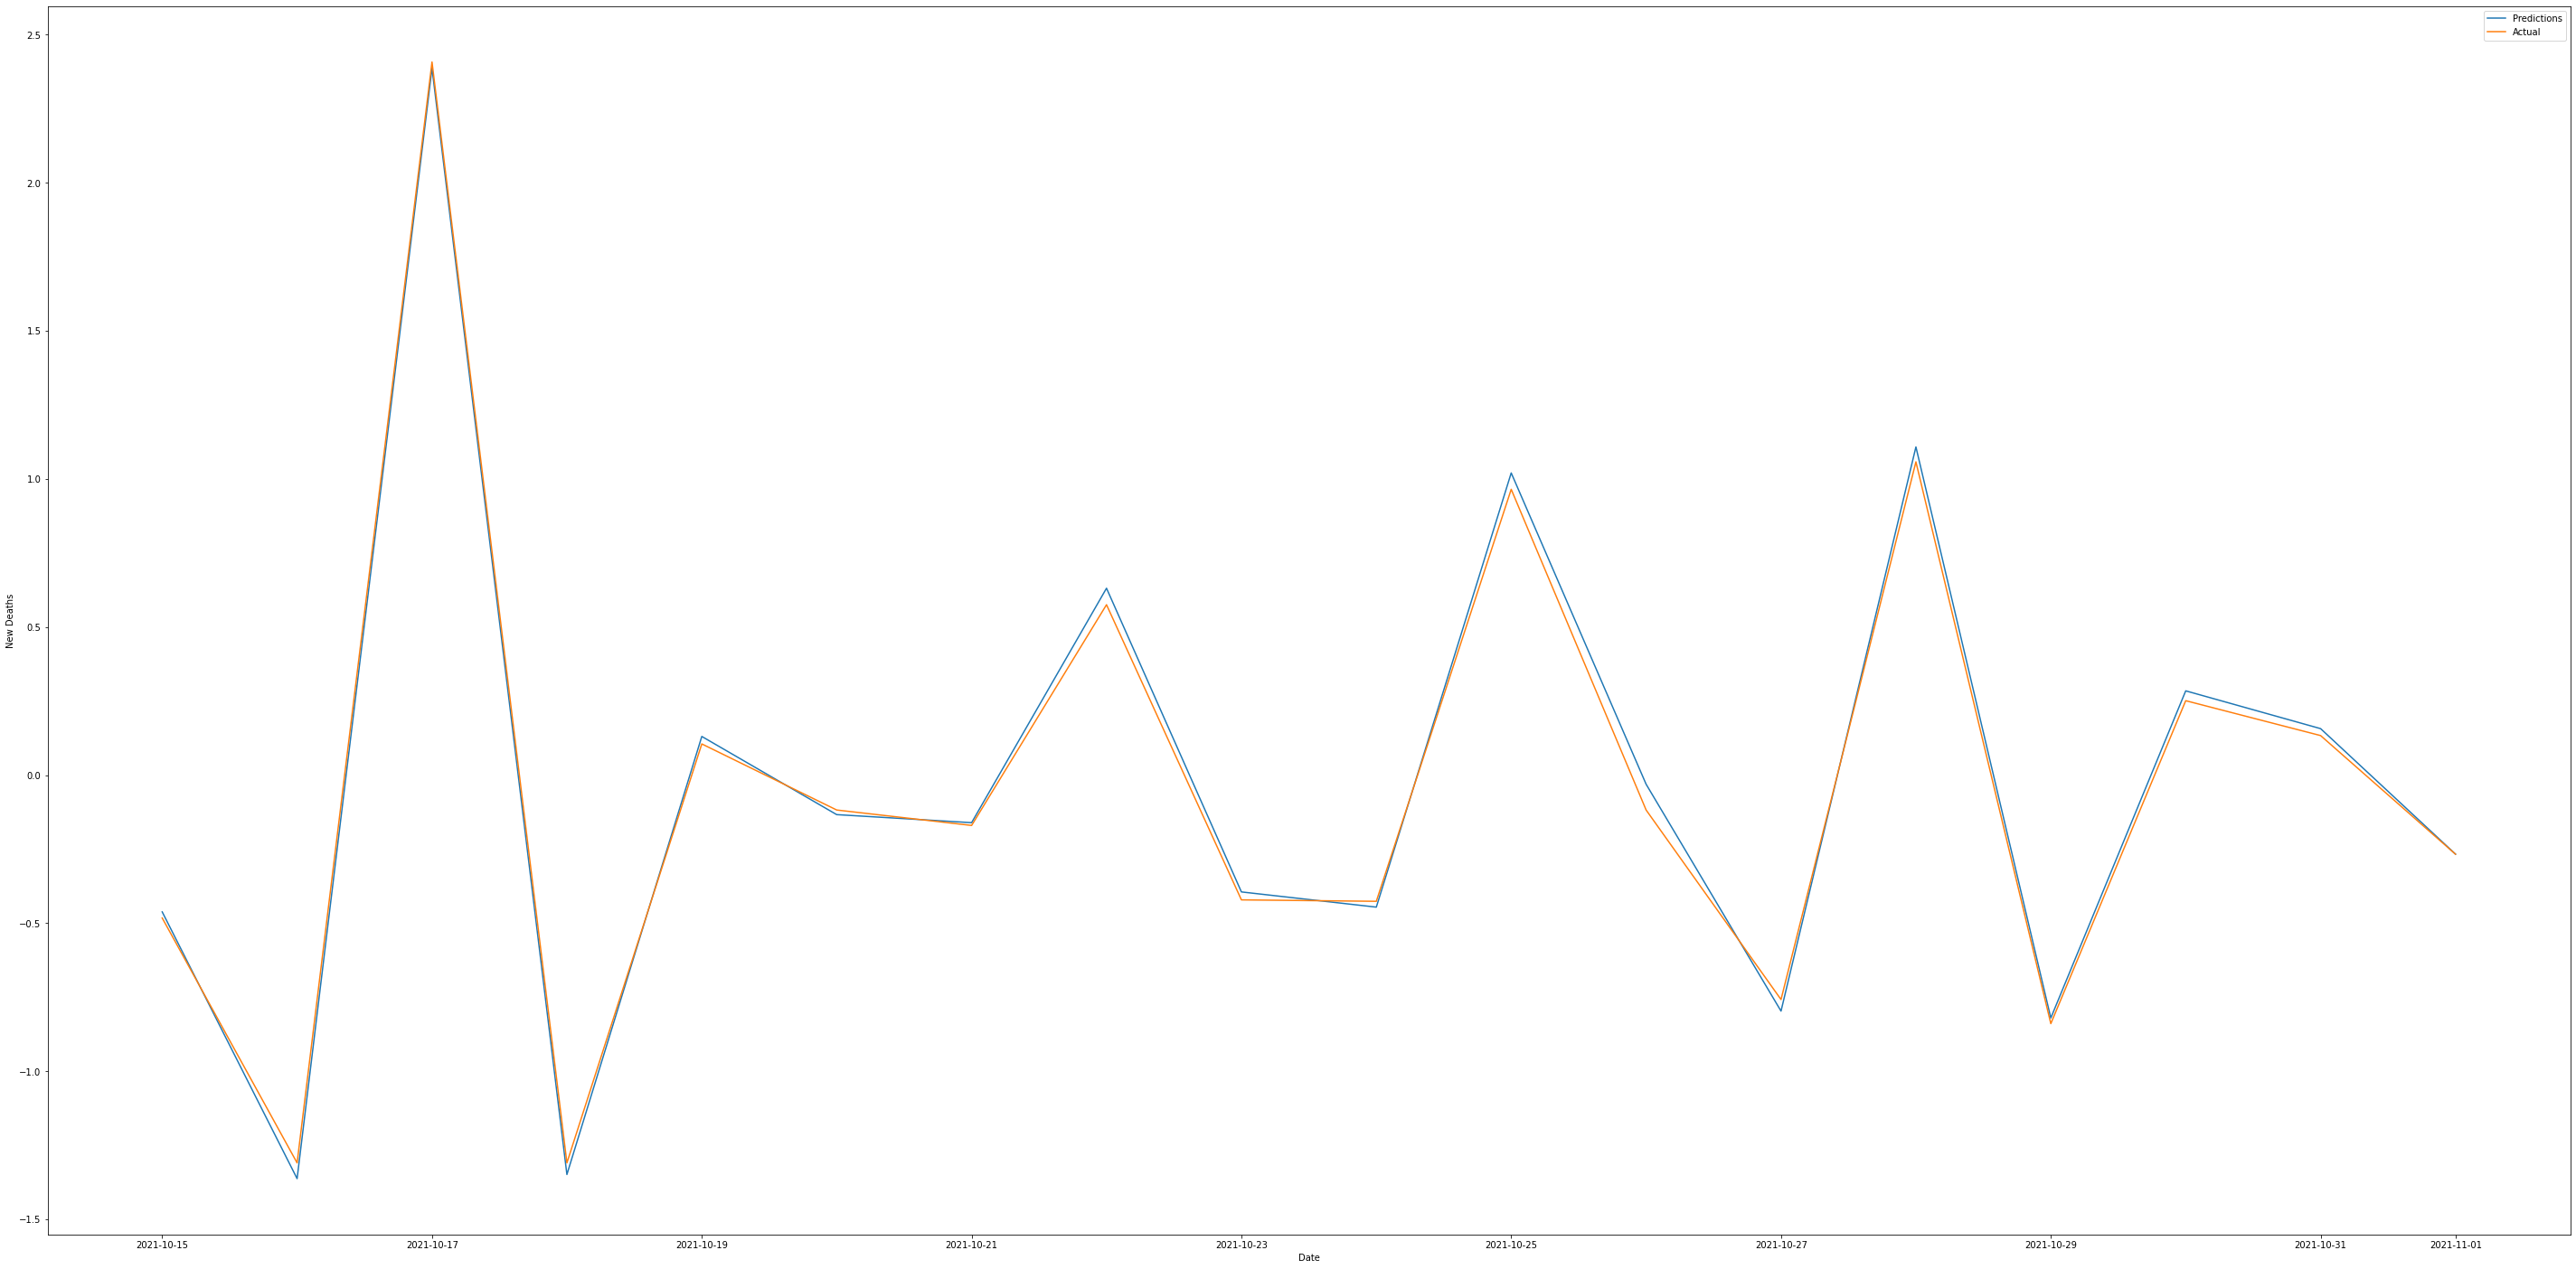

C: 1.0 - SVR Score: 0.9952513958319638


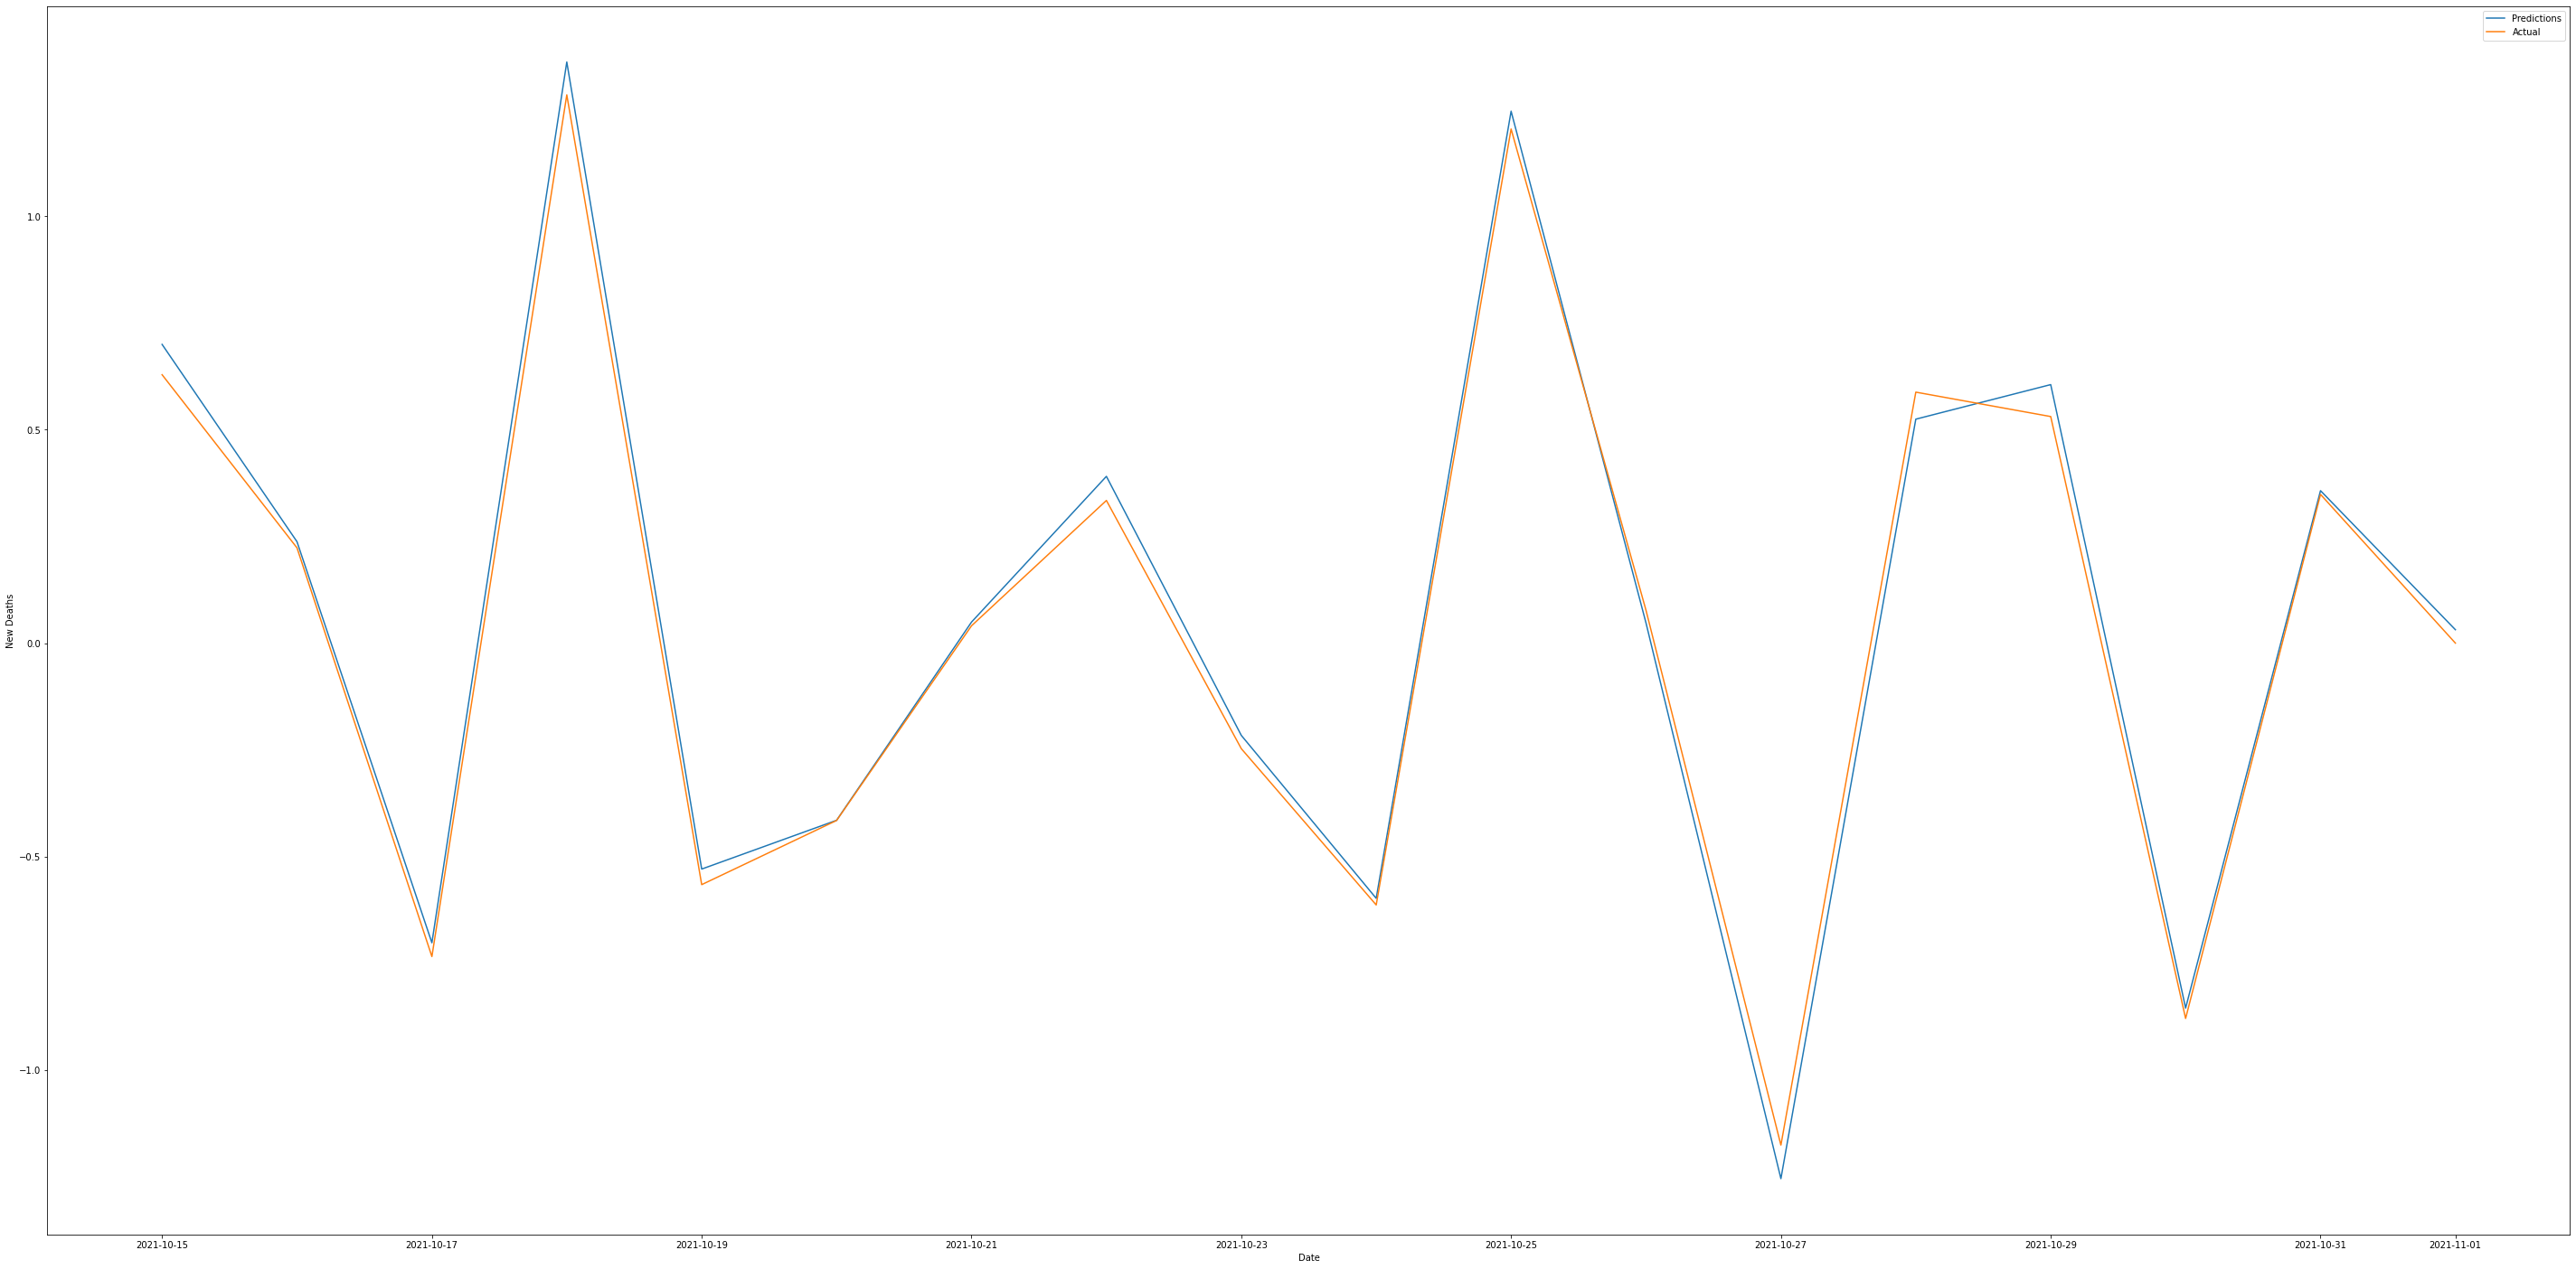

C: 1.0 - SVR Score: 0.8975400189507148


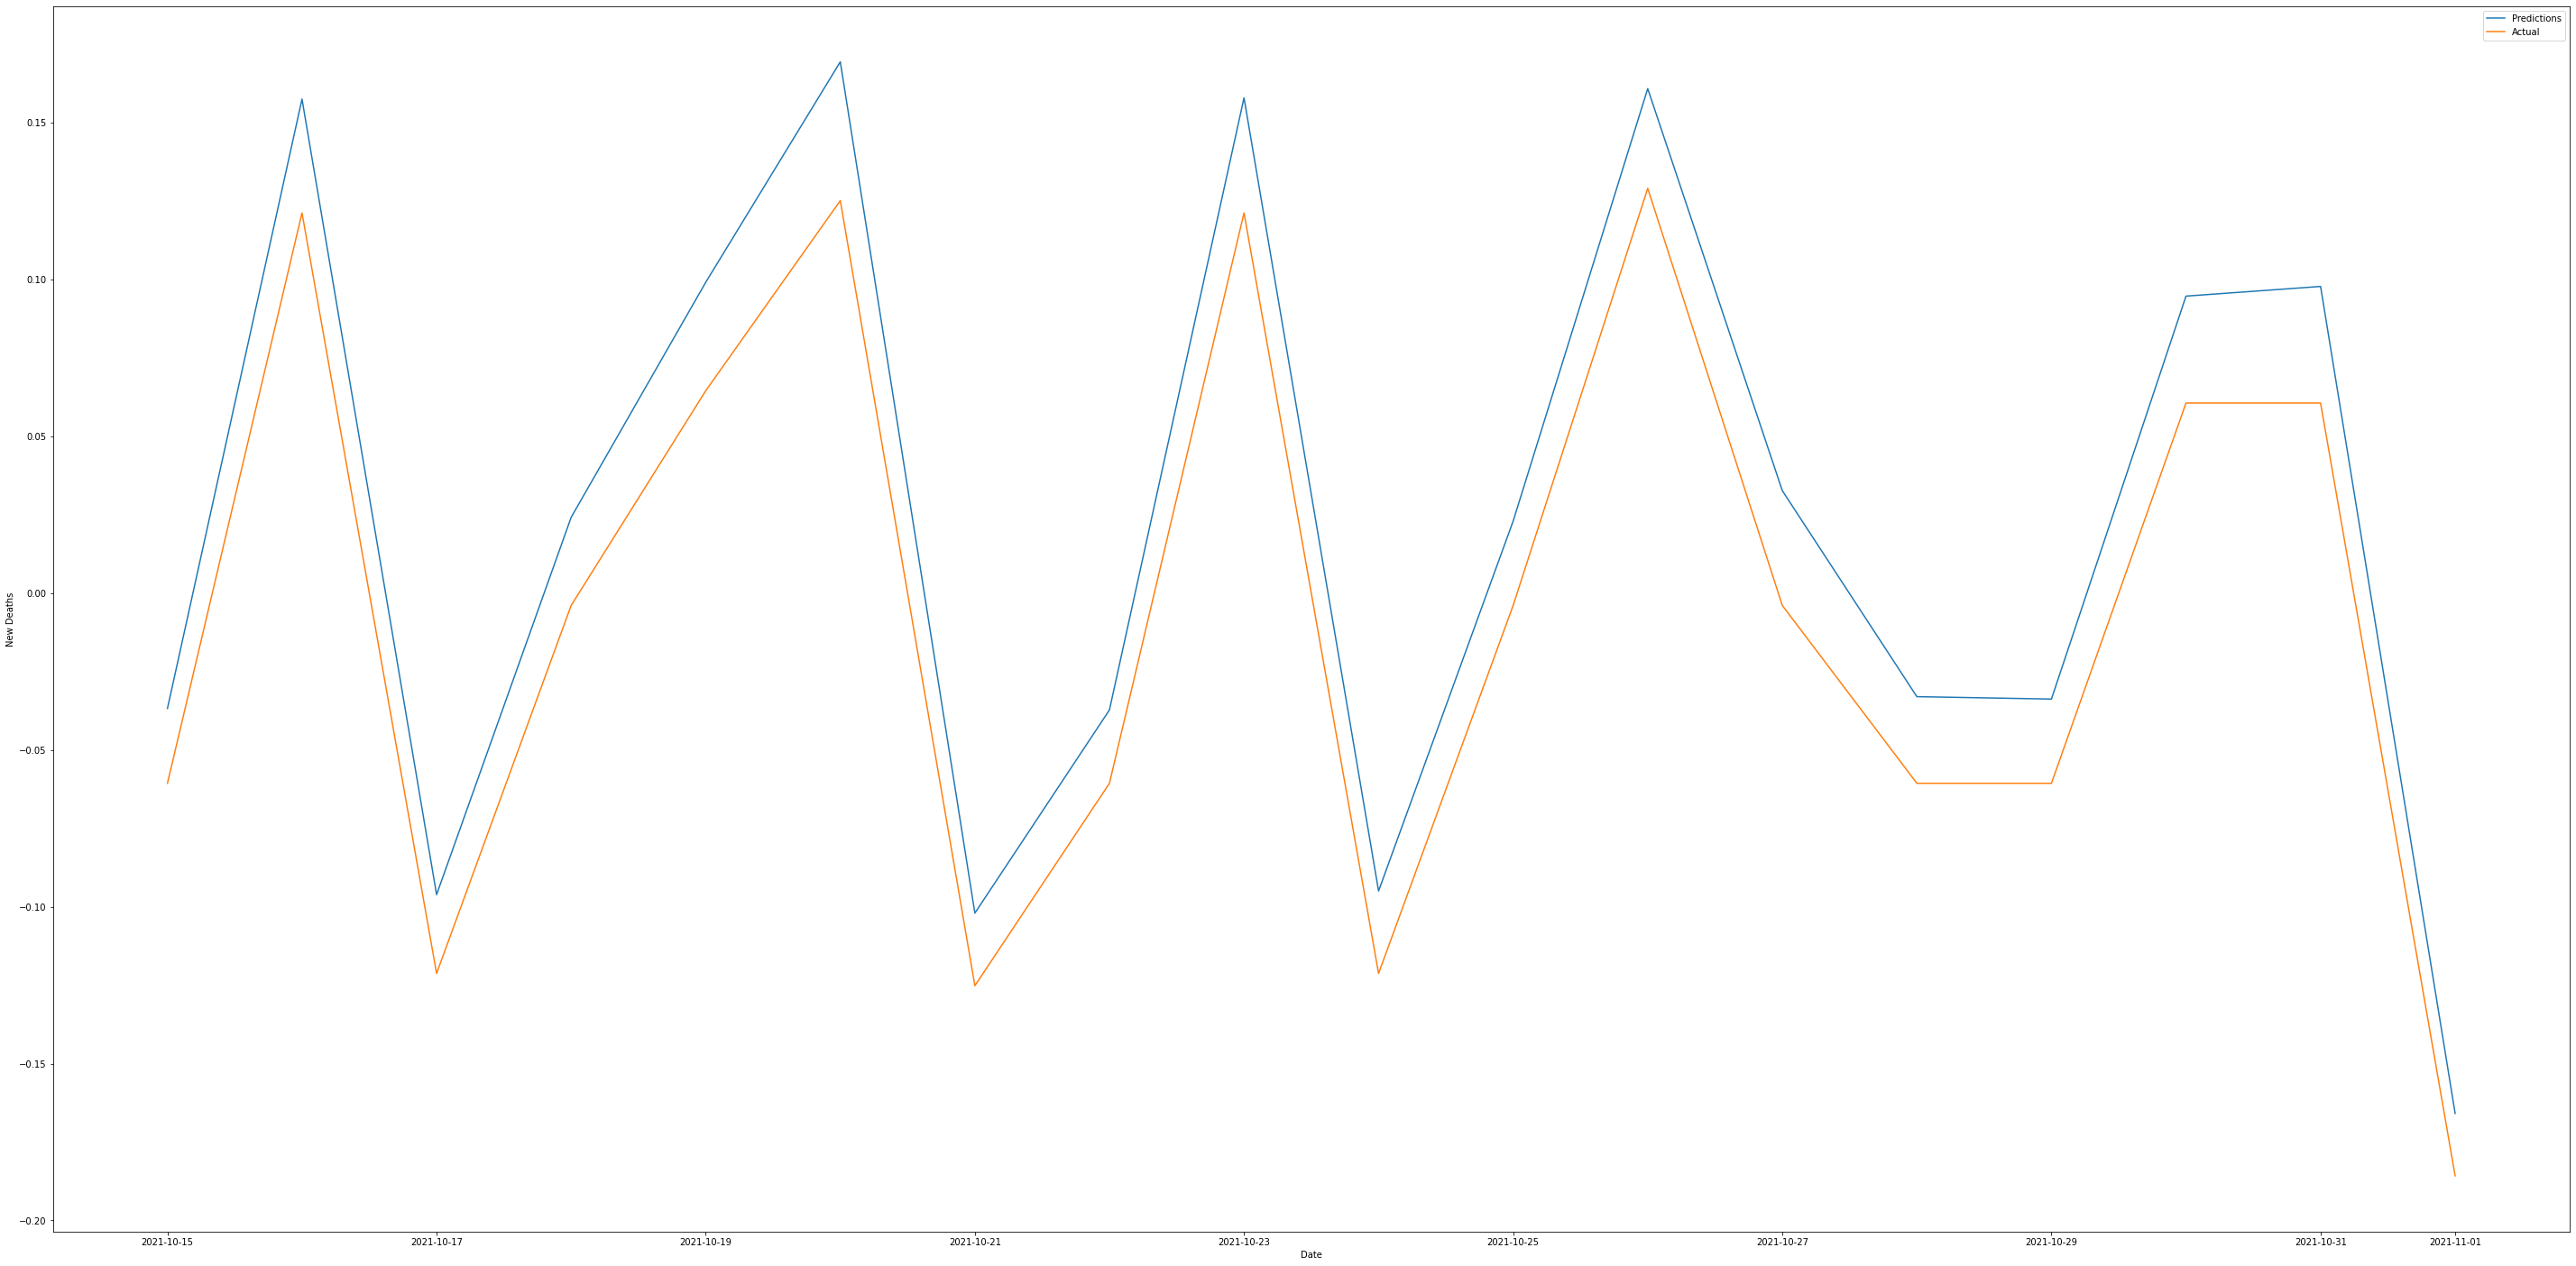

C: 1.0 - SVR Score: 0.9970101090646236


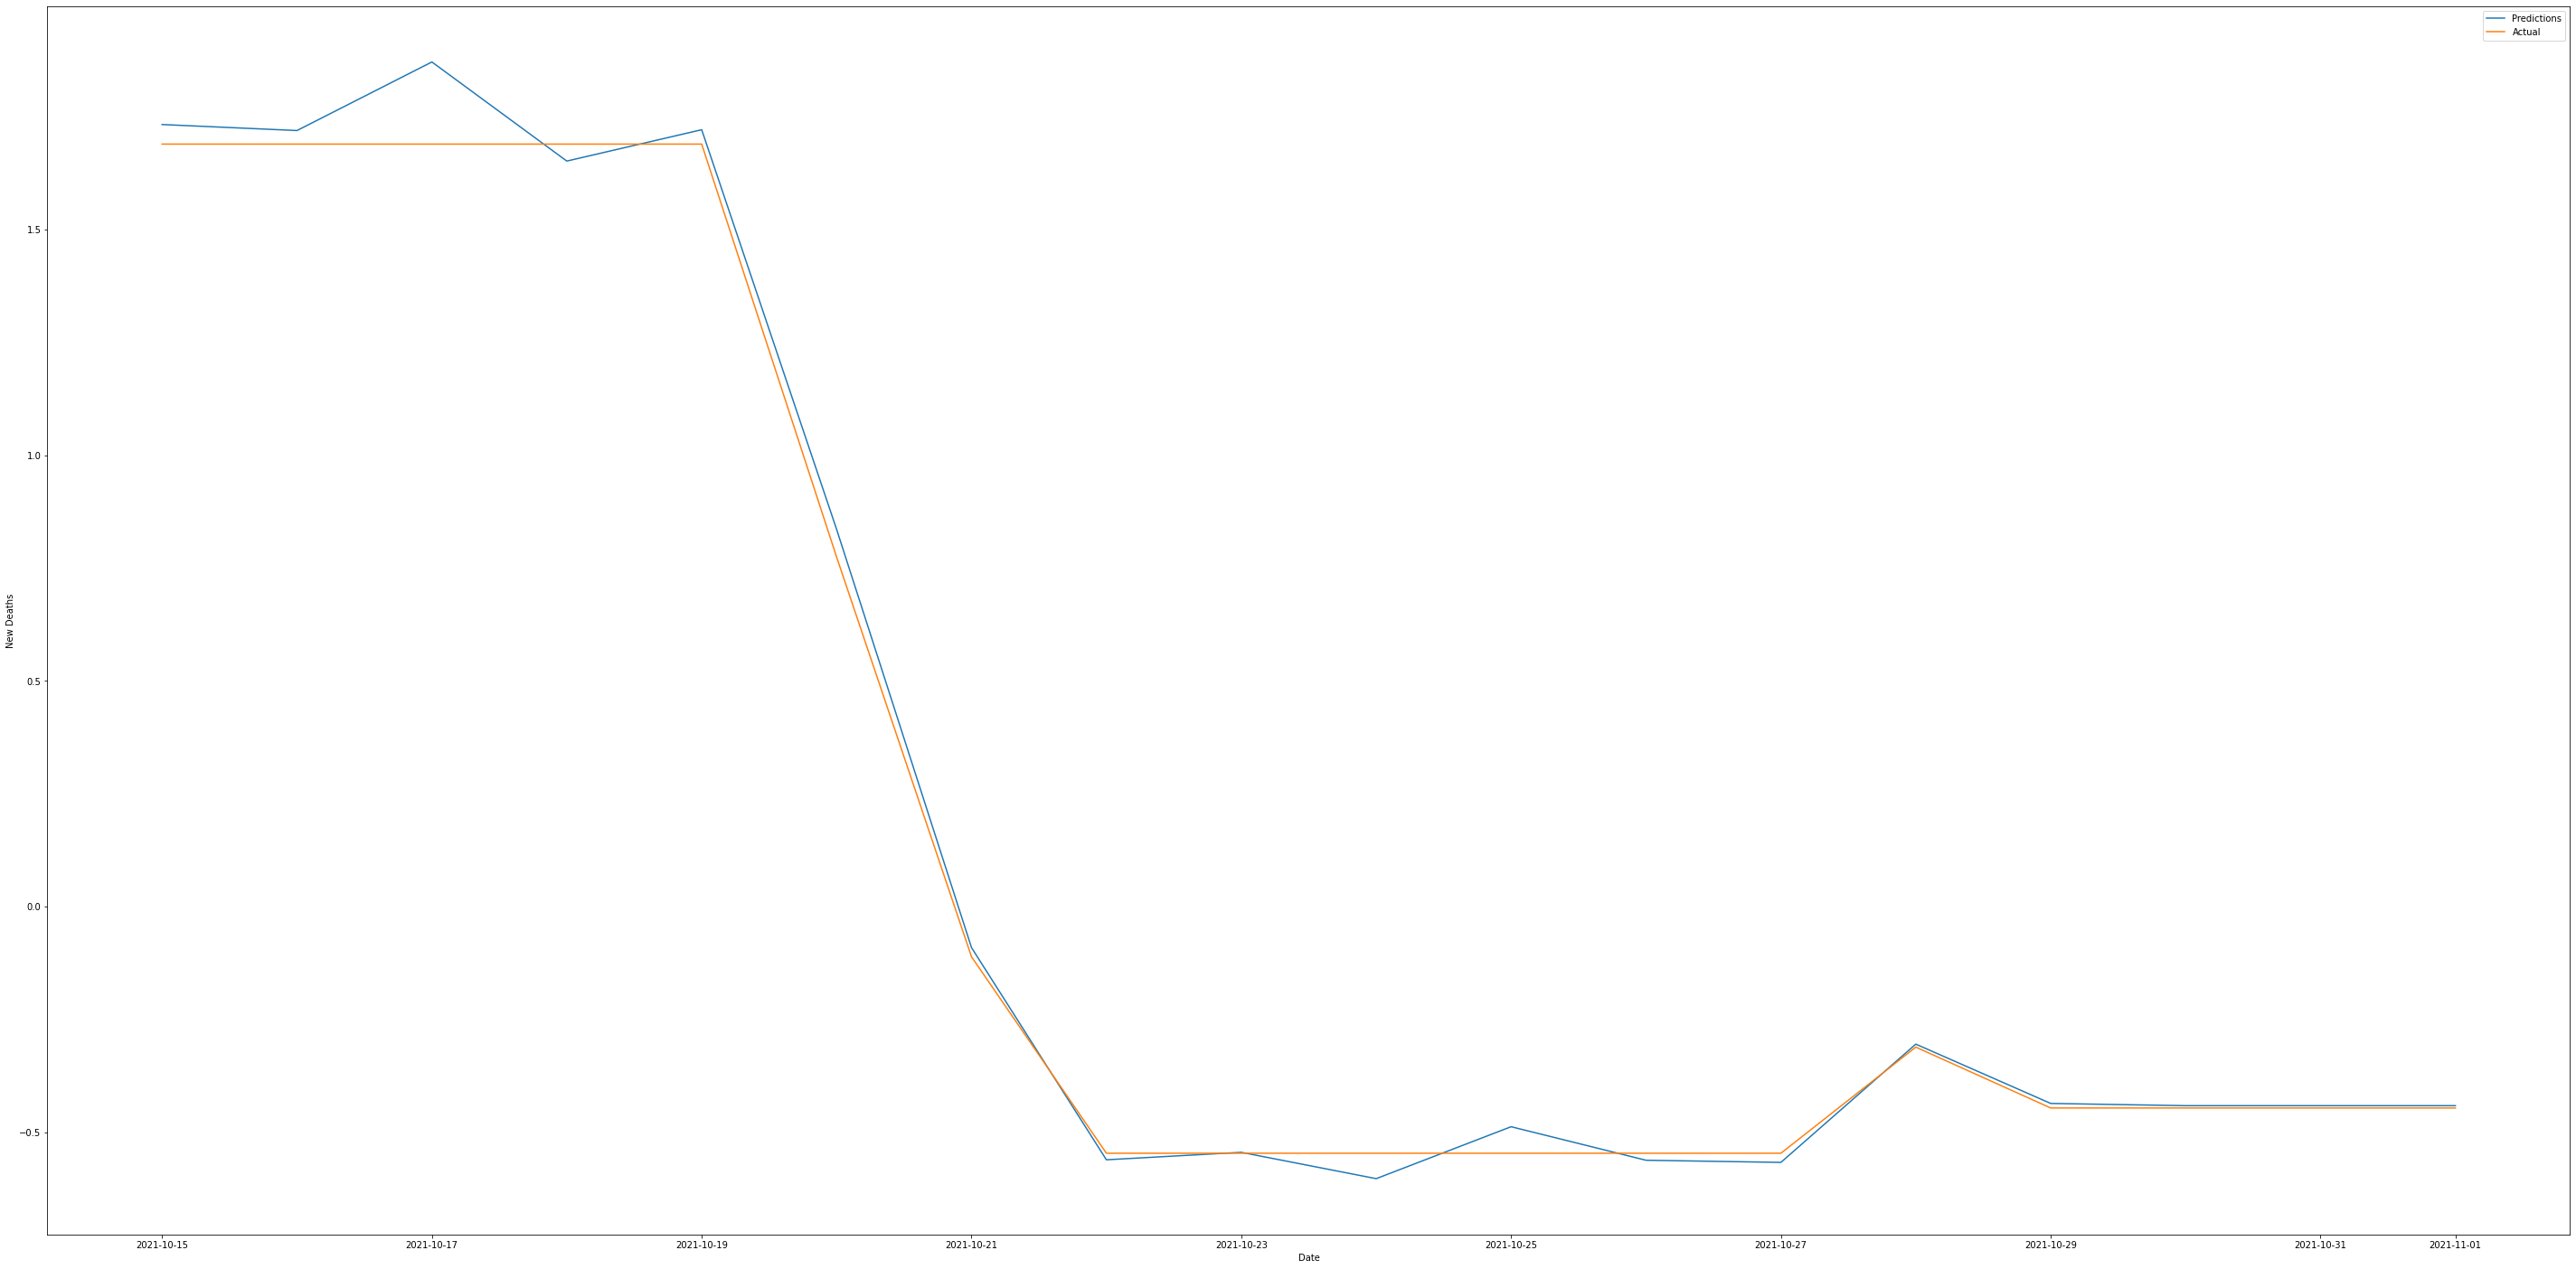

C: 1.0 - SVR Score: 0.992282079772185


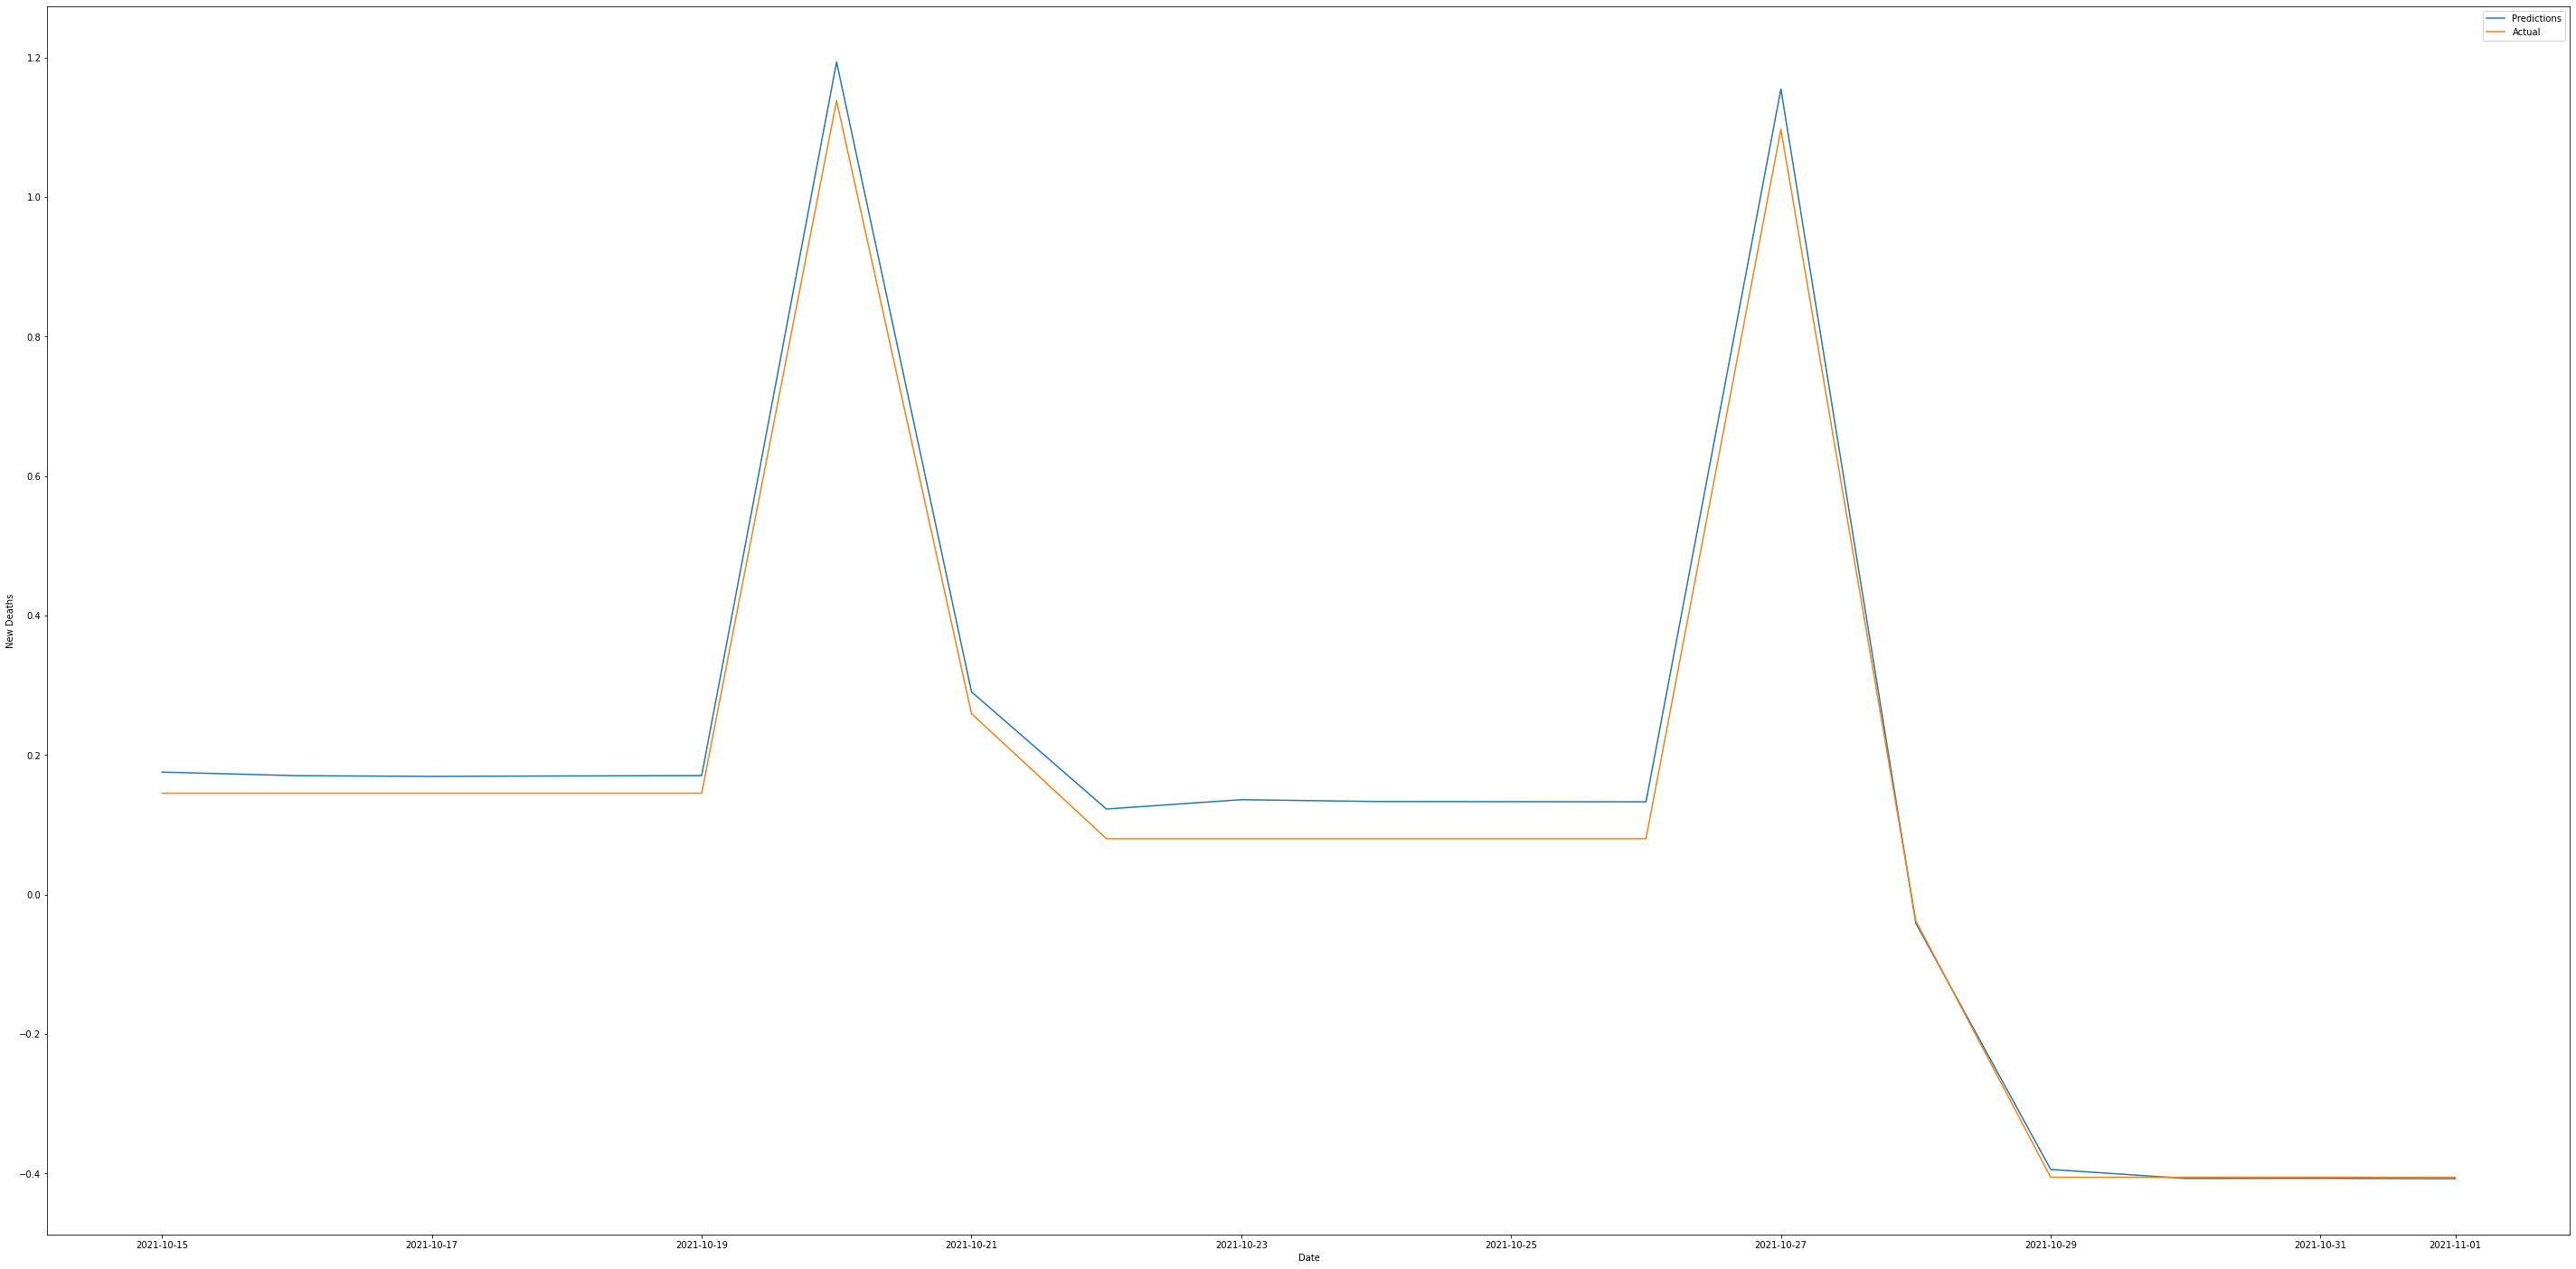

C: 1.0 - SVR Score: 0.9987484471343459


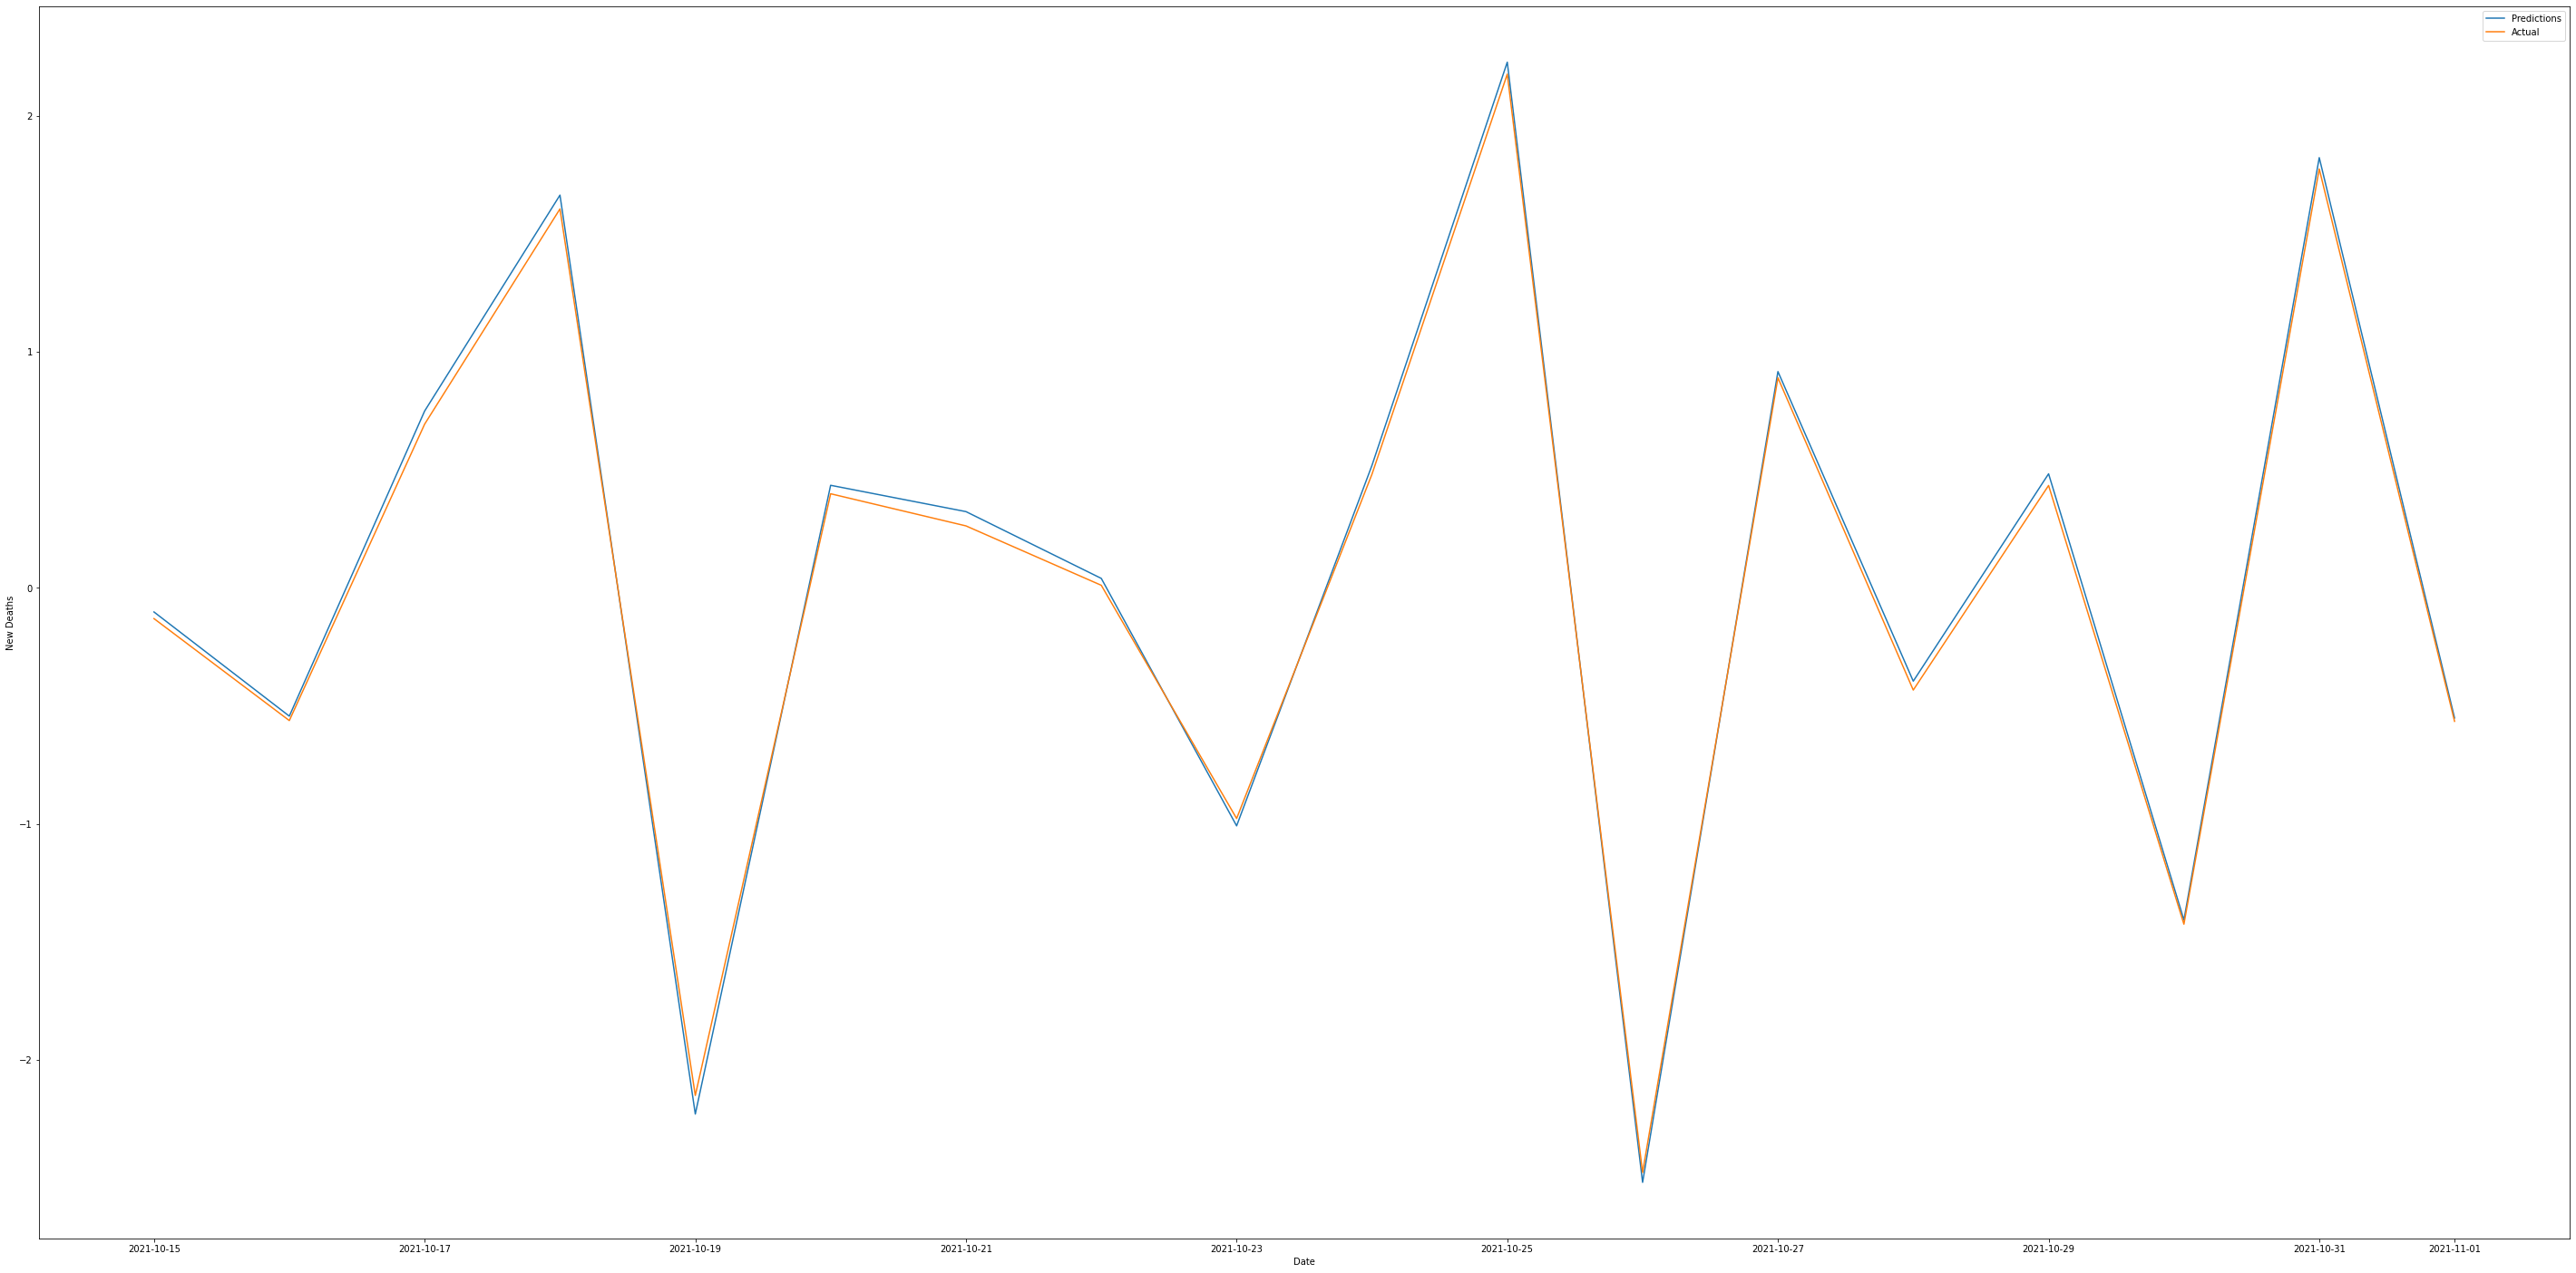

C: 1.0 - SVR Score: 0.9932614682746179


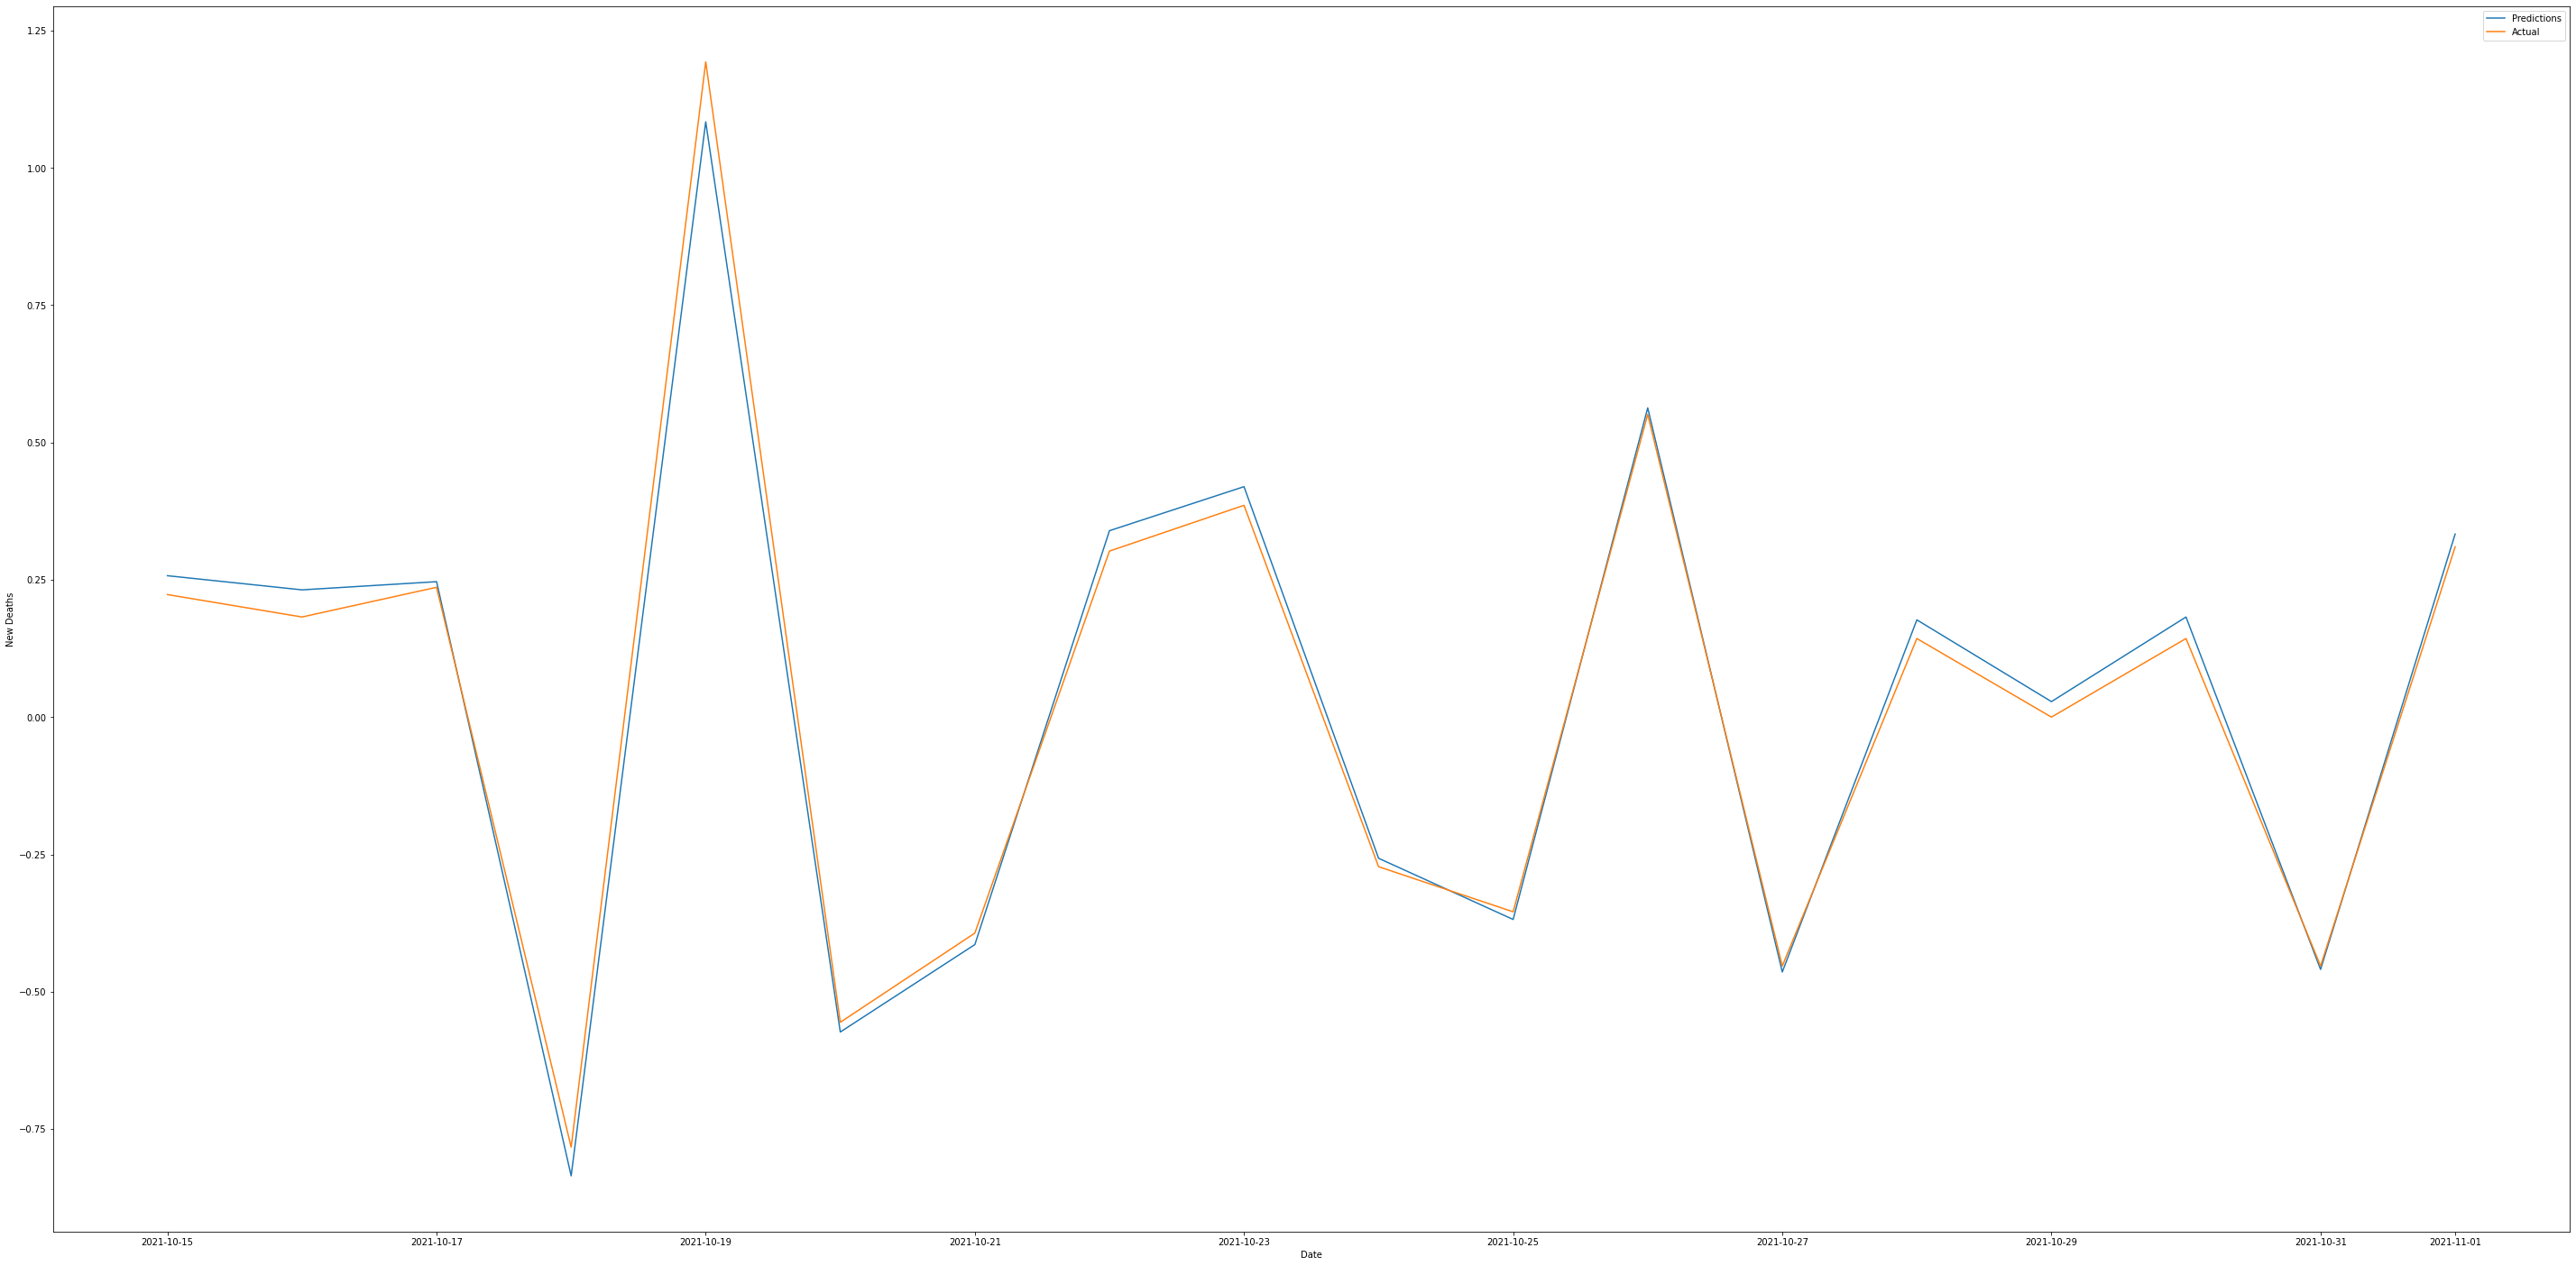

C: 1.0 - SVR Score: 0.997022179413927


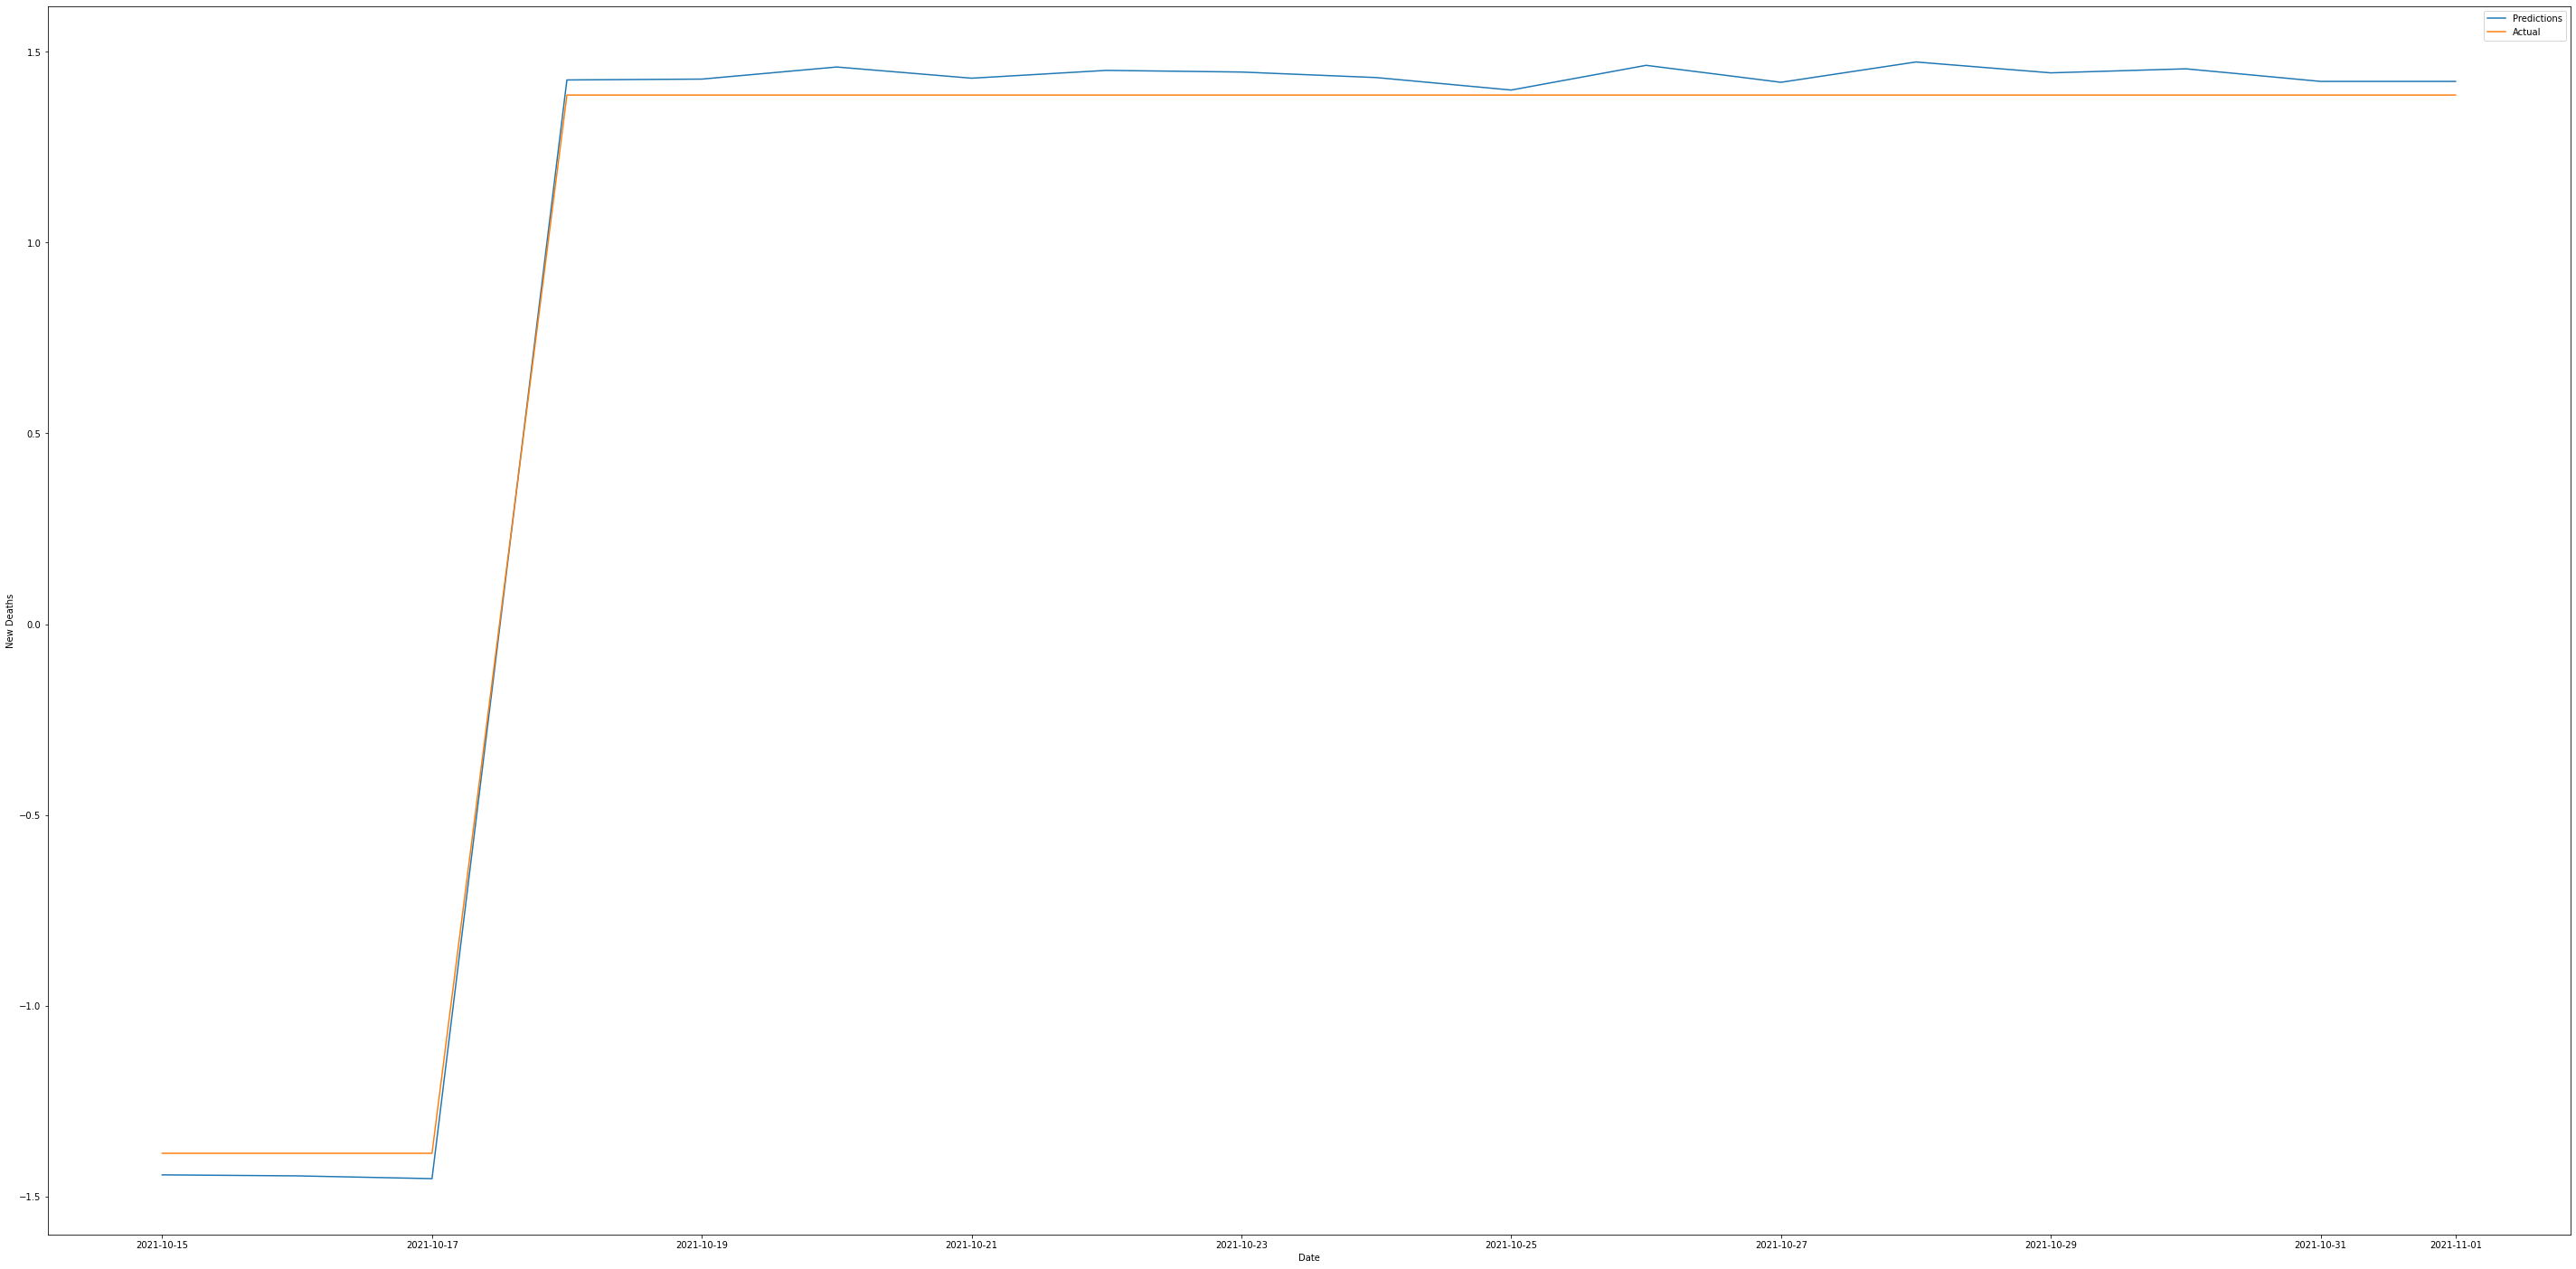

C: 1.0 - SVR Score: 0.9990353220610879


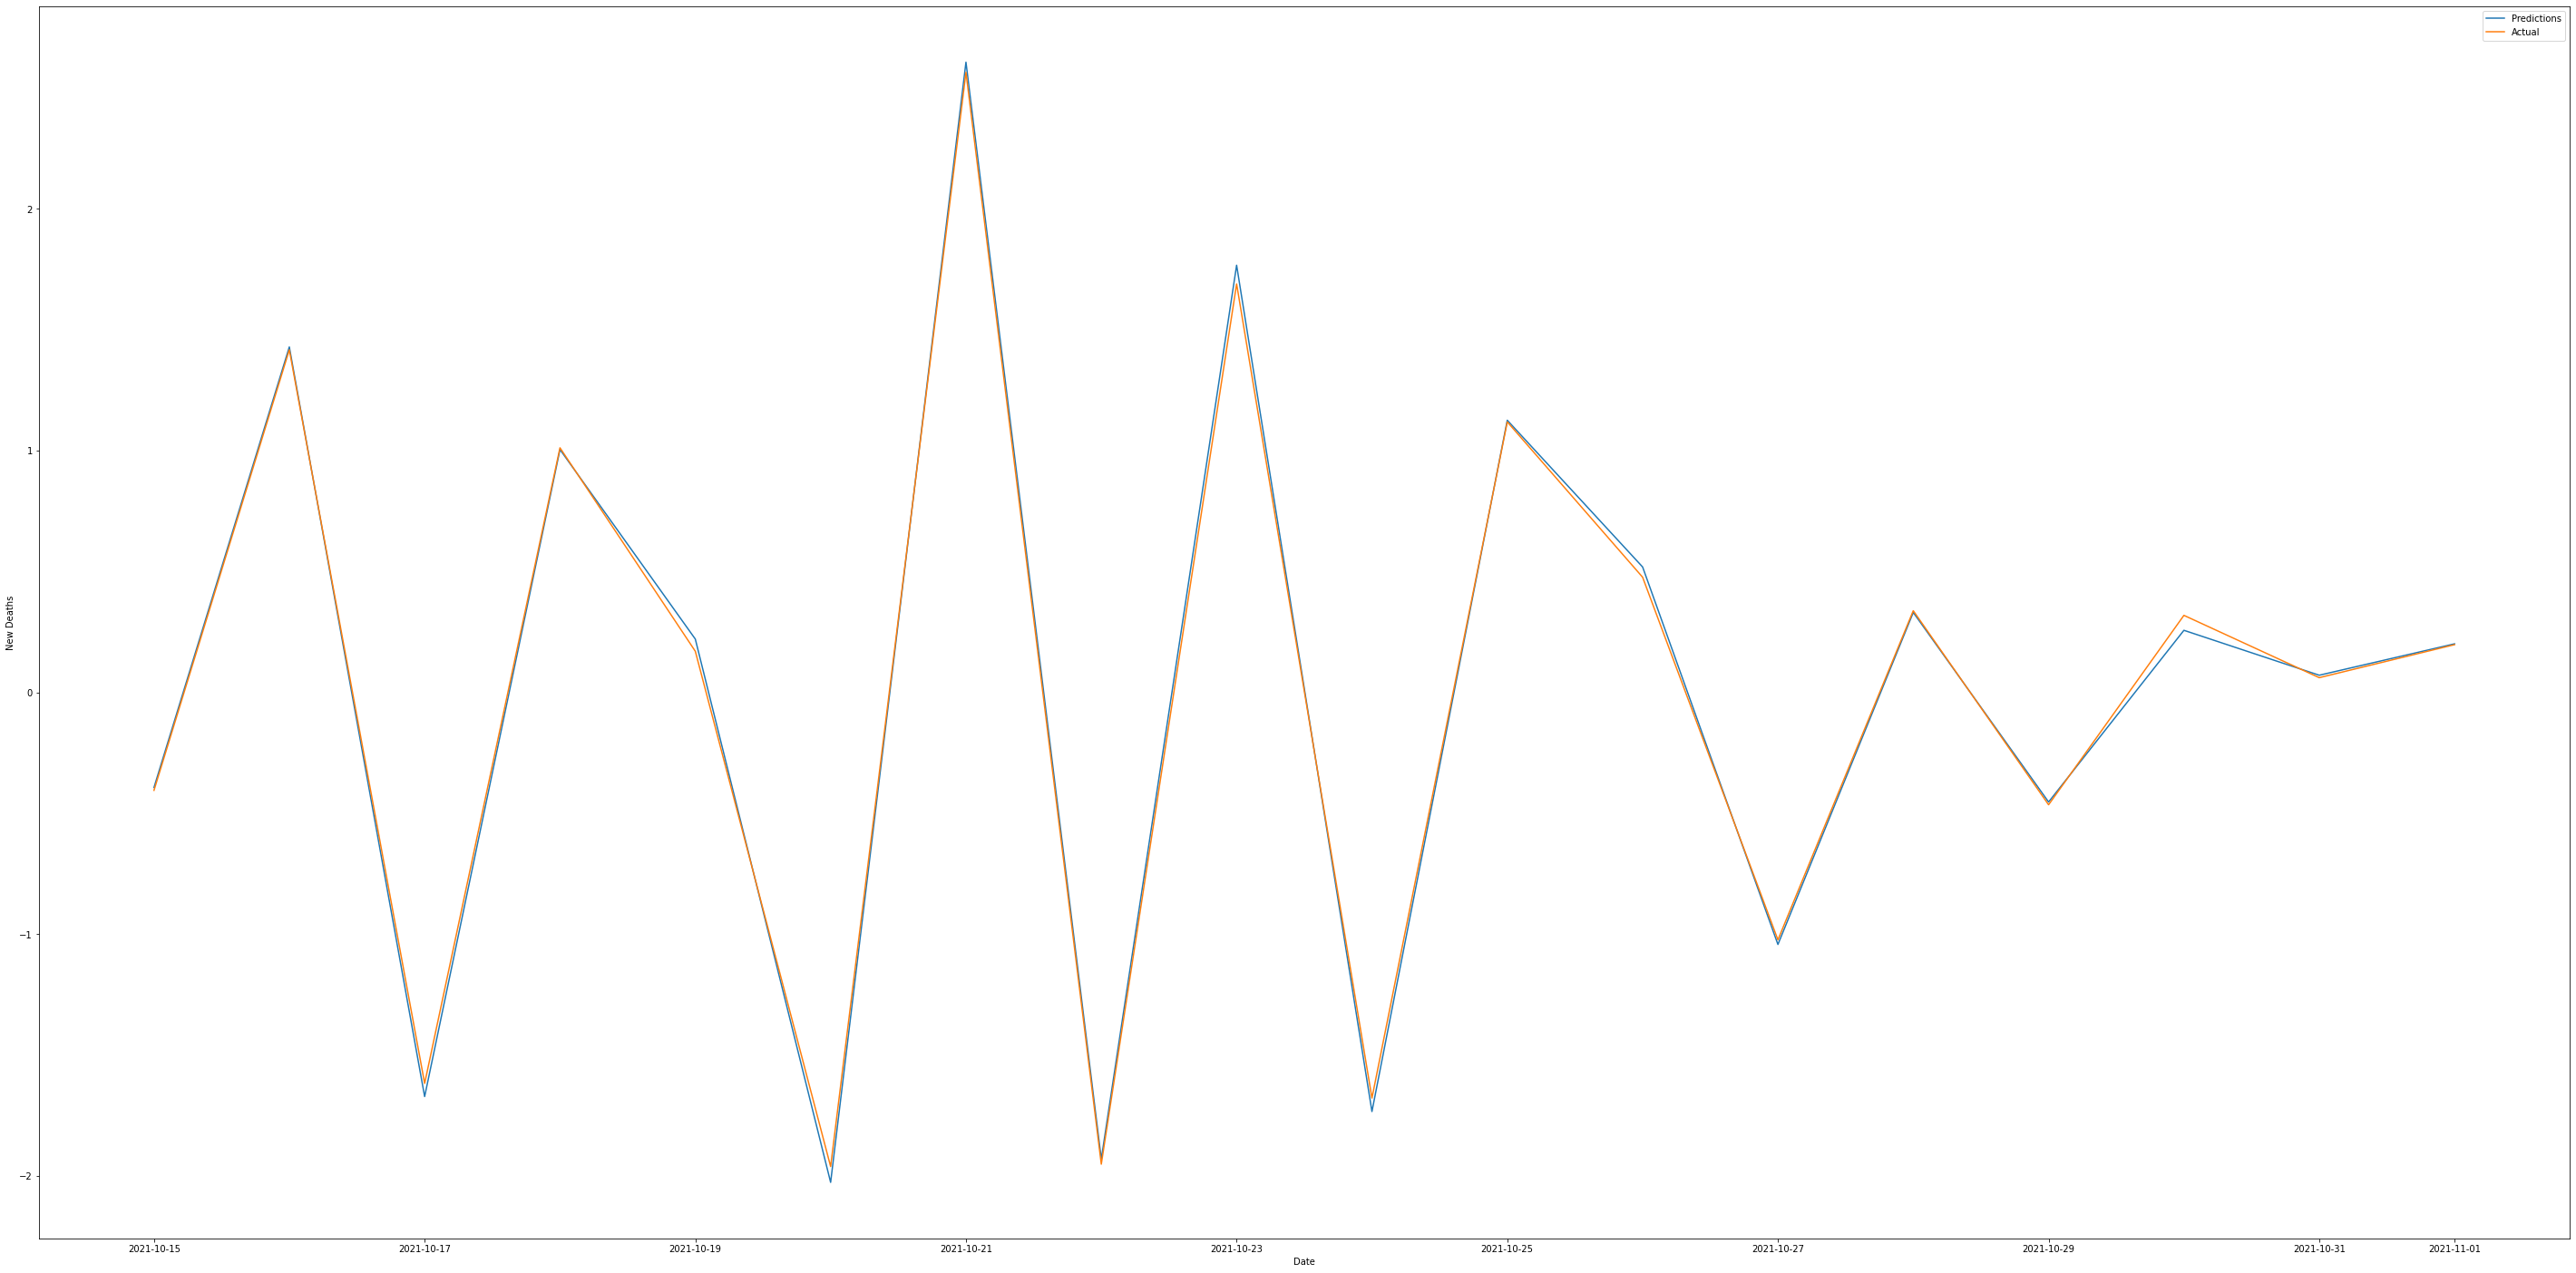

C: 1.0 - SVR Score: 0.9990141365923039


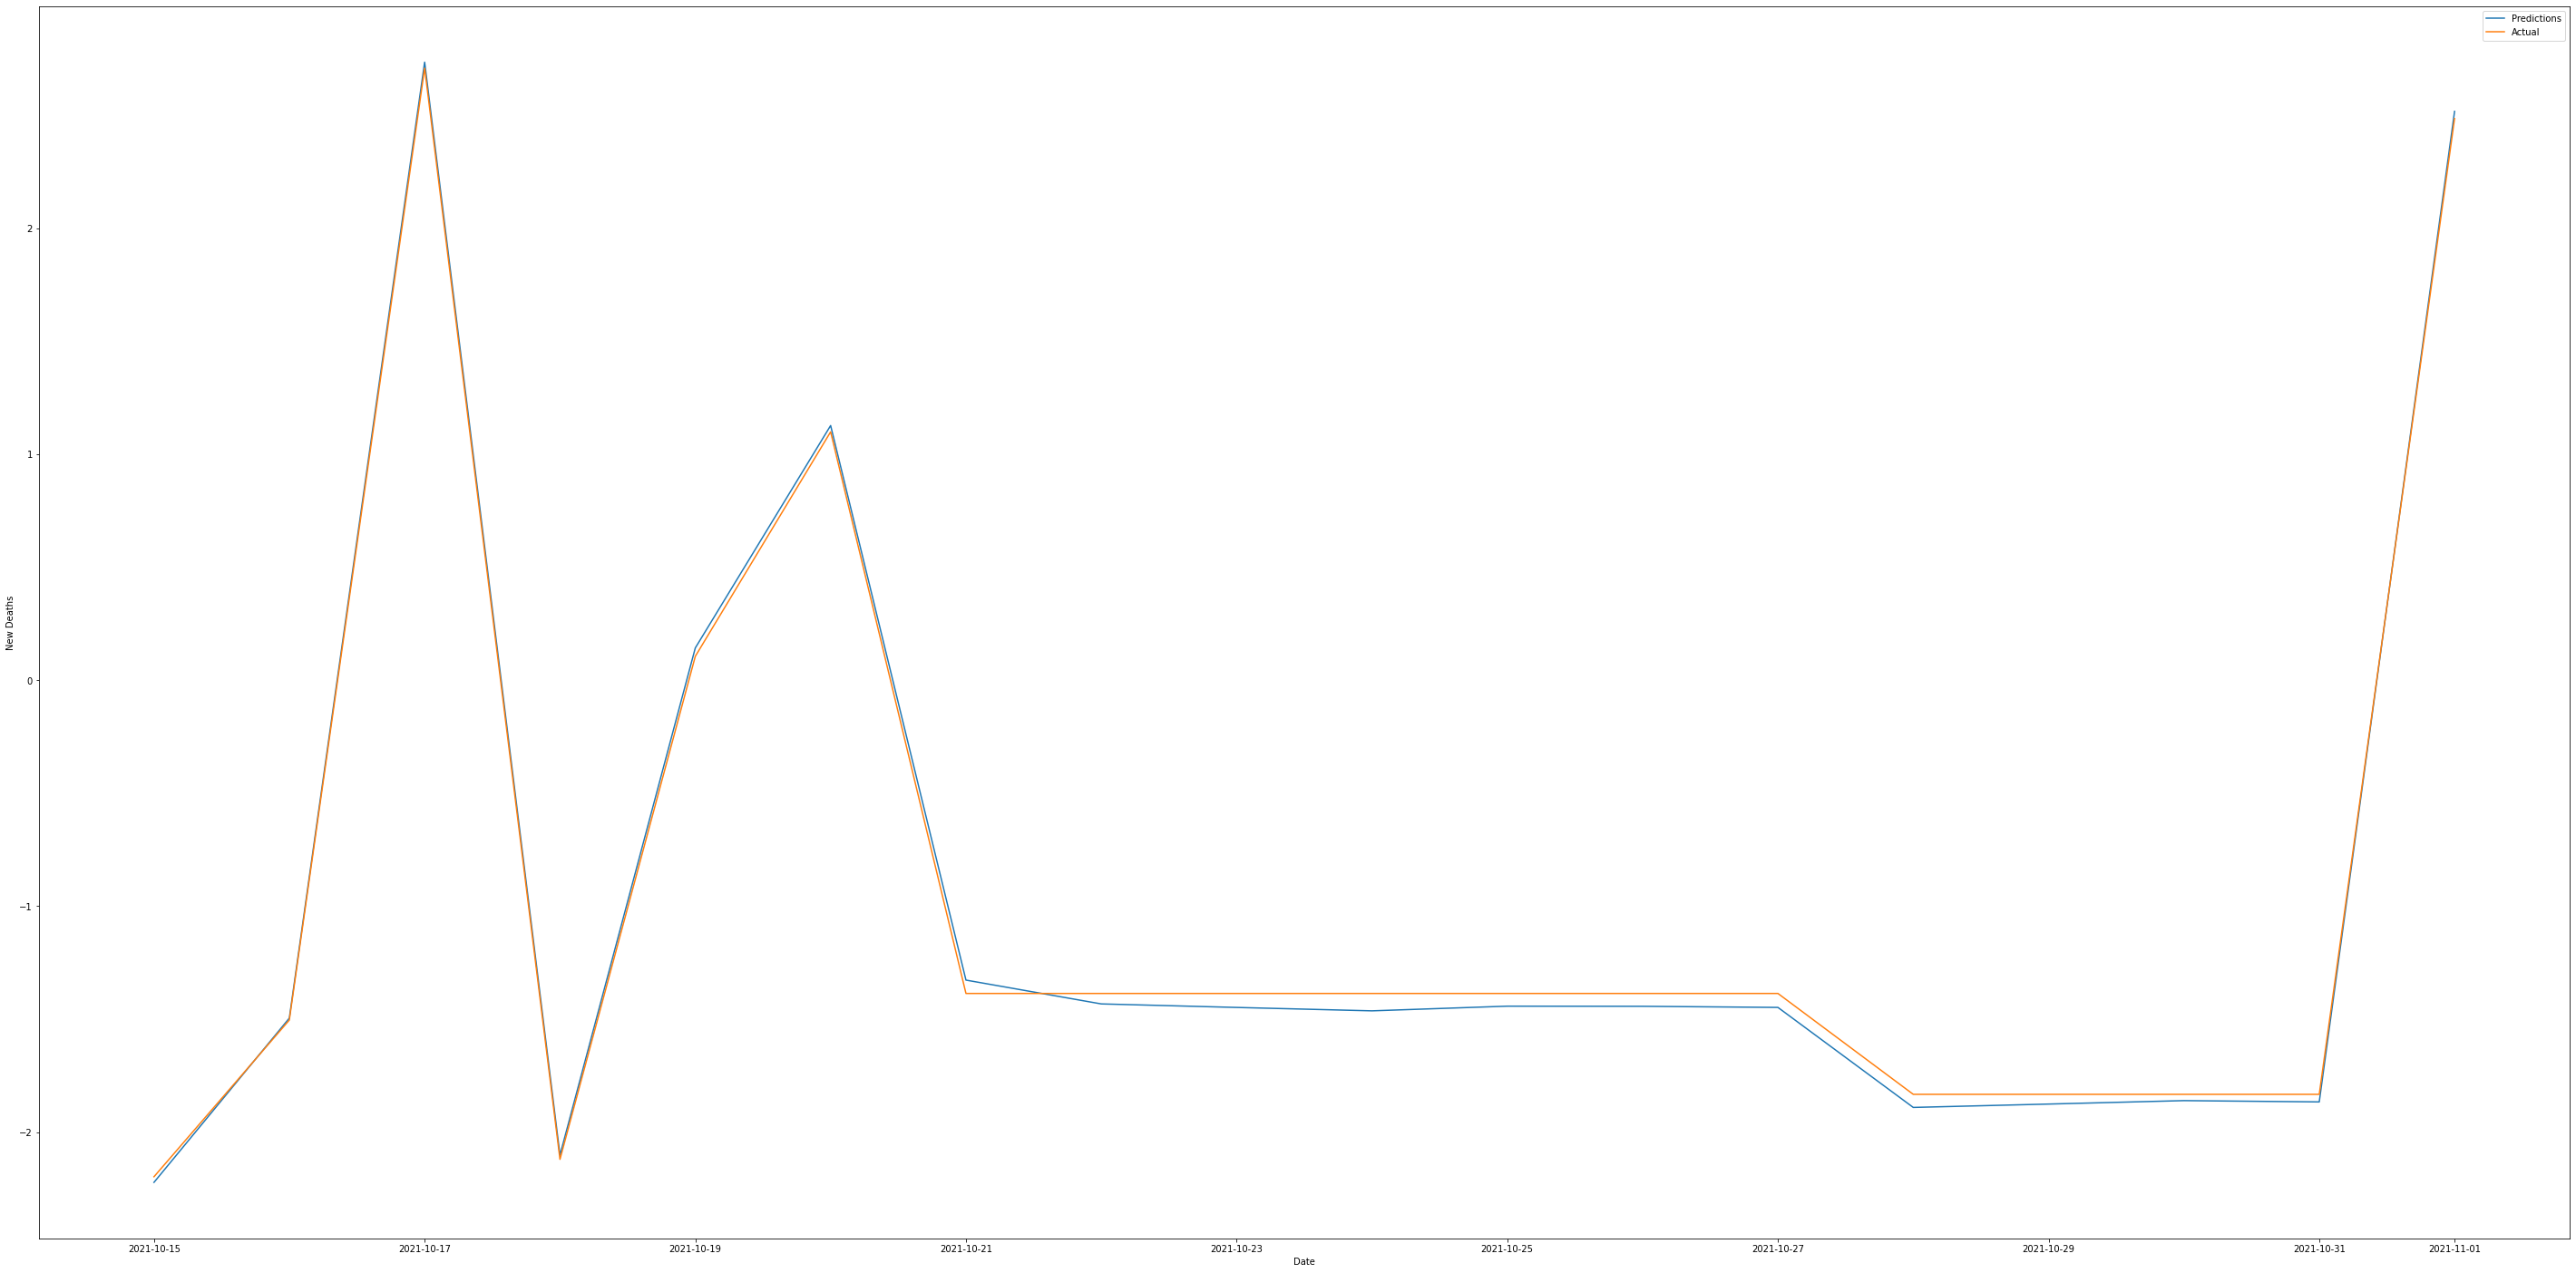

C: 1.0 - SVR Score: 0.9970362566961265


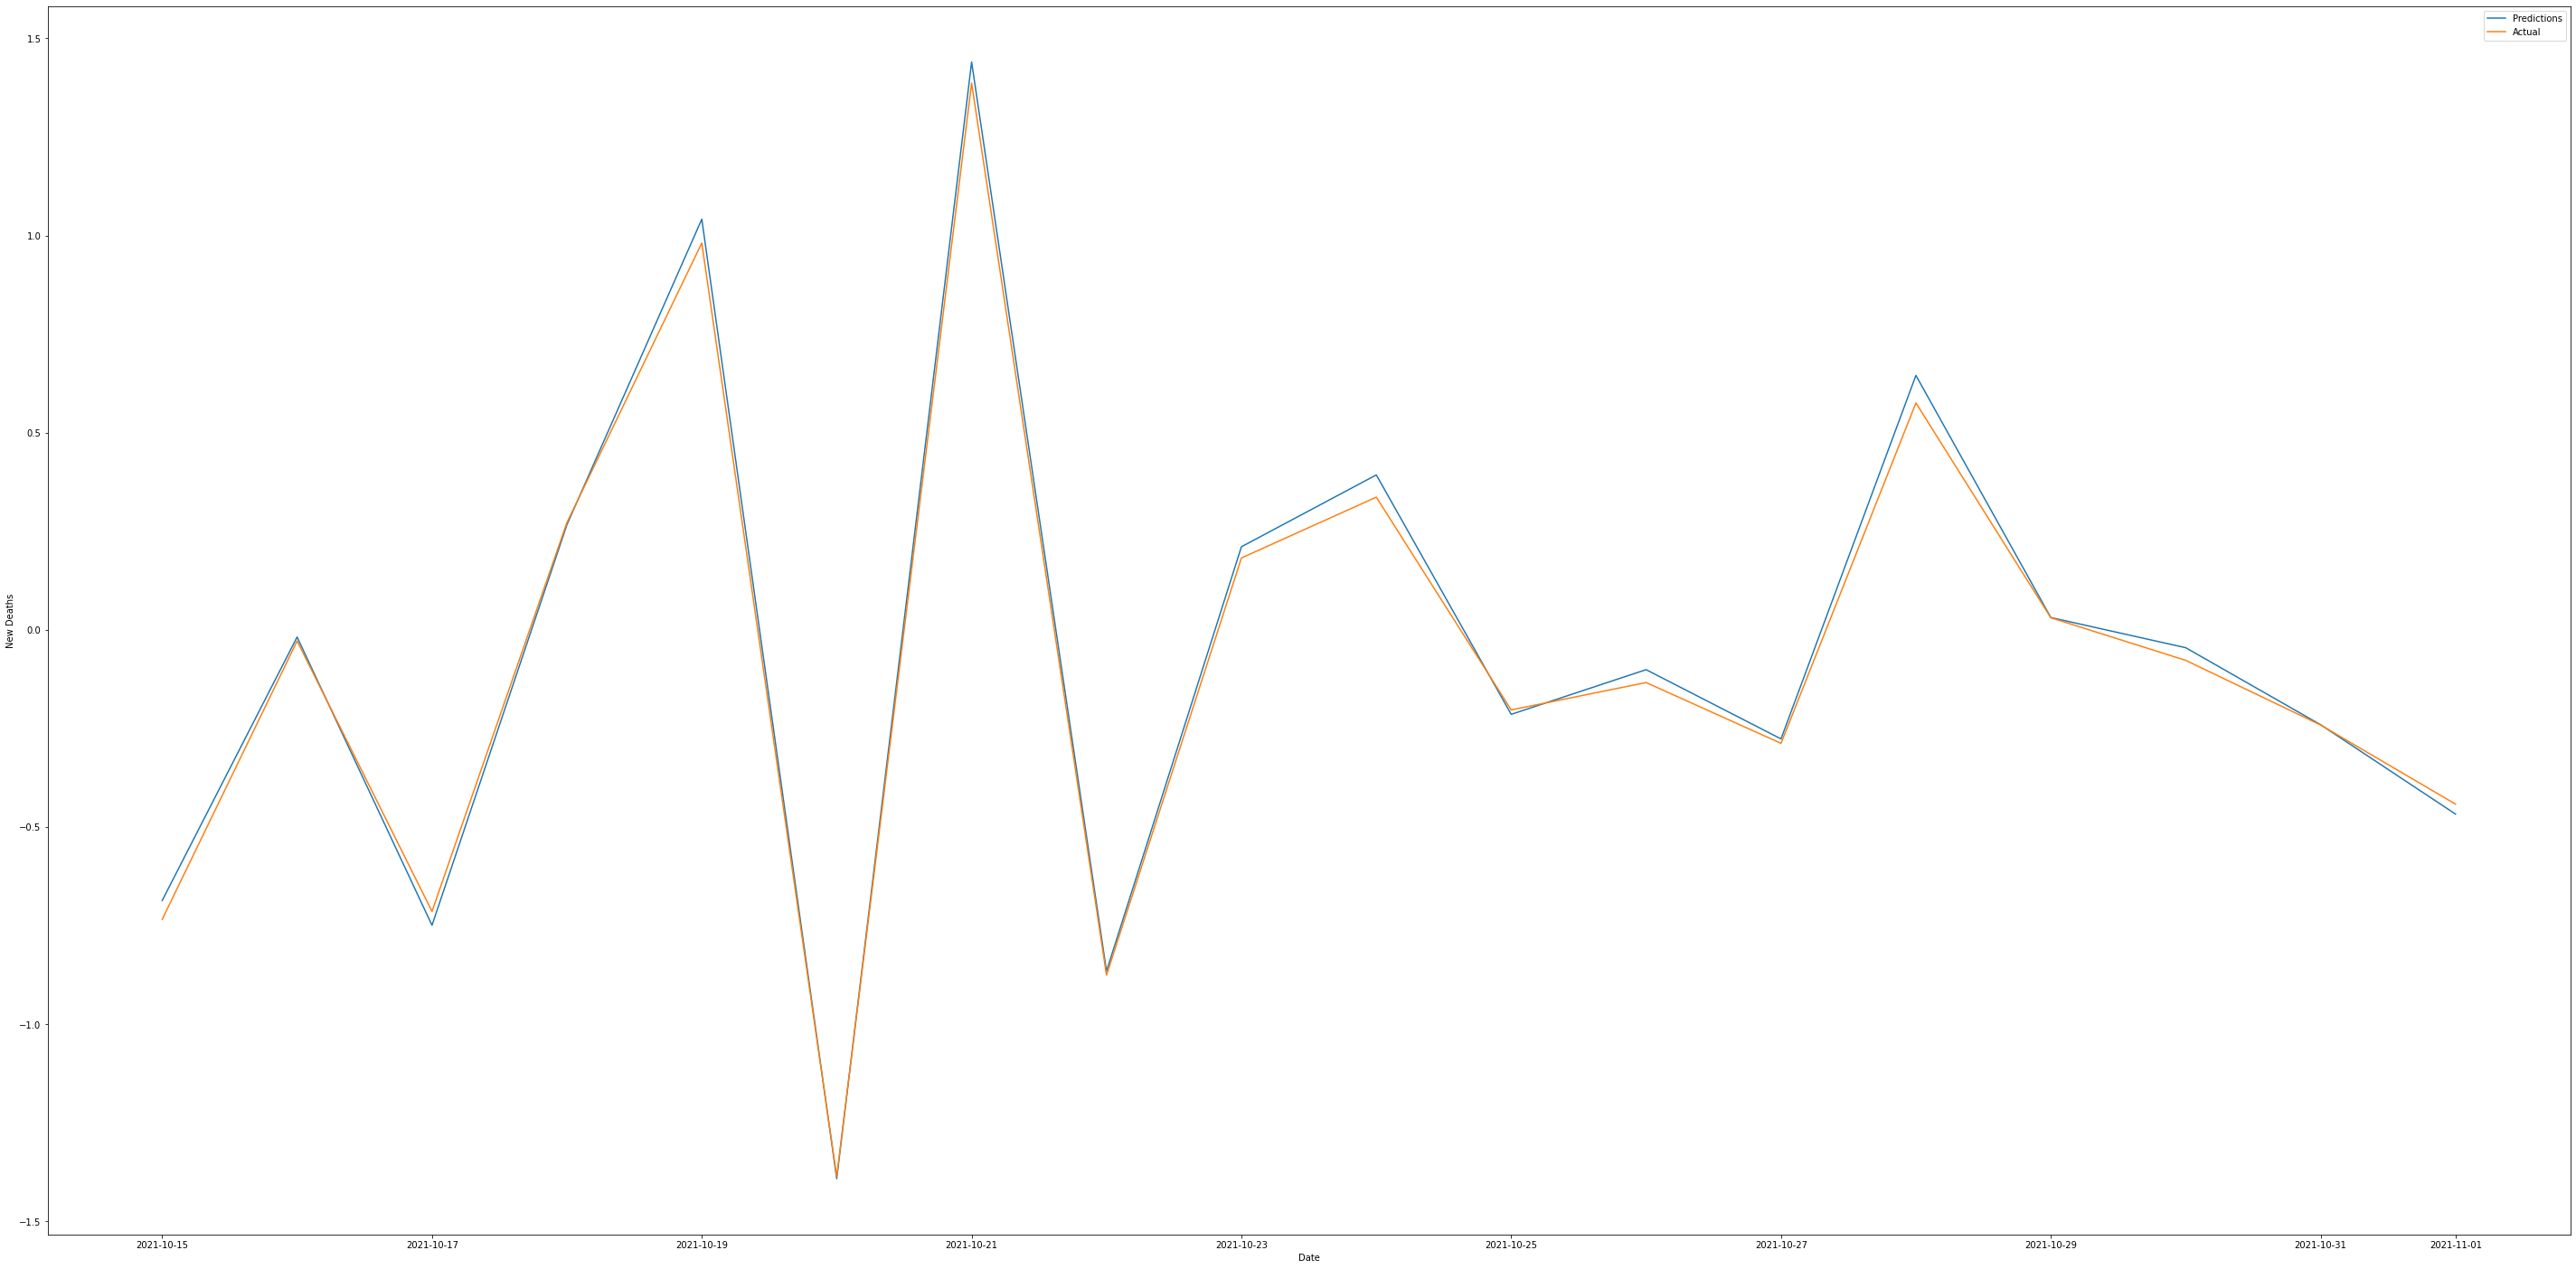

C: 1.0 - SVR Score: 0.9920067883544273


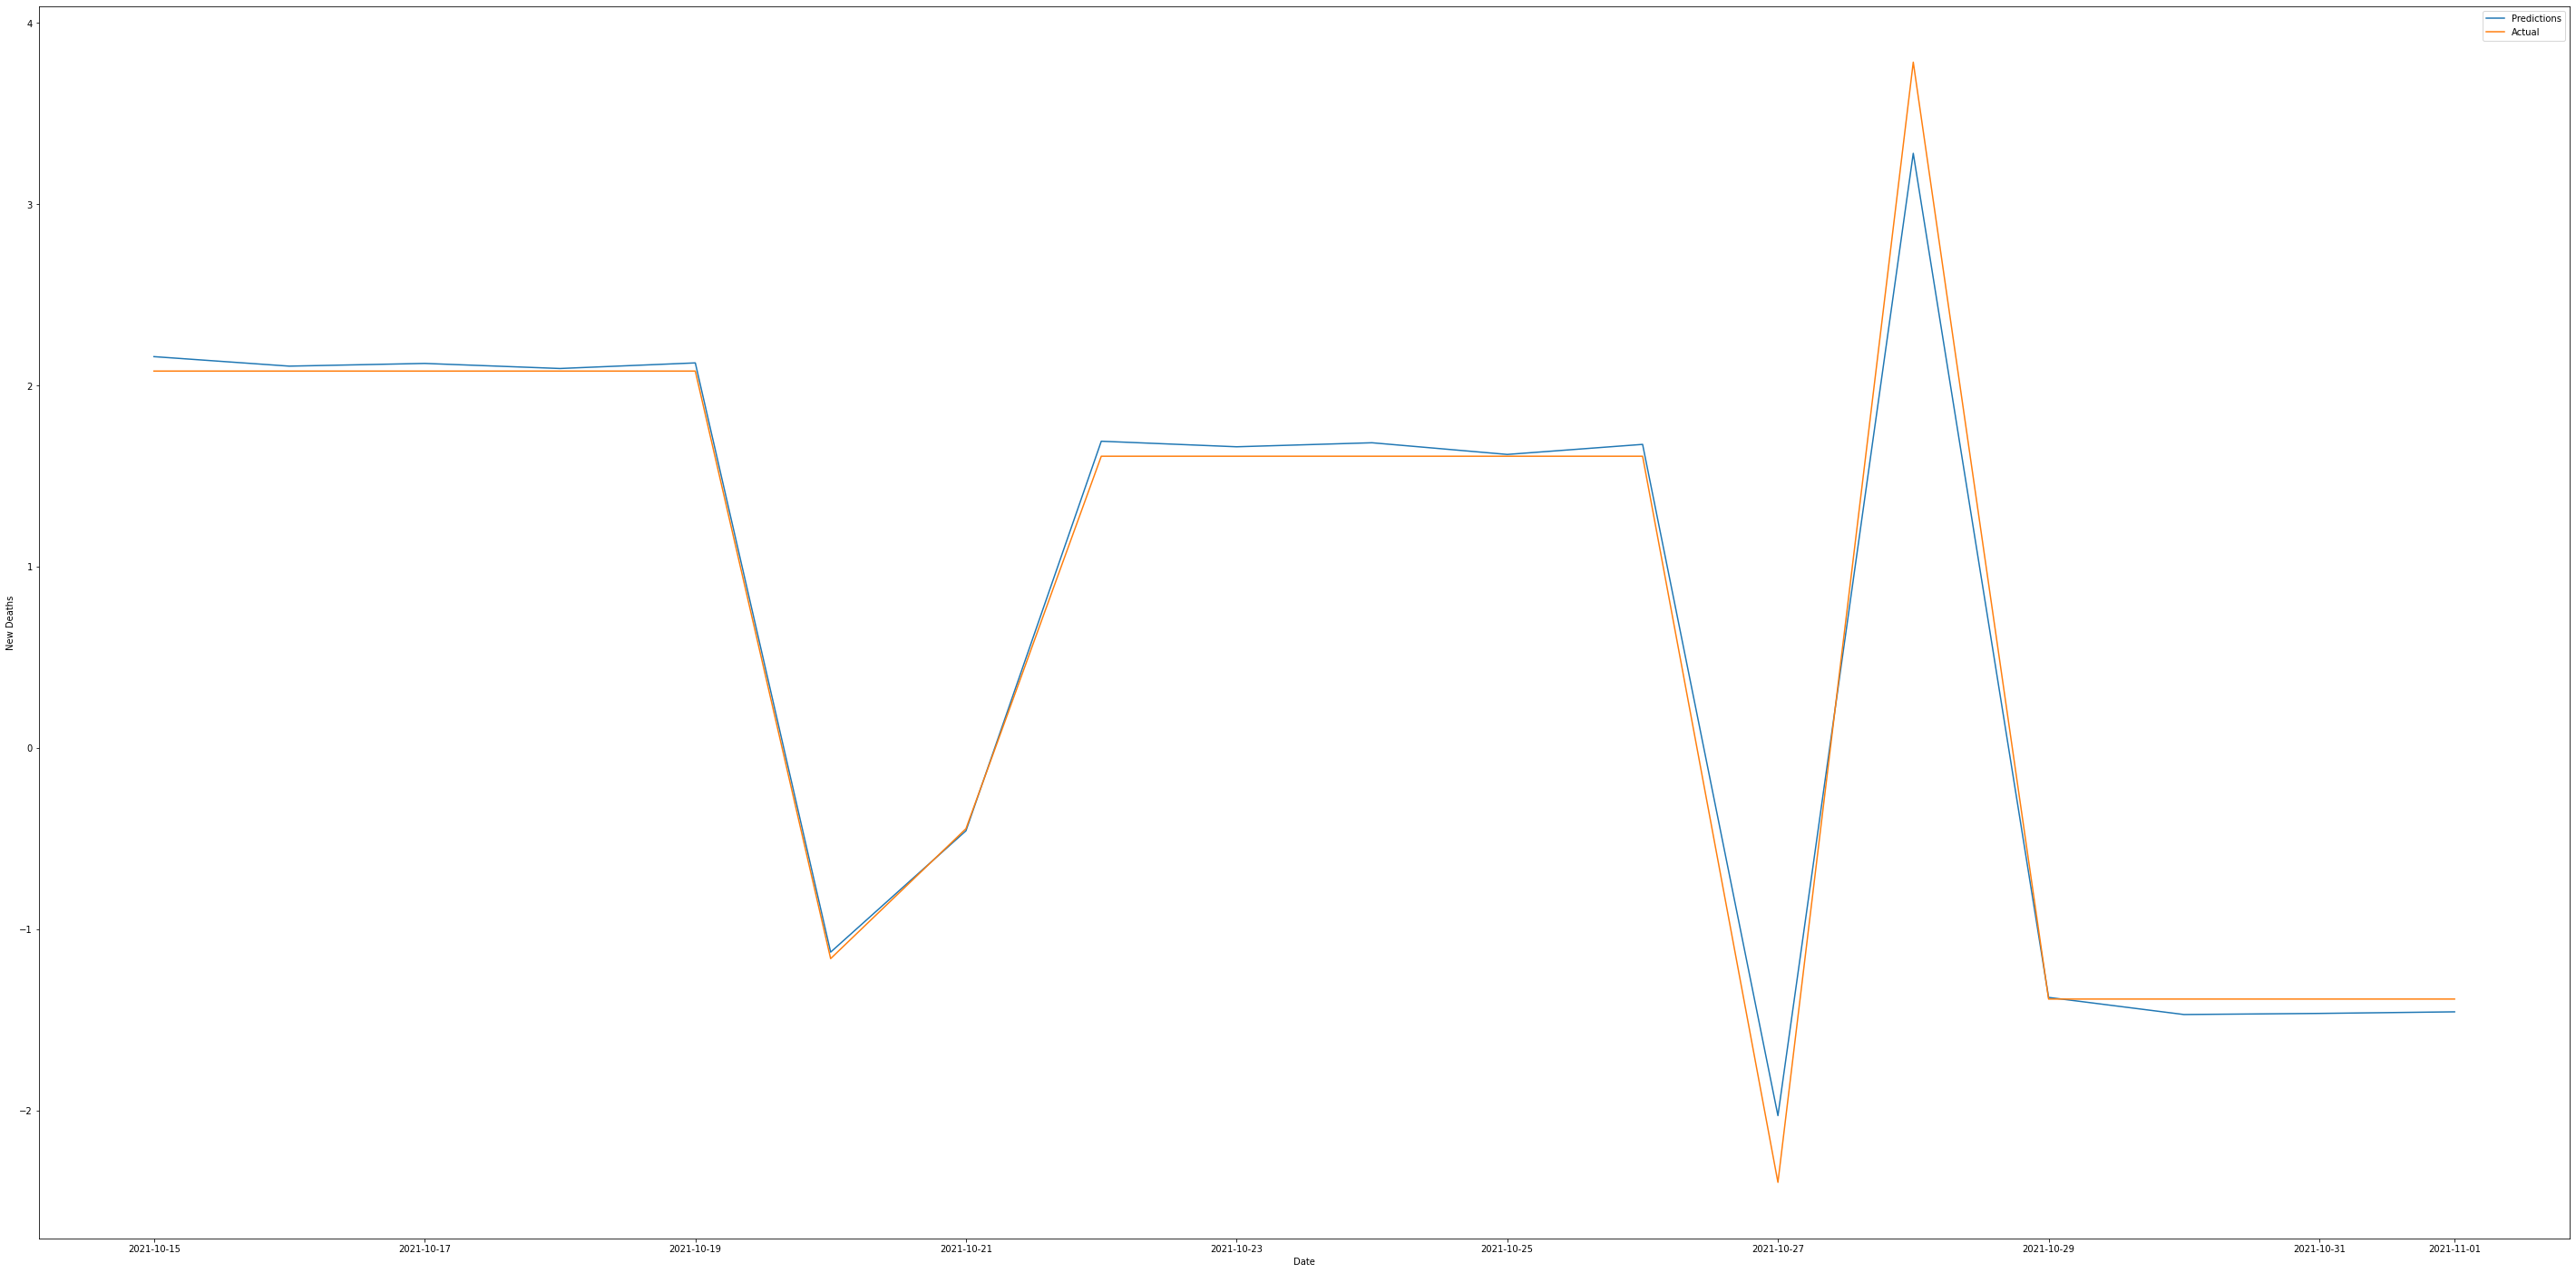

C: 1.0 - SVR Score: 0.9303931745505433


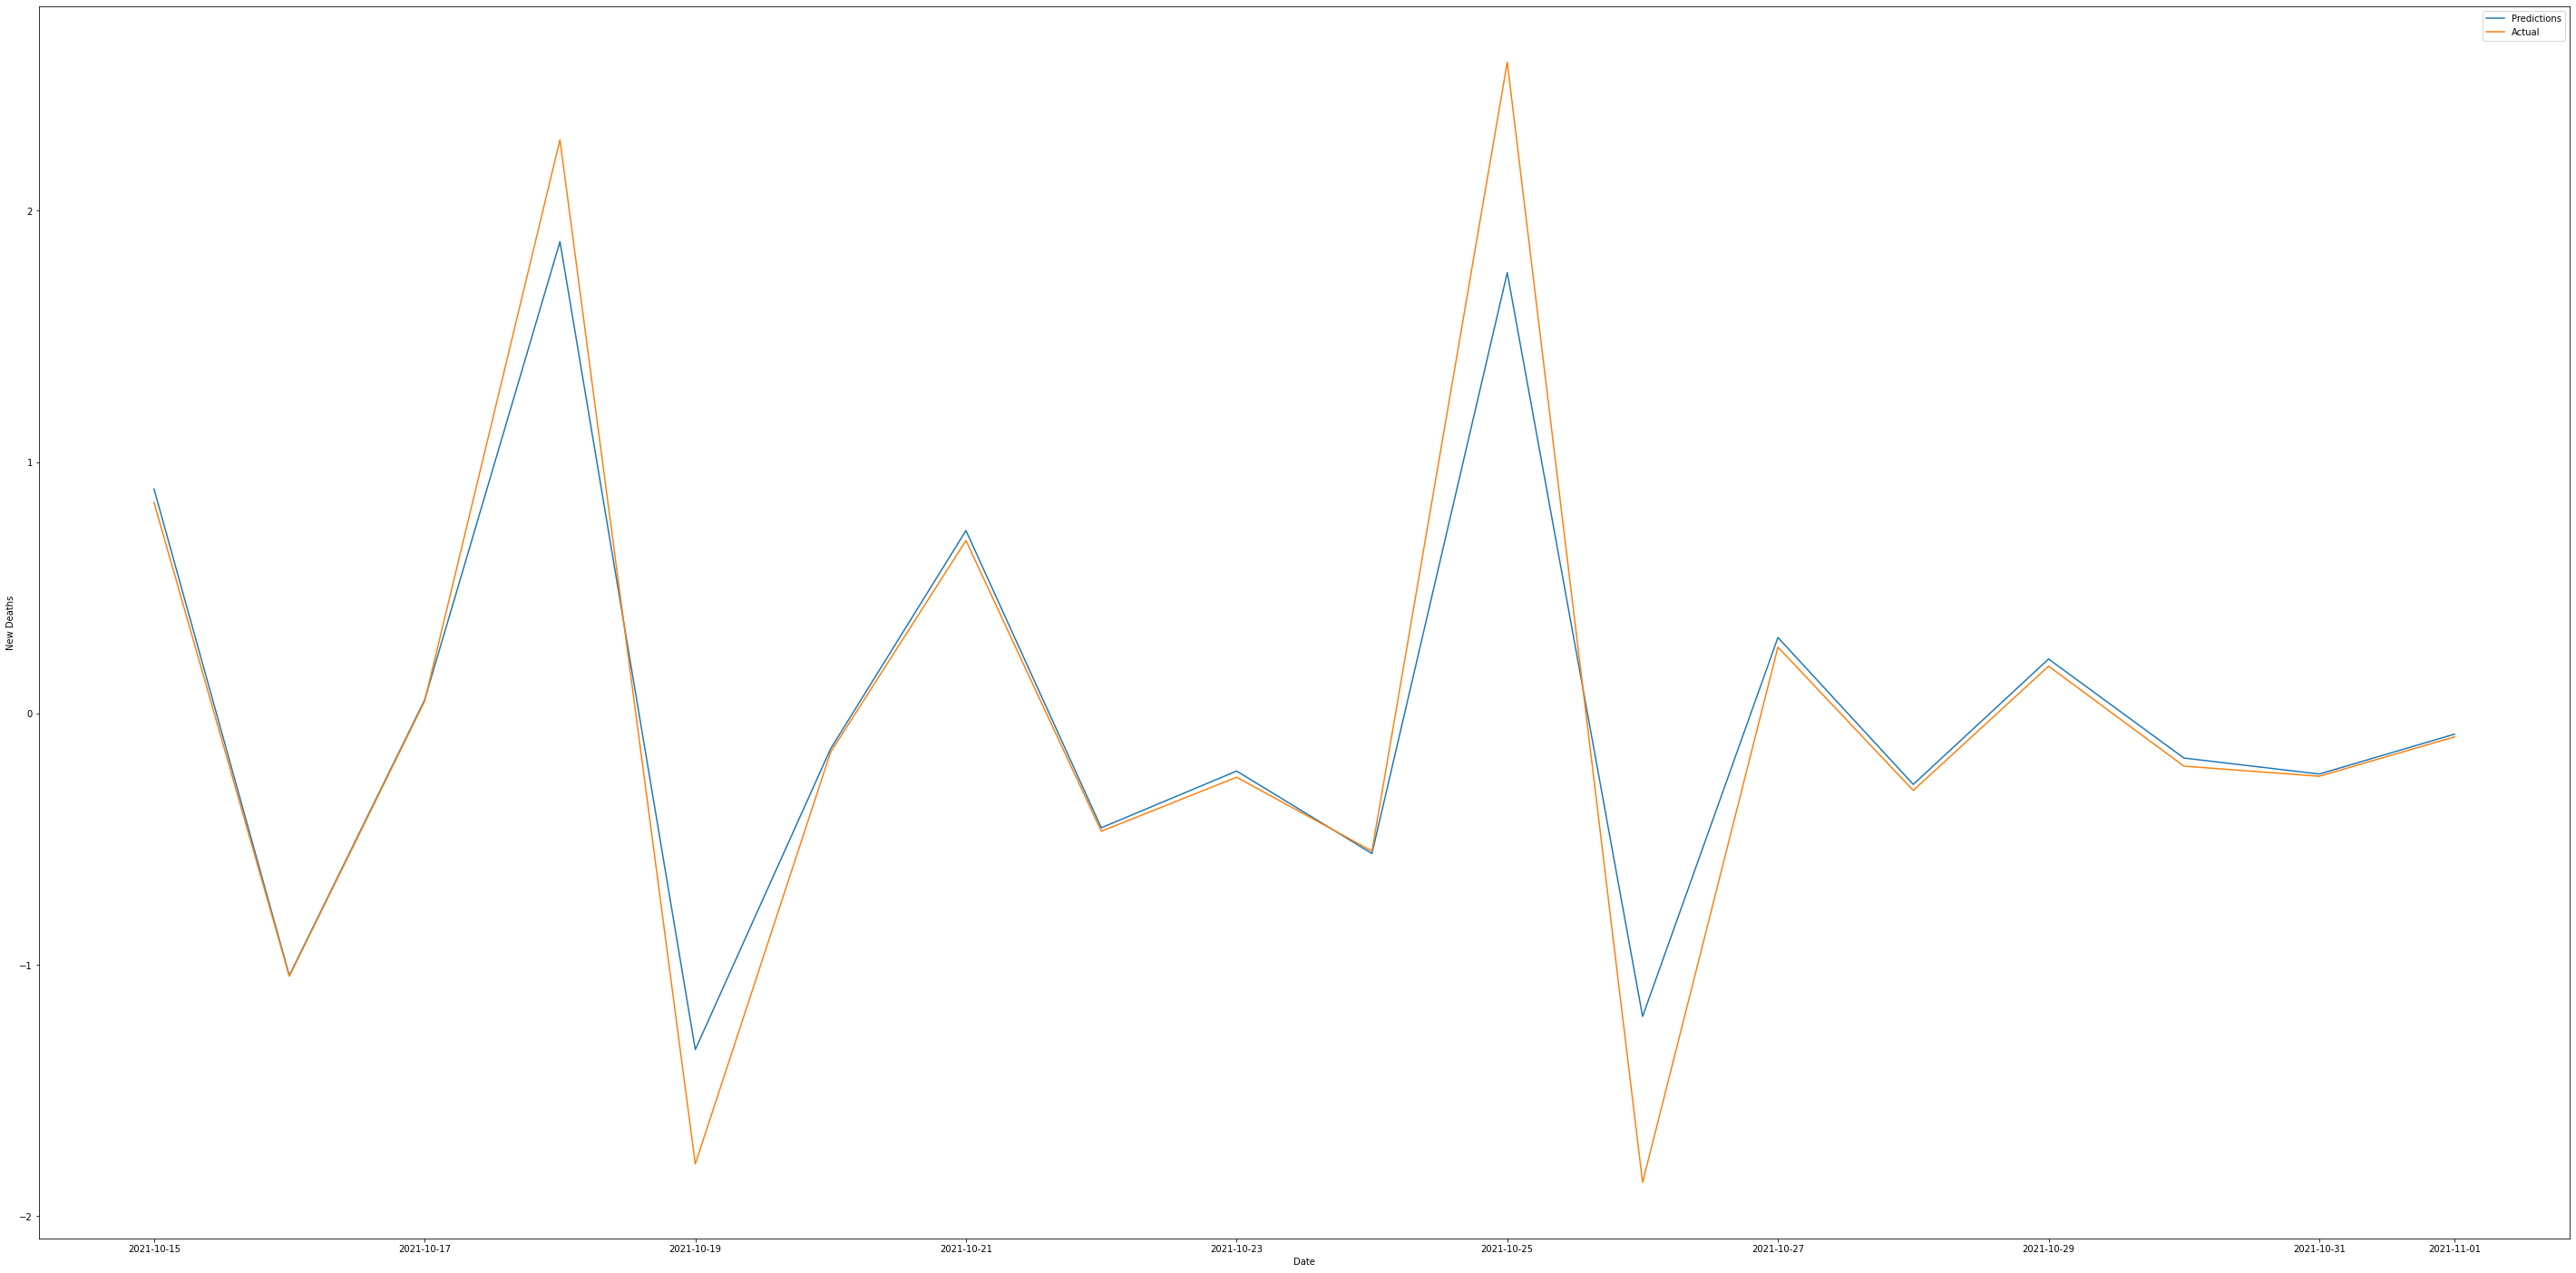

C: 1.0 - SVR Score: 0.7770070795805176


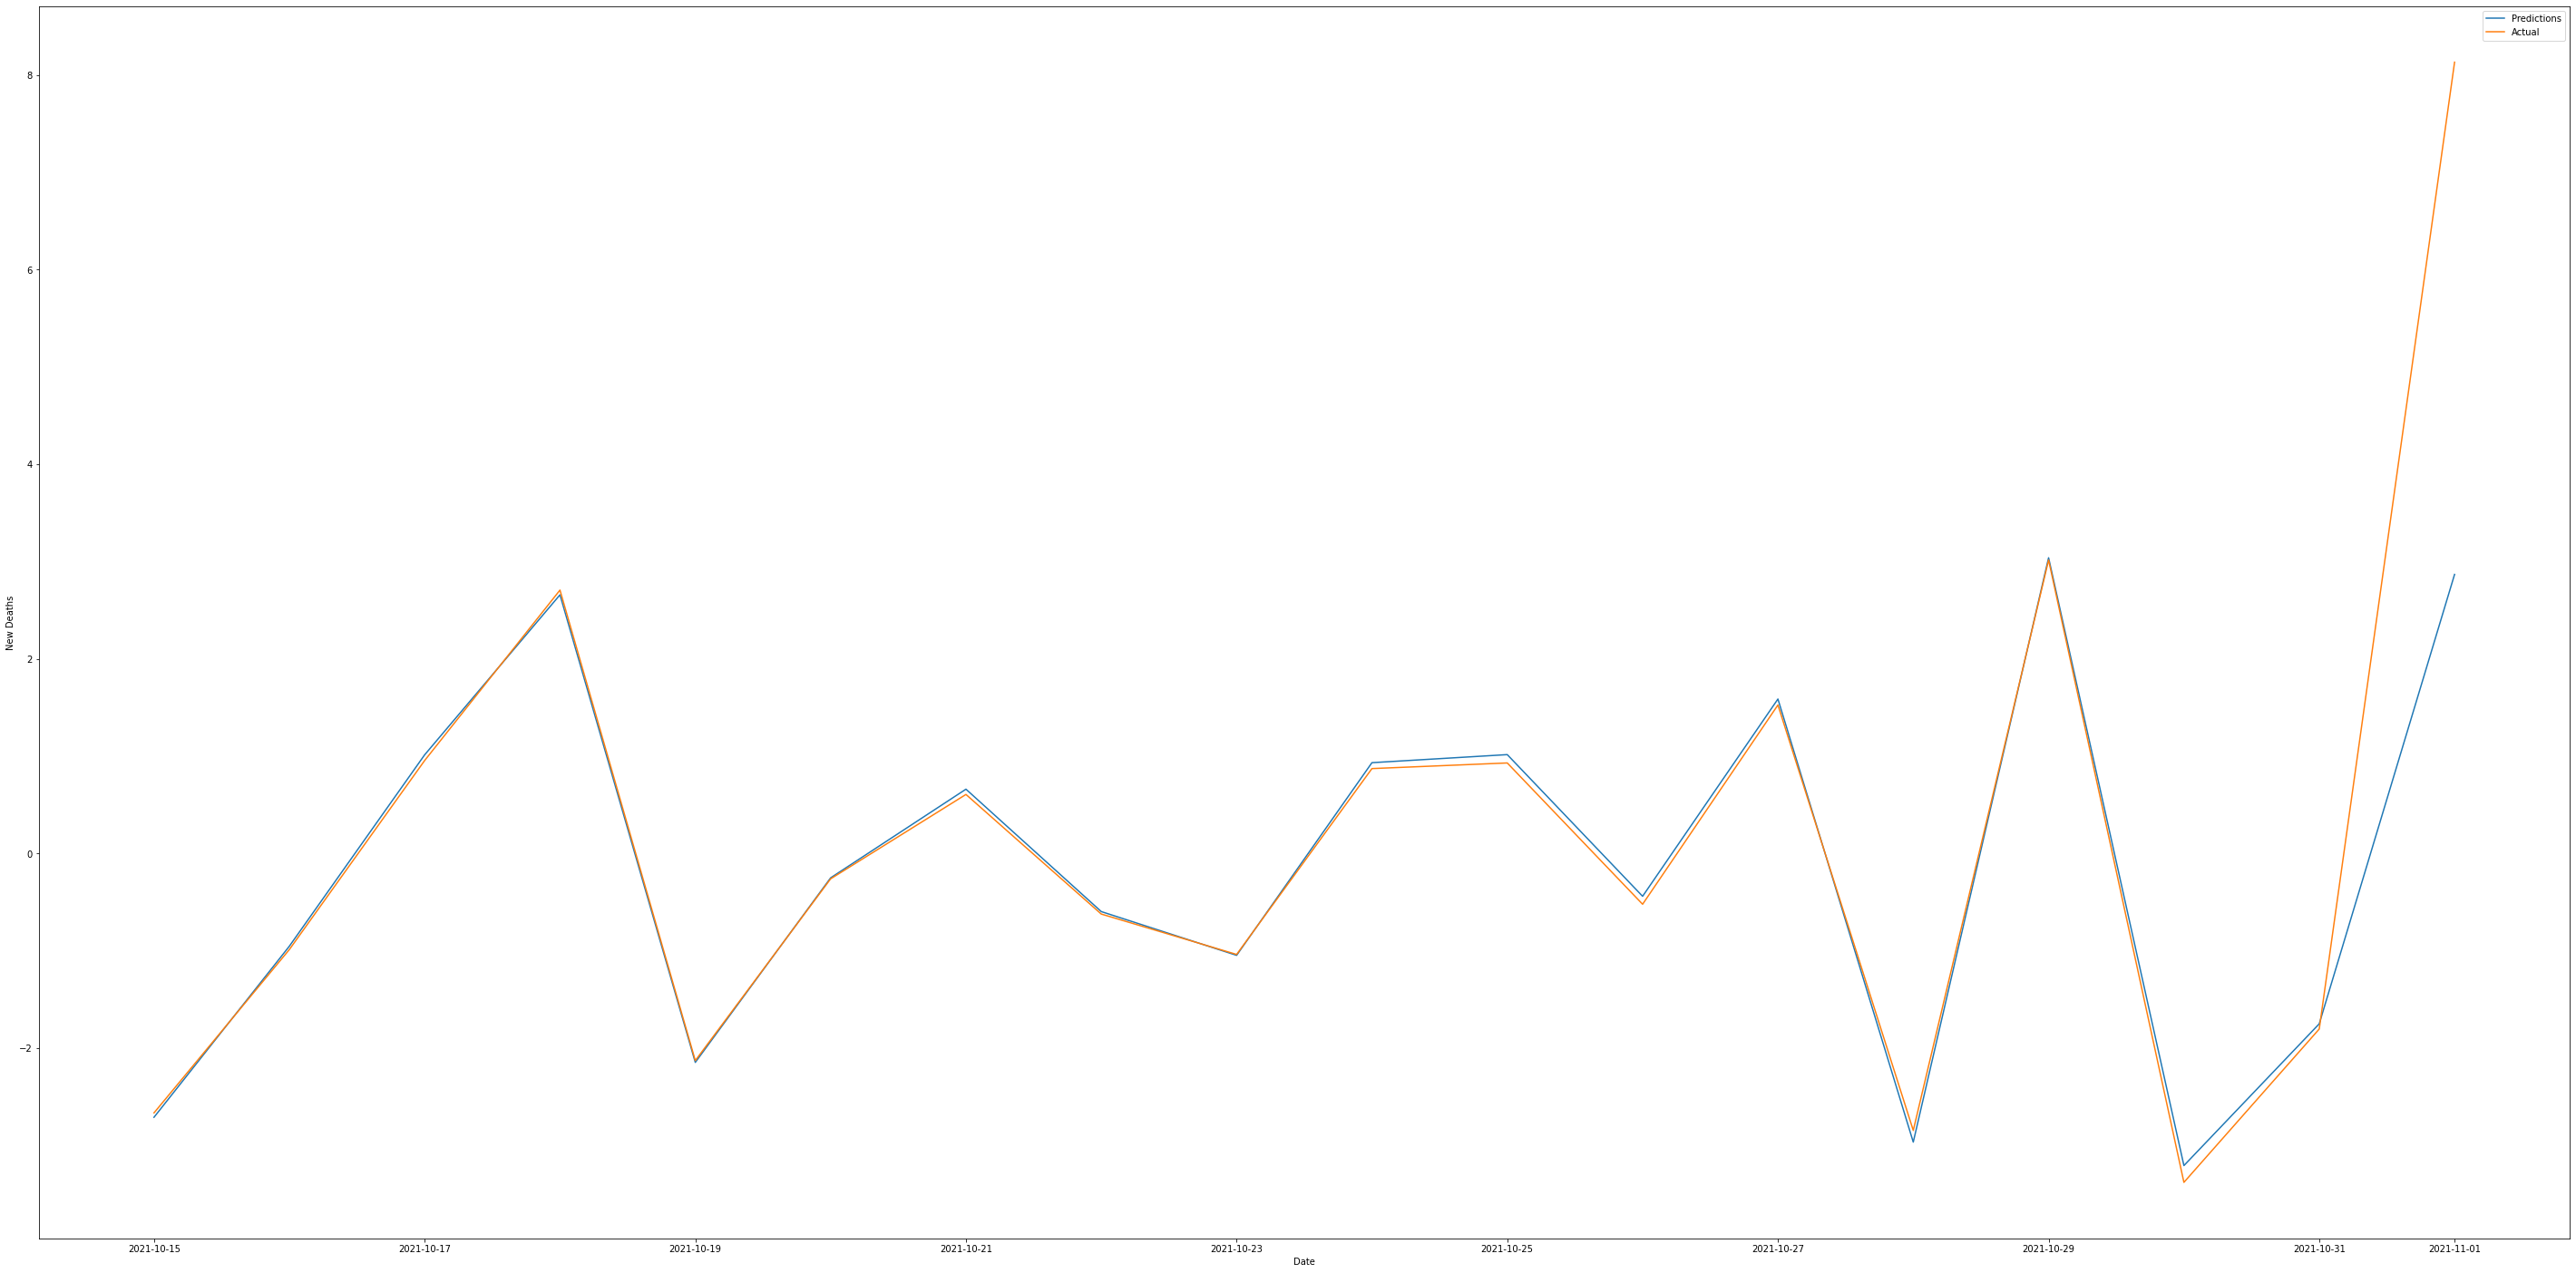

C: 1.0 - SVR Score: 0.9762208790629932


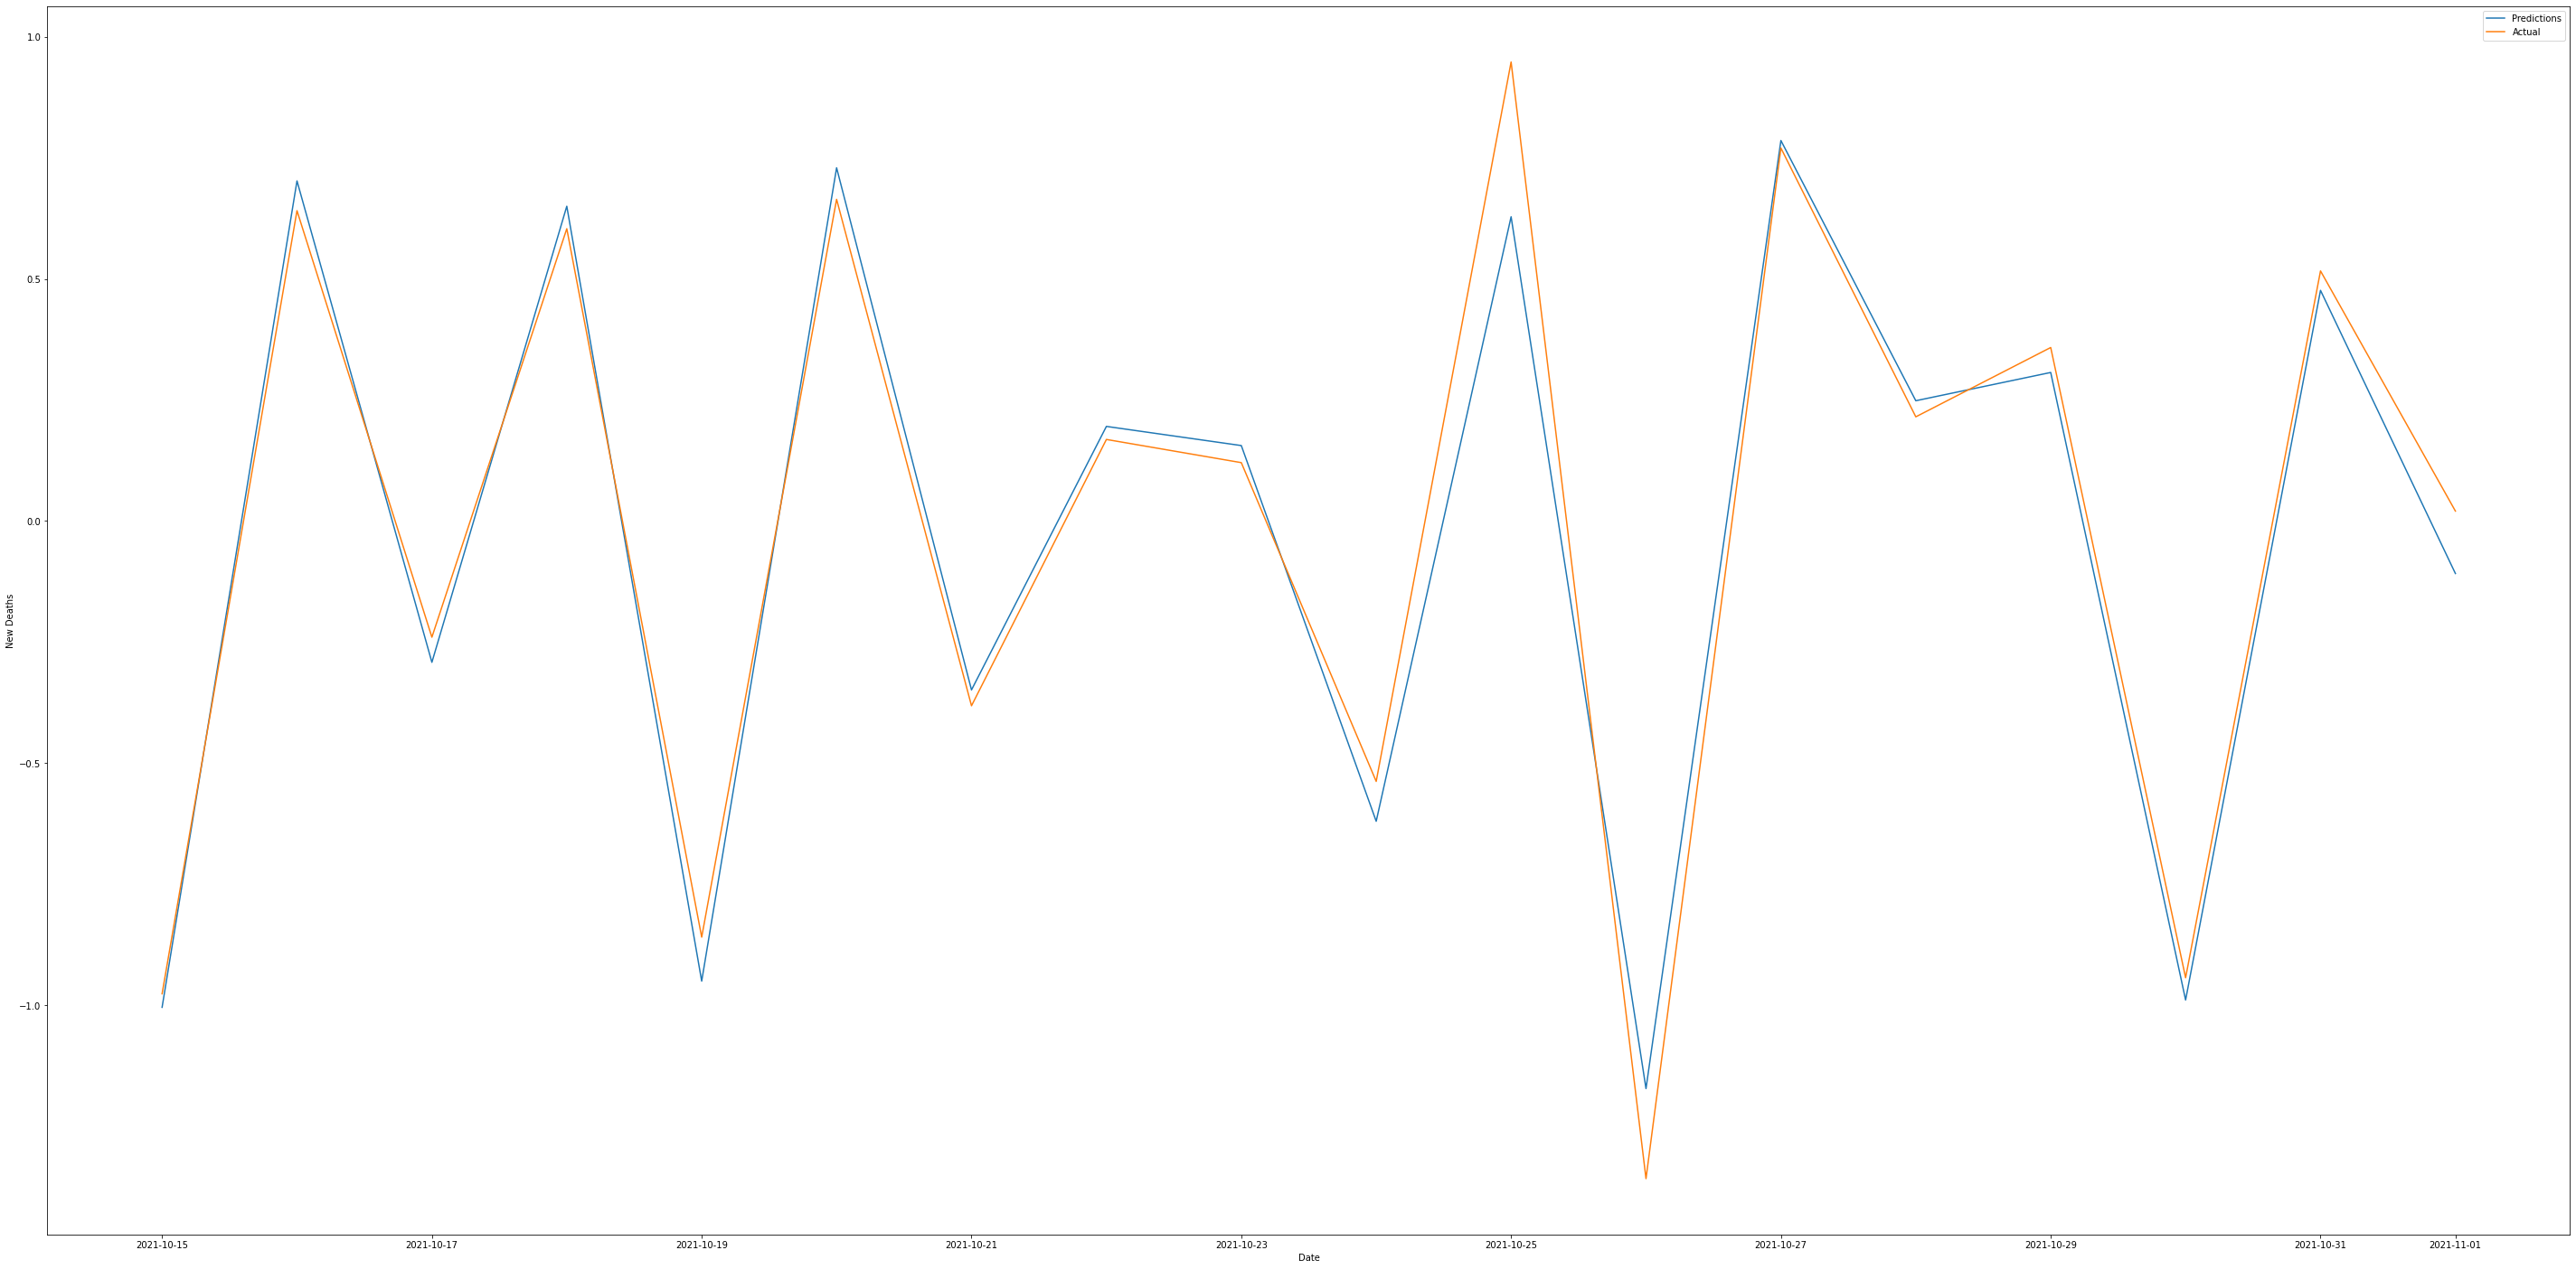

C: 1.0 - SVR Score: 0.9963233836672728


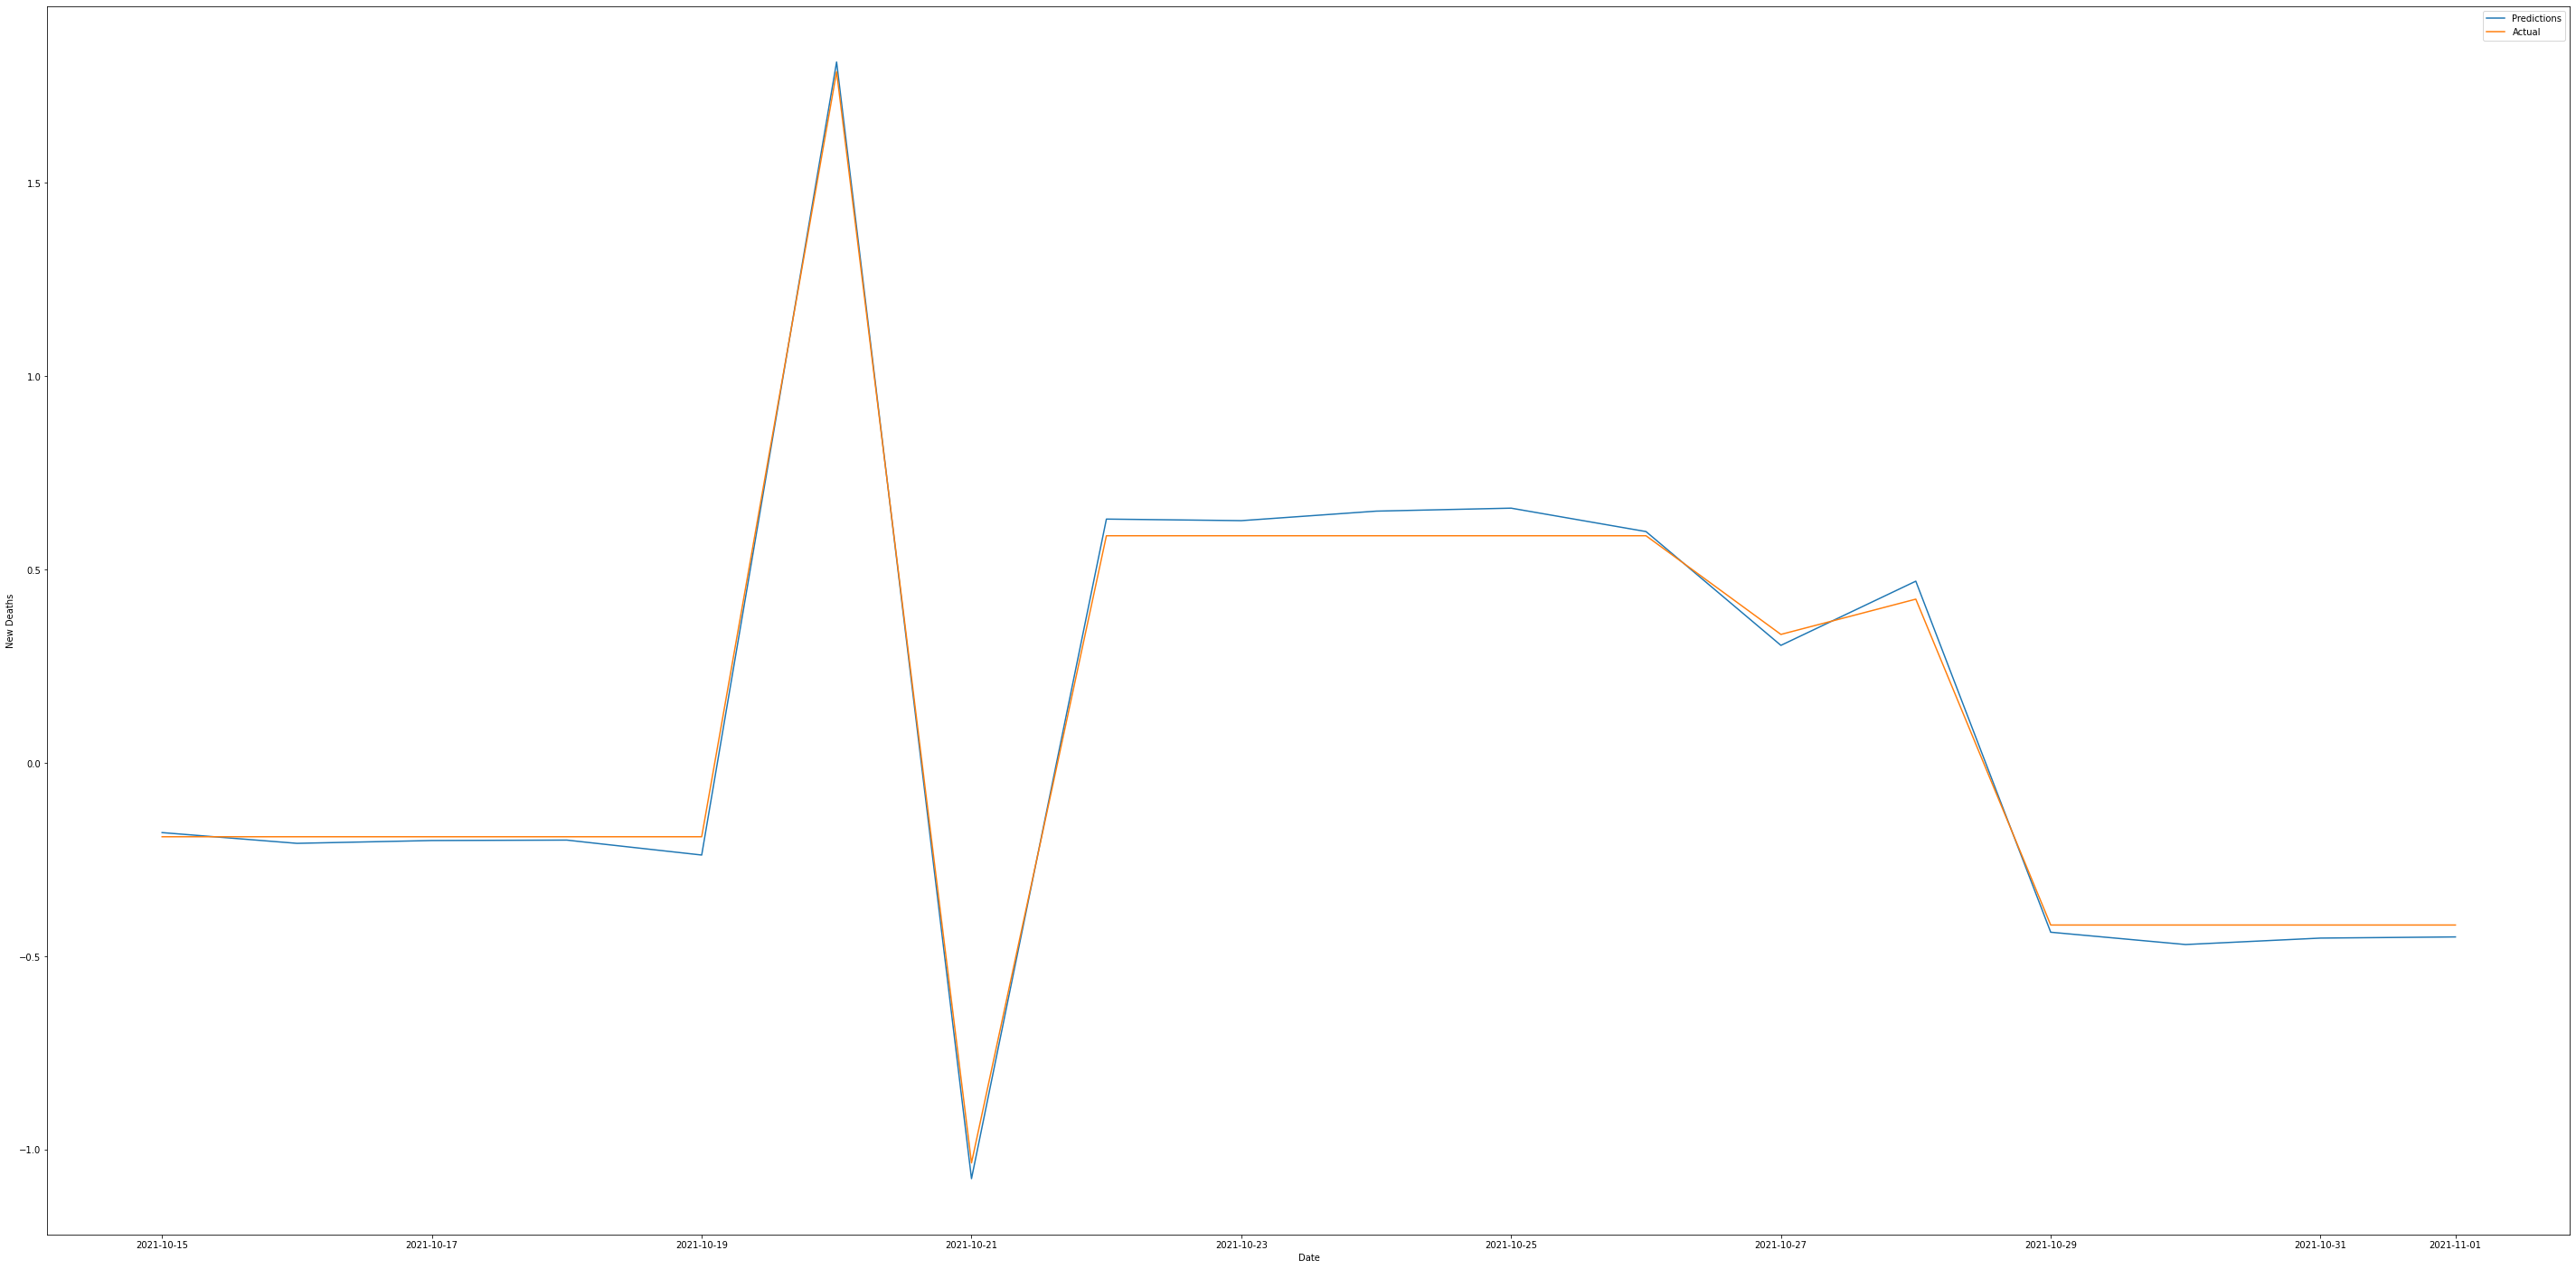

C: 1.0 - SVR Score: 0.0


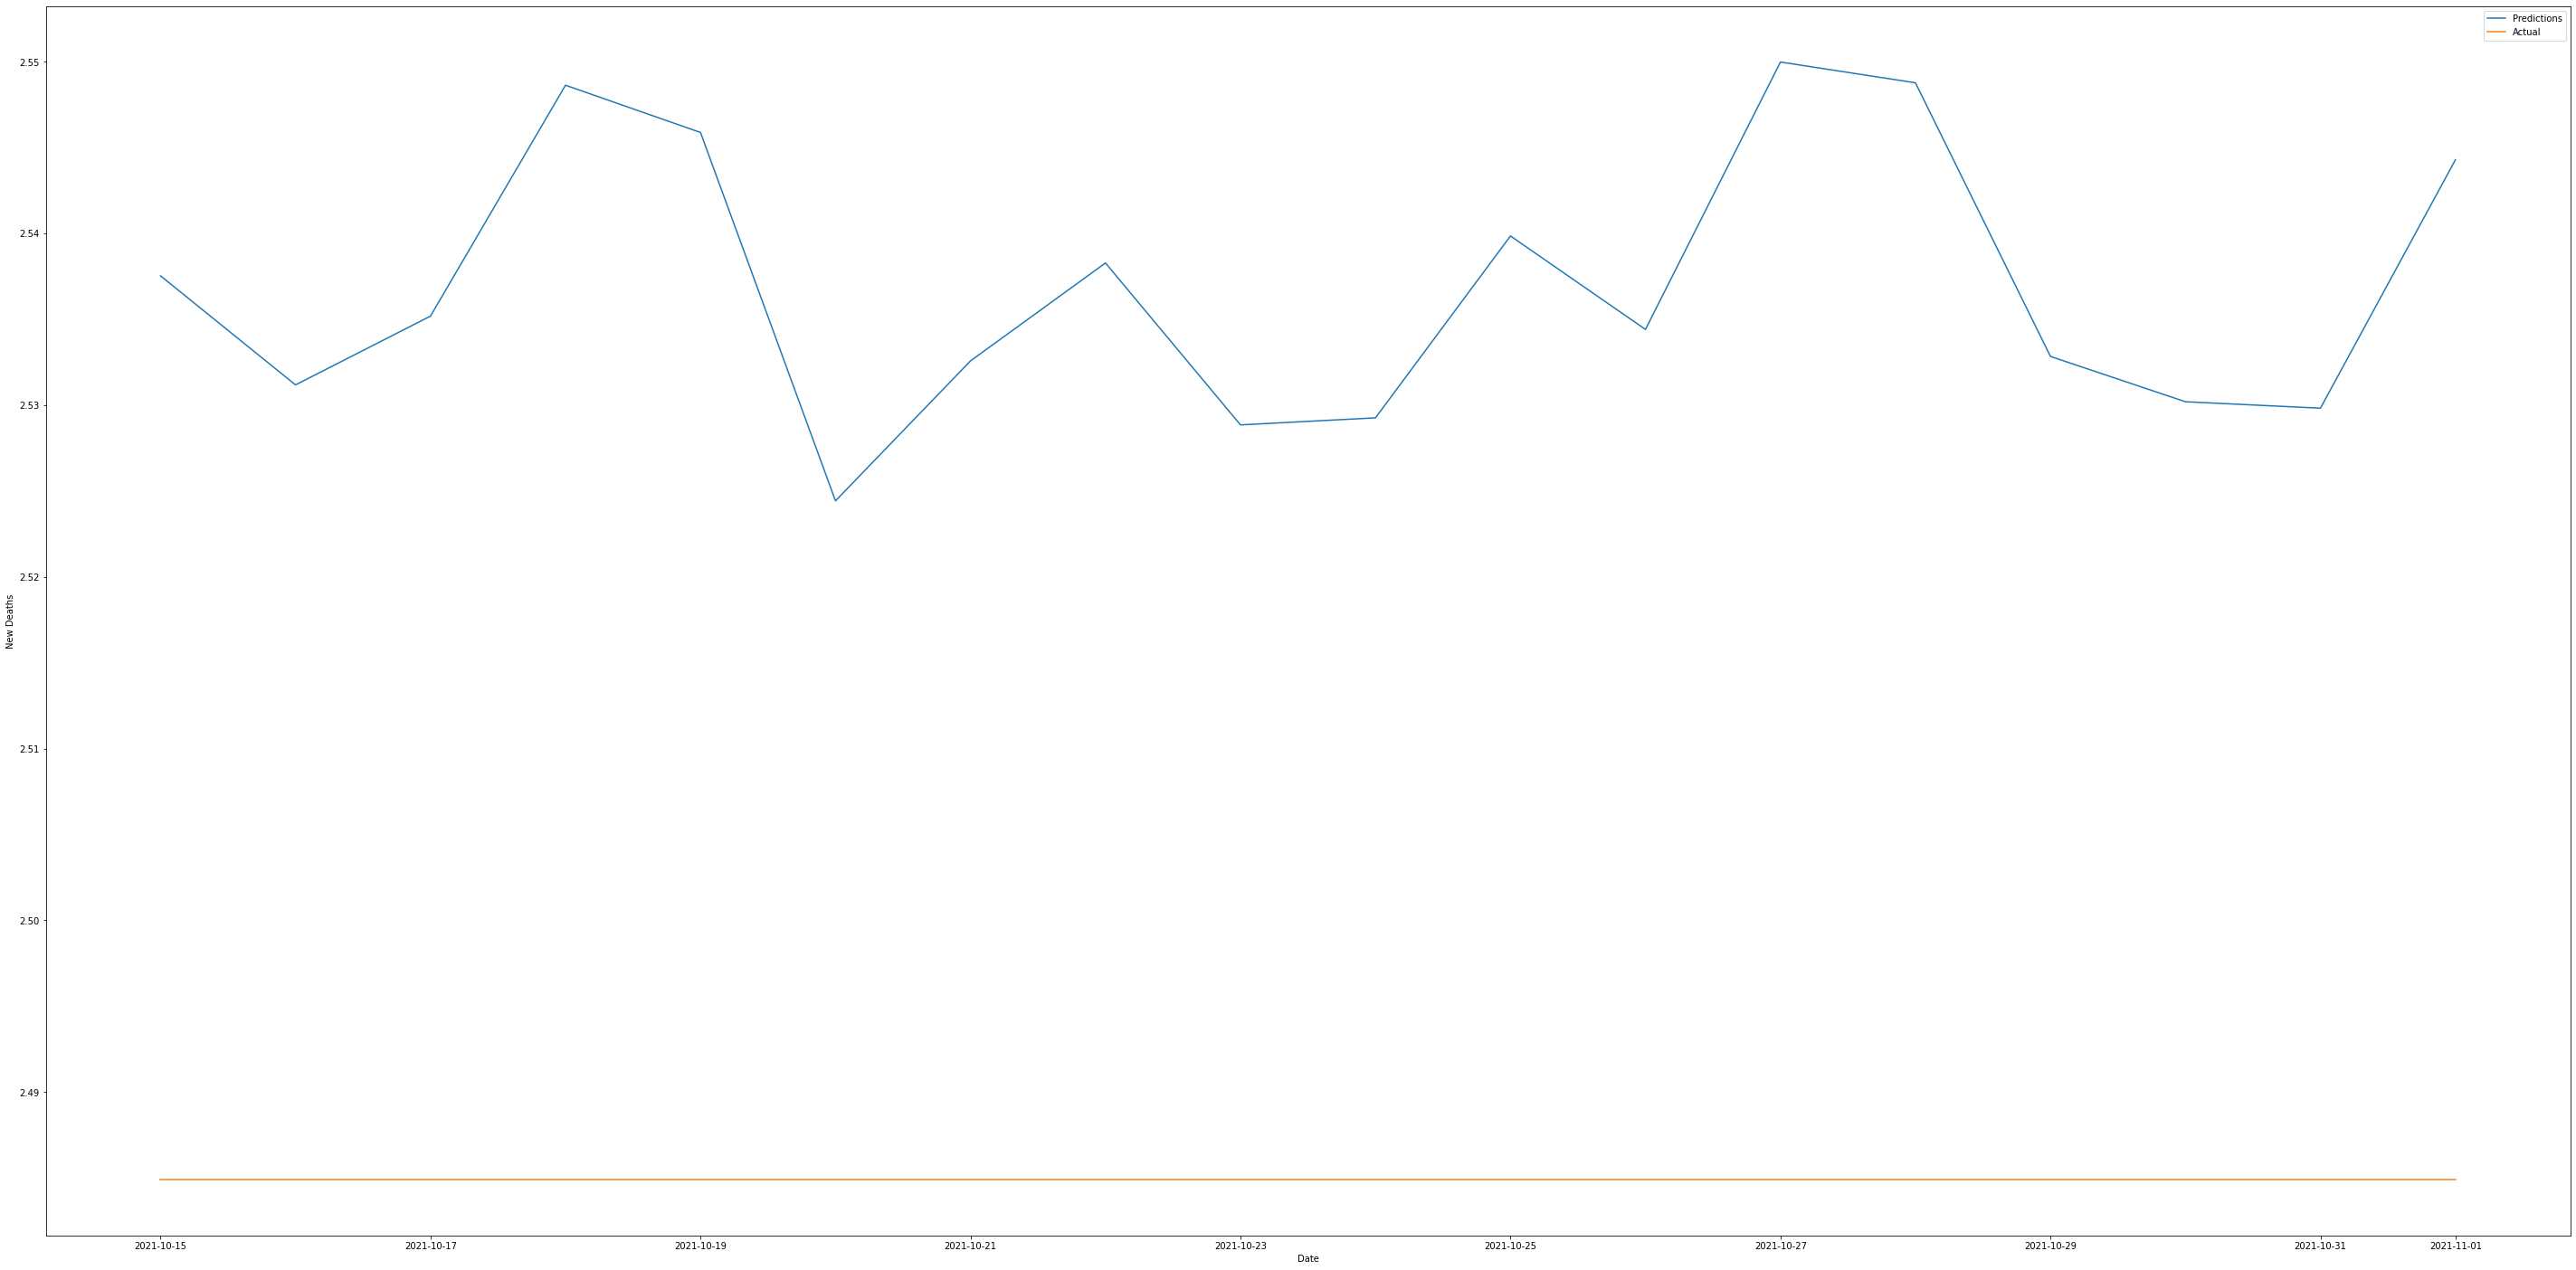

C: 1.0 - SVR Score: 0.9973207449811079


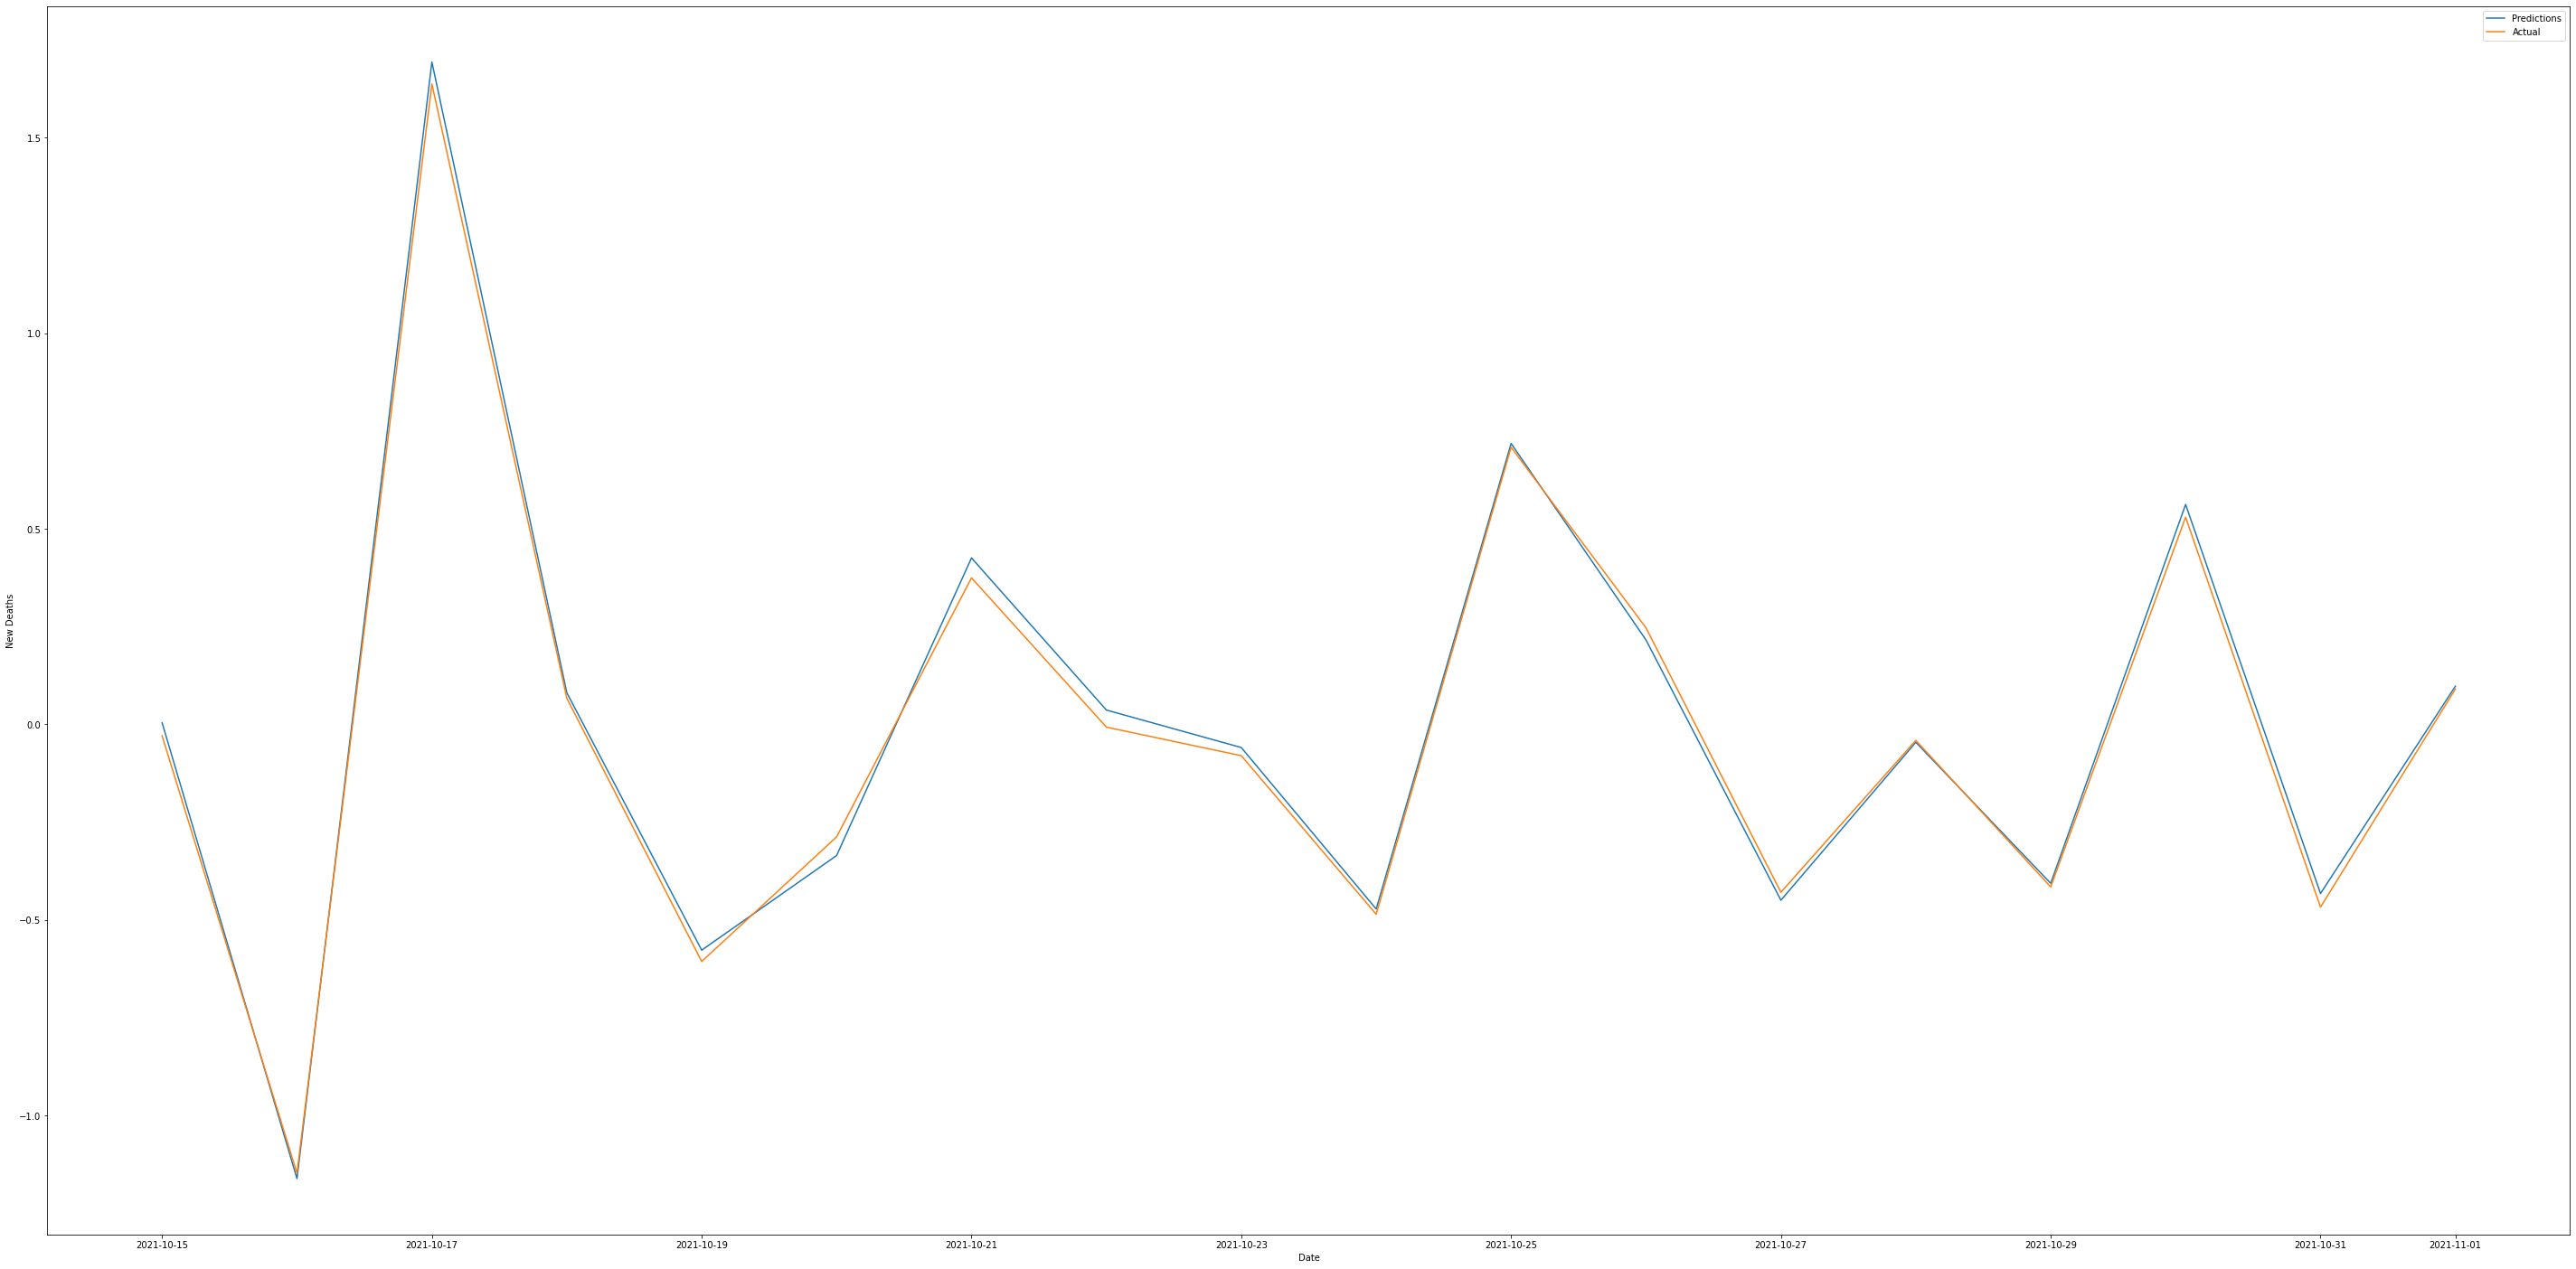

C: 1.0 - SVR Score: 0.0


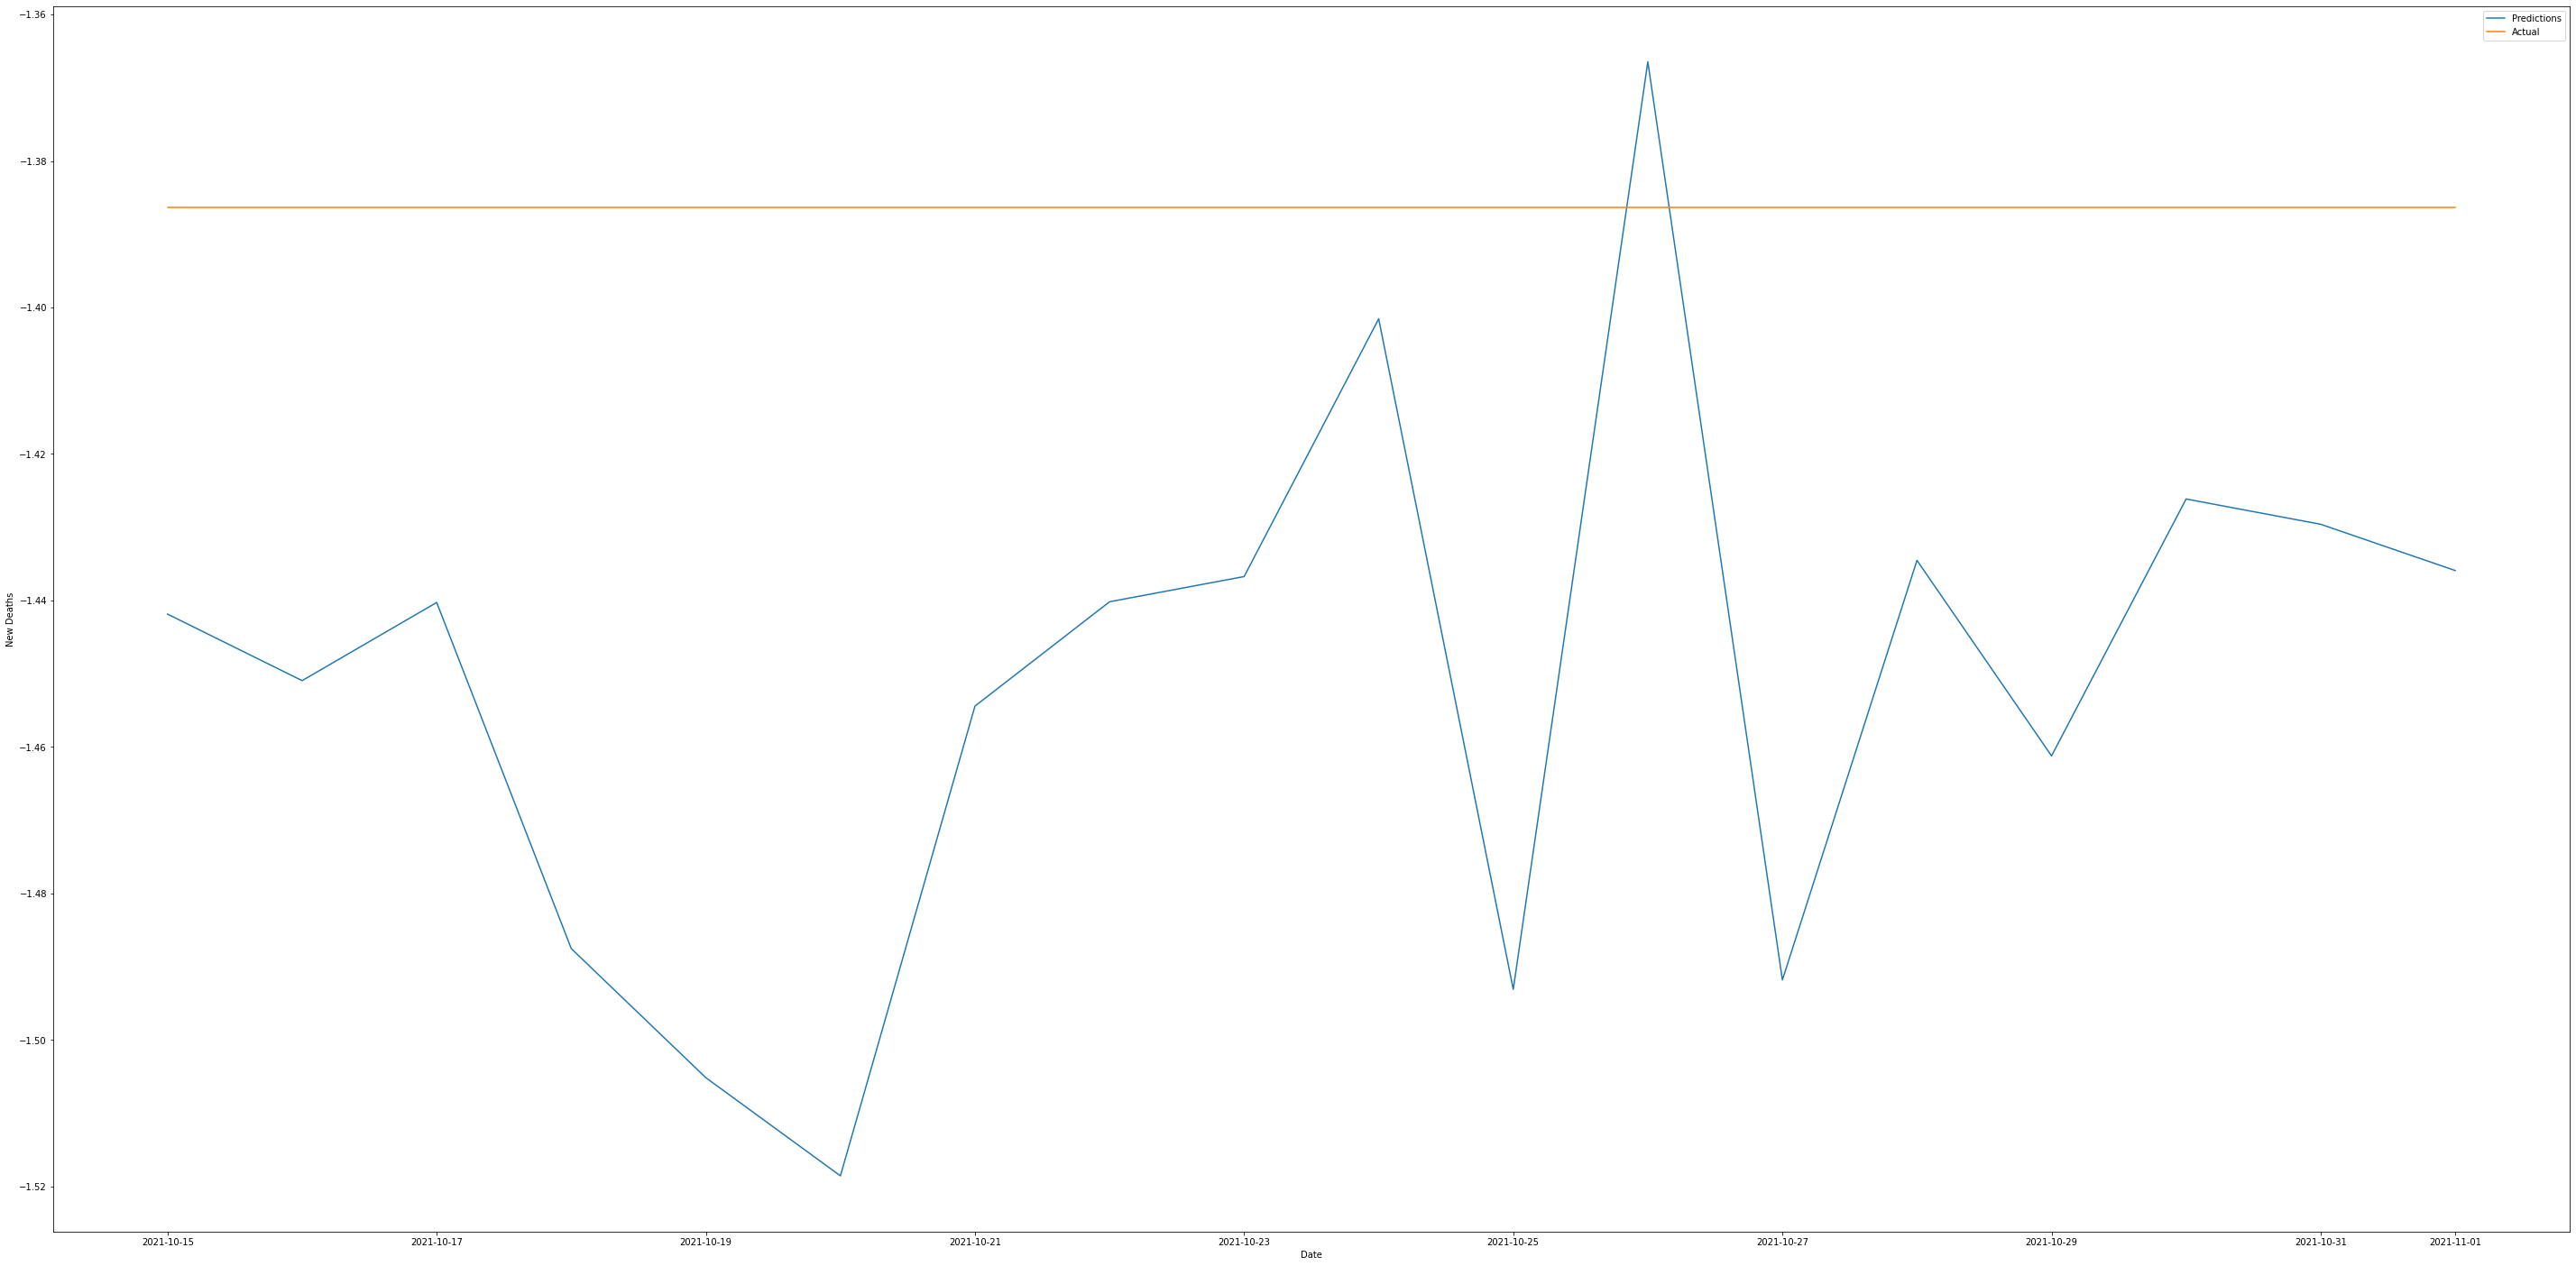

C: 1.0 - SVR Score: 0.9989035911299566


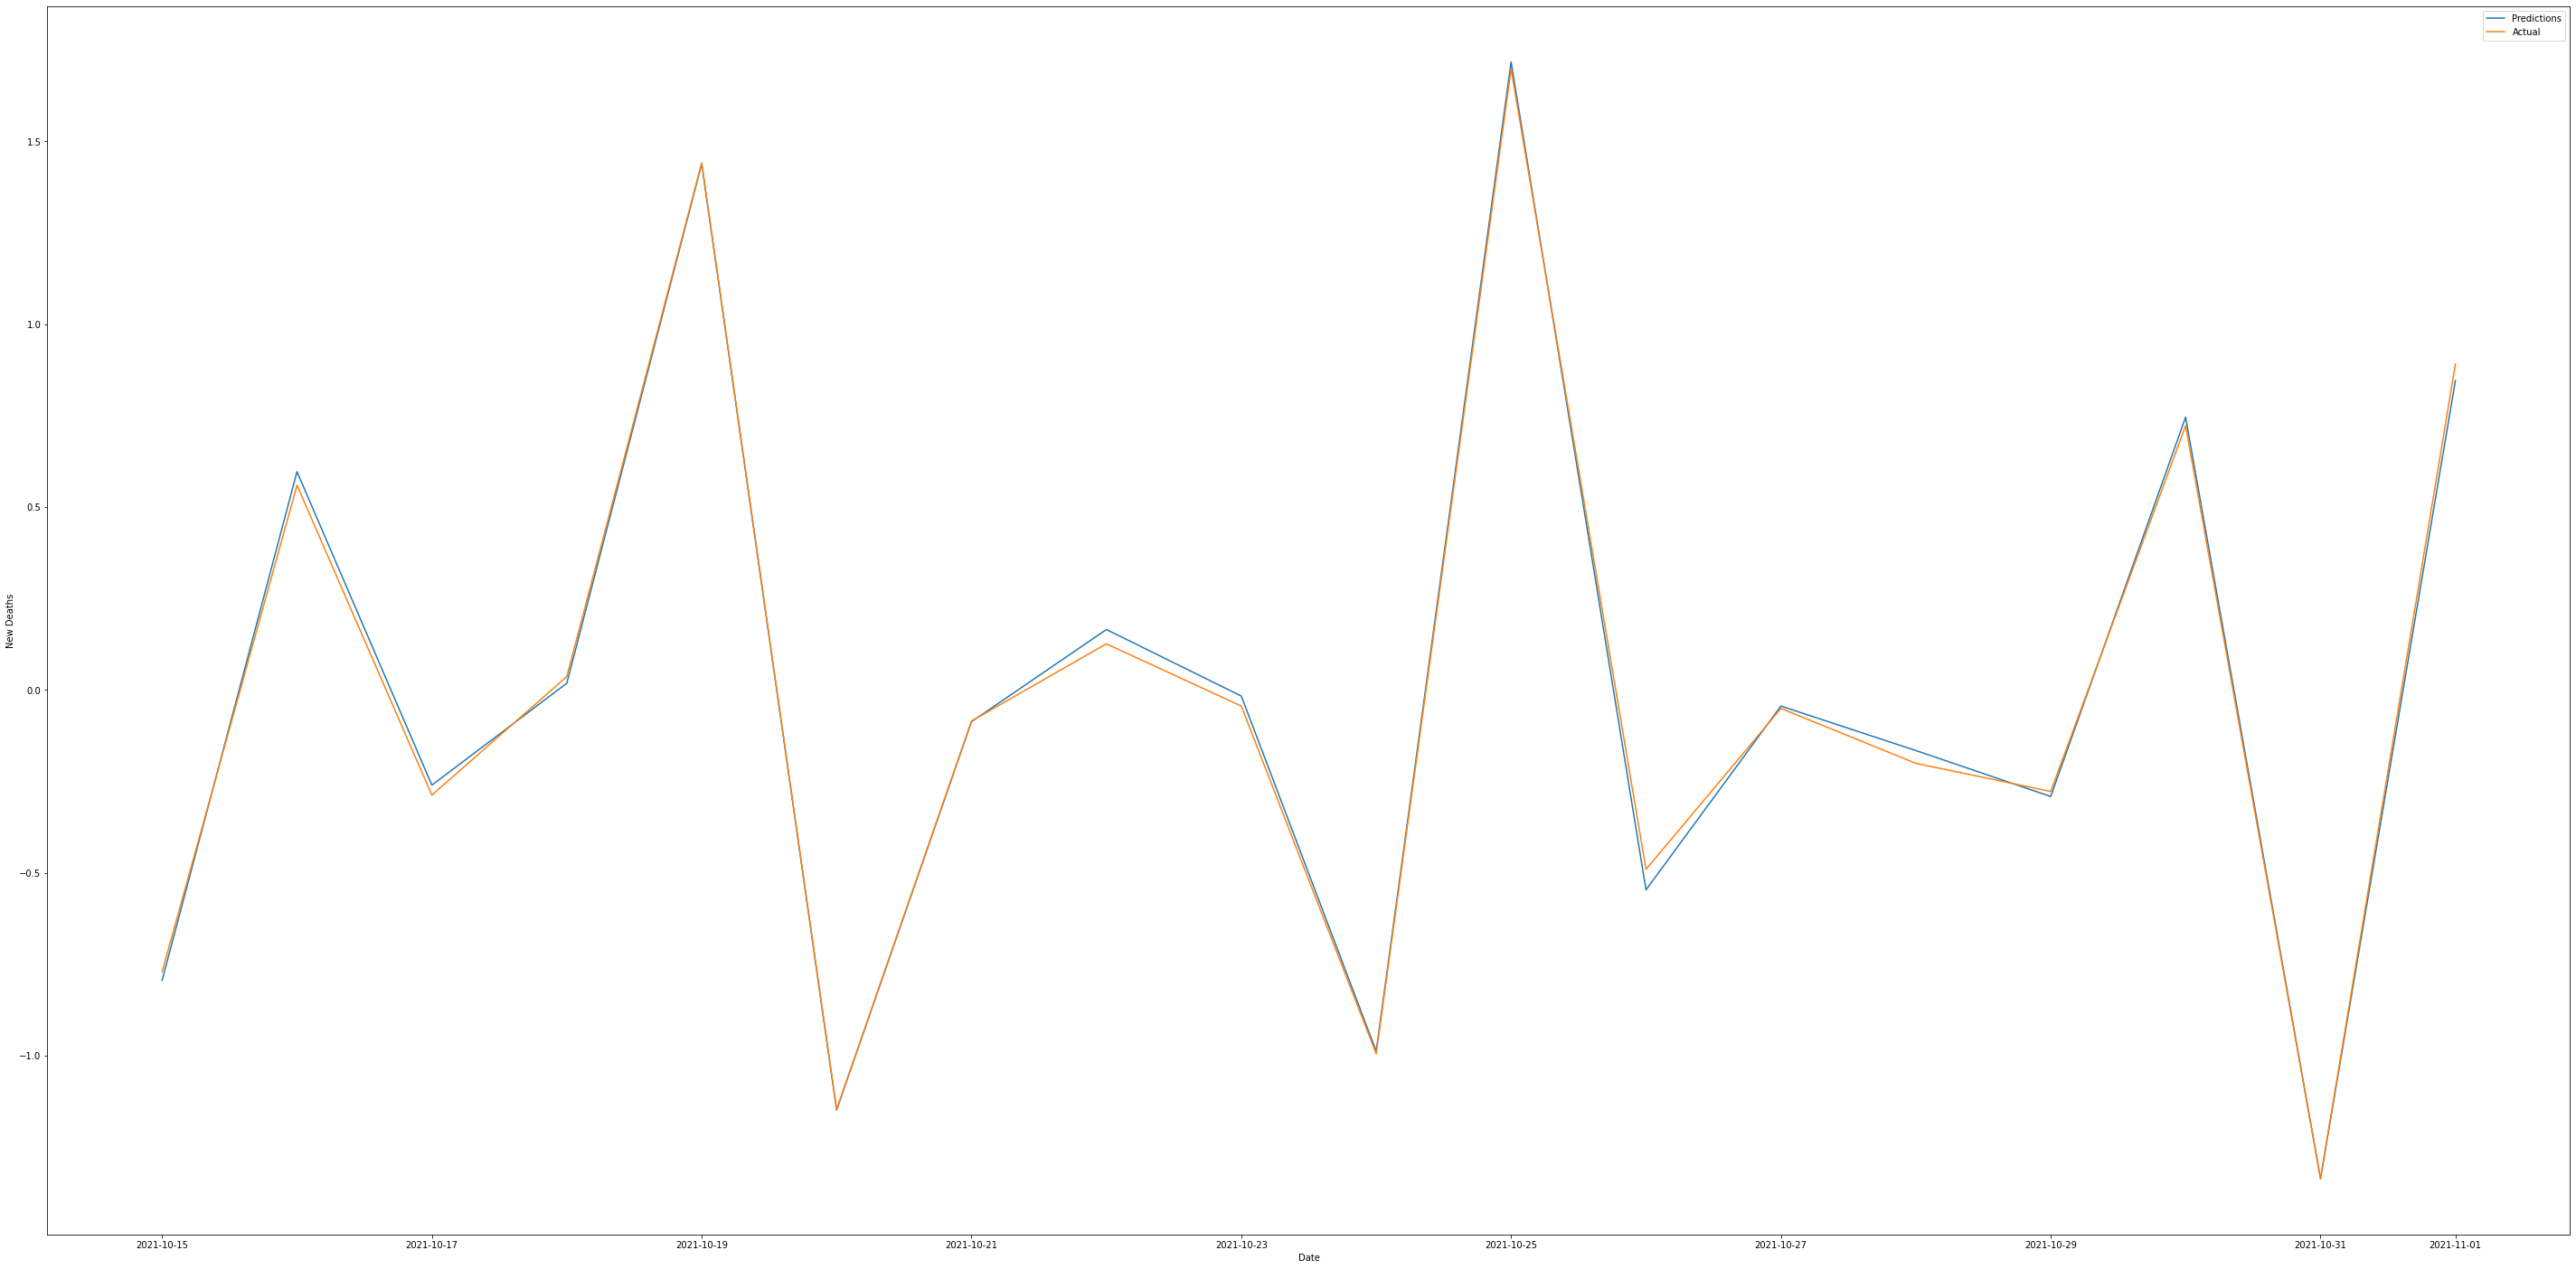

C: 1.0 - SVR Score: 0.9982327923357494


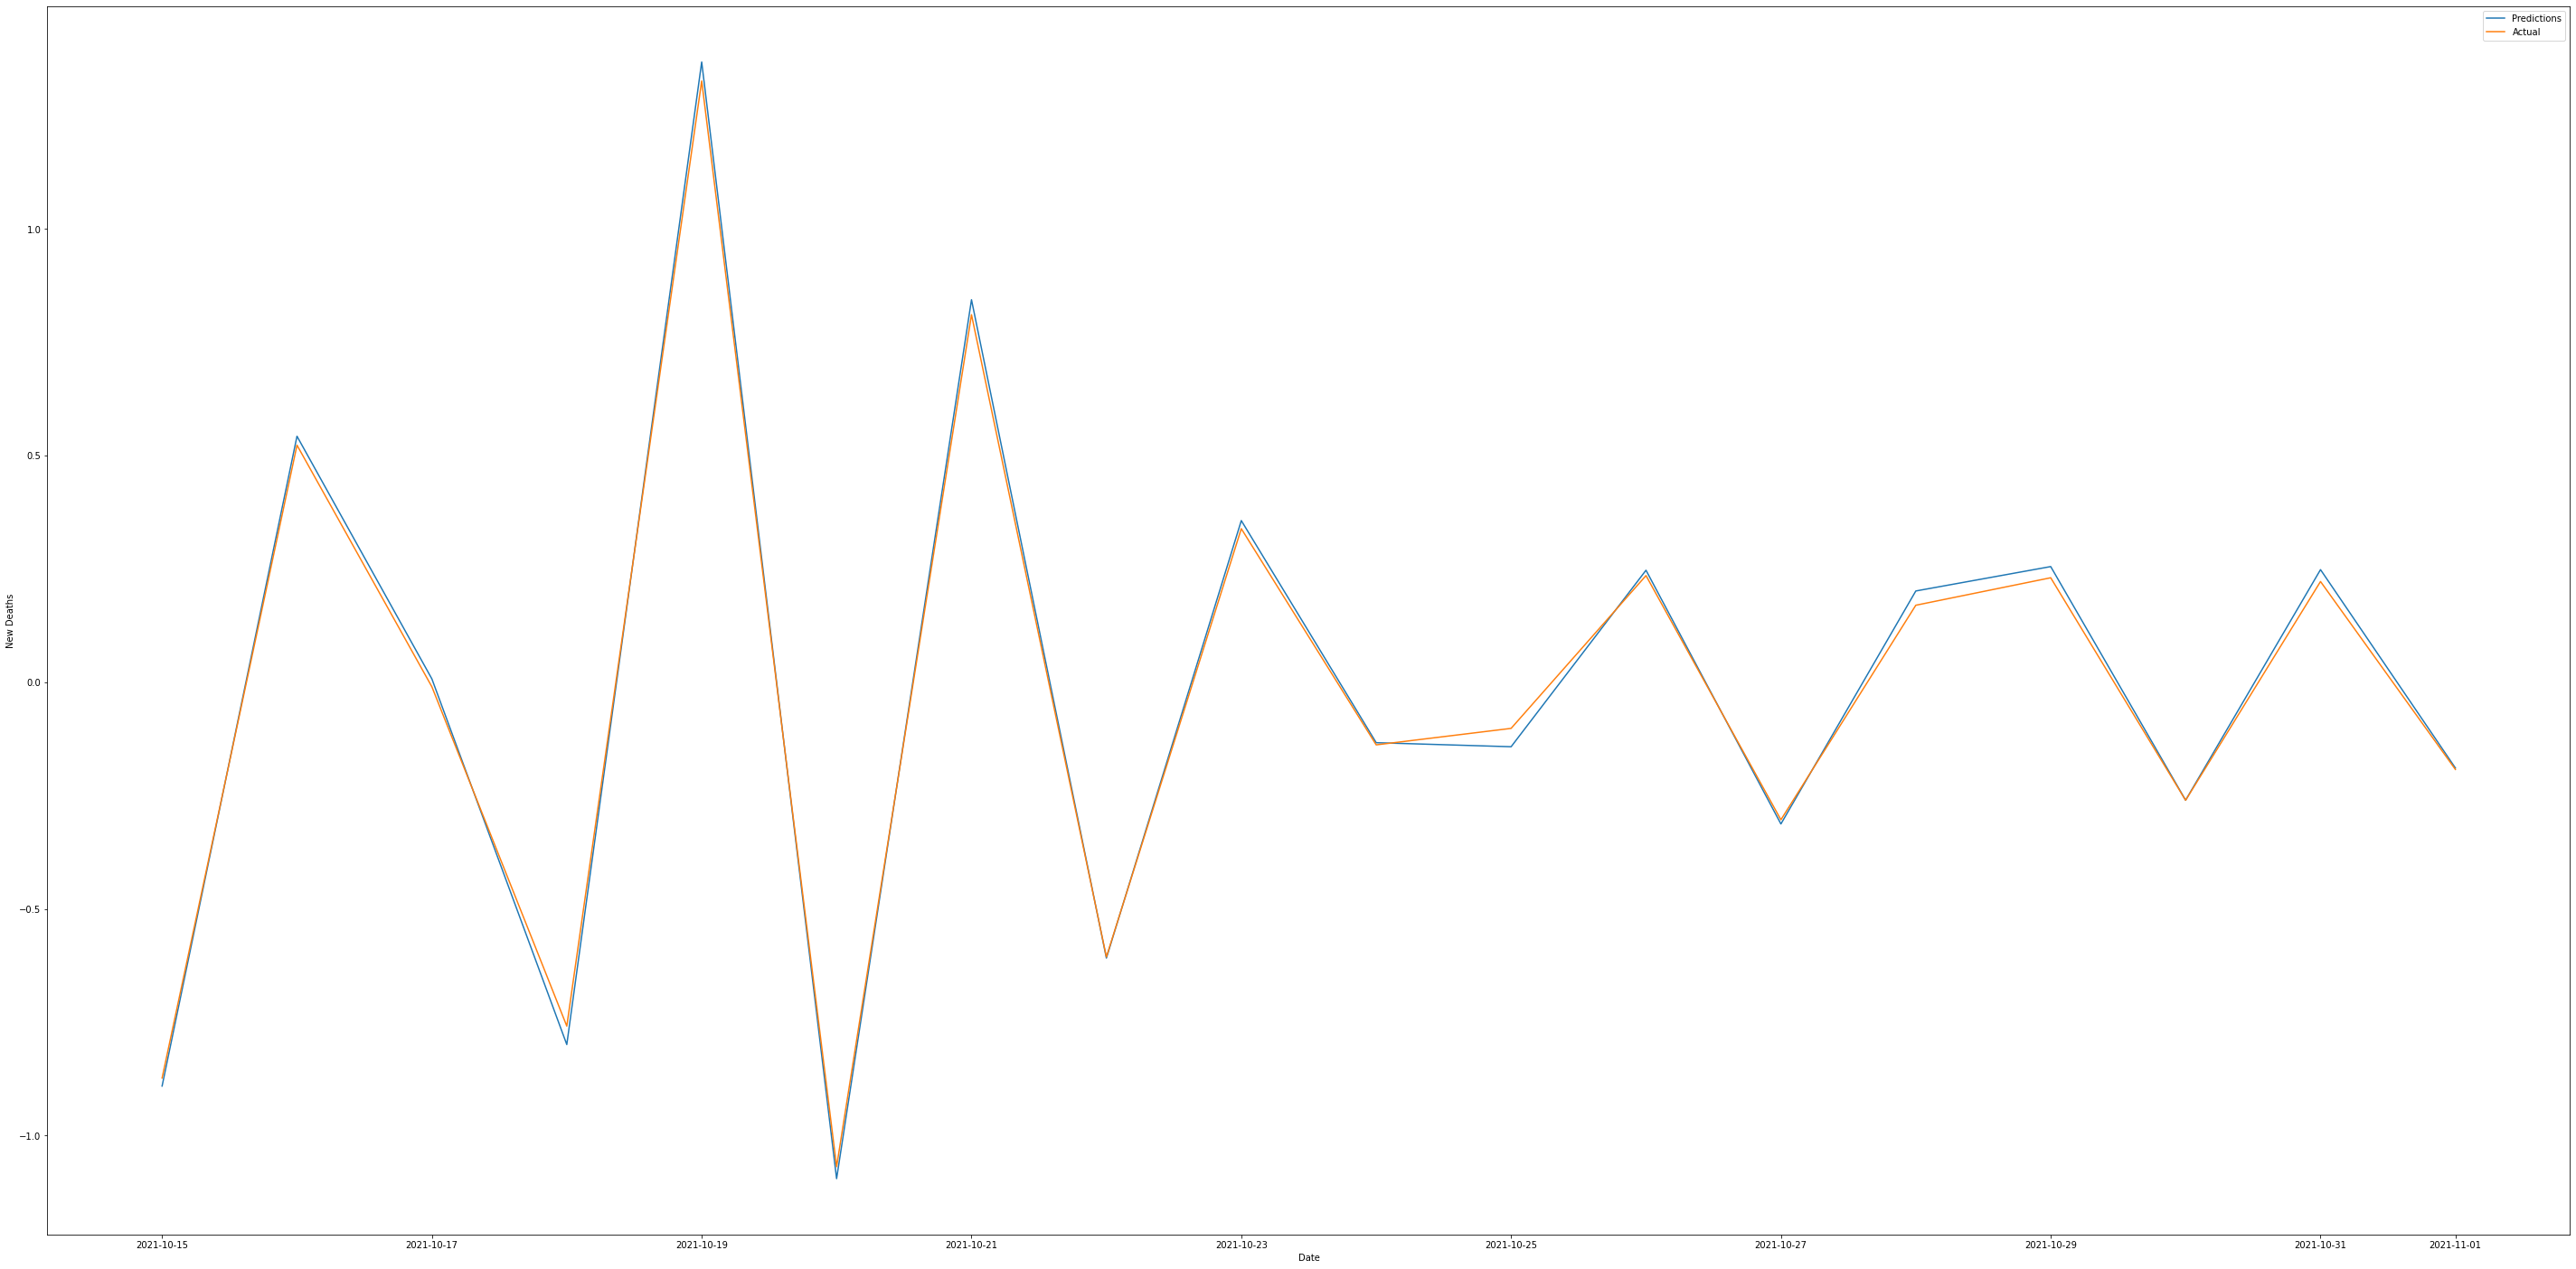

C: 1.0 - SVR Score: 0.0


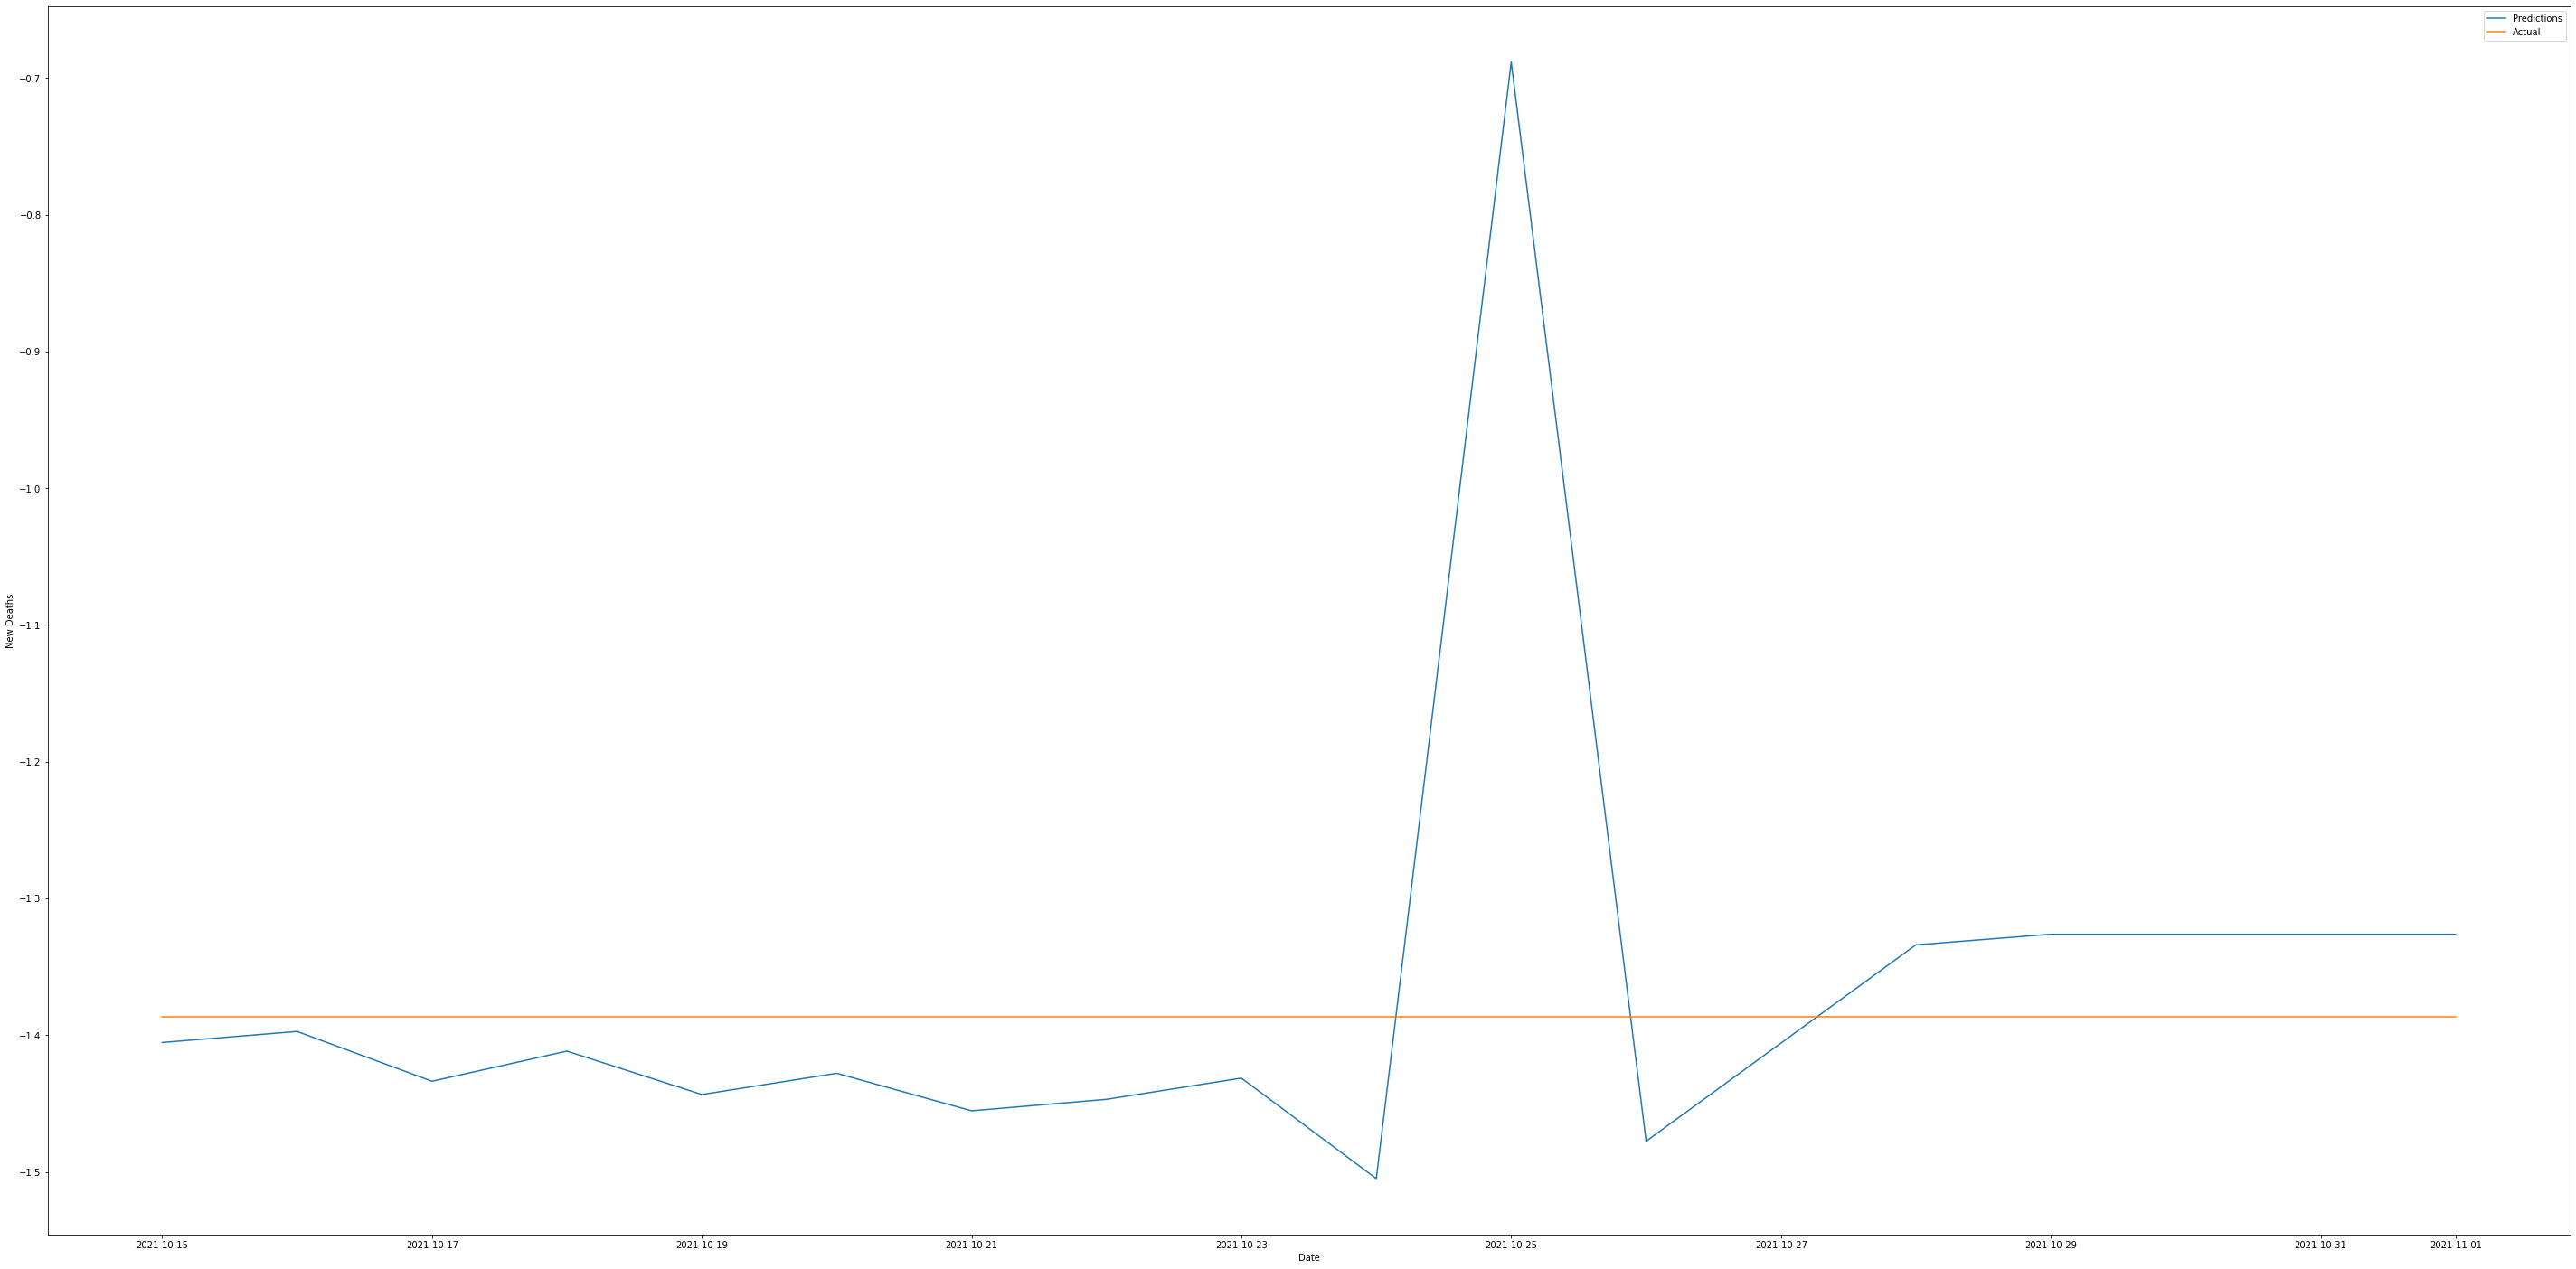

C: 1.0 - SVR Score: 0.0


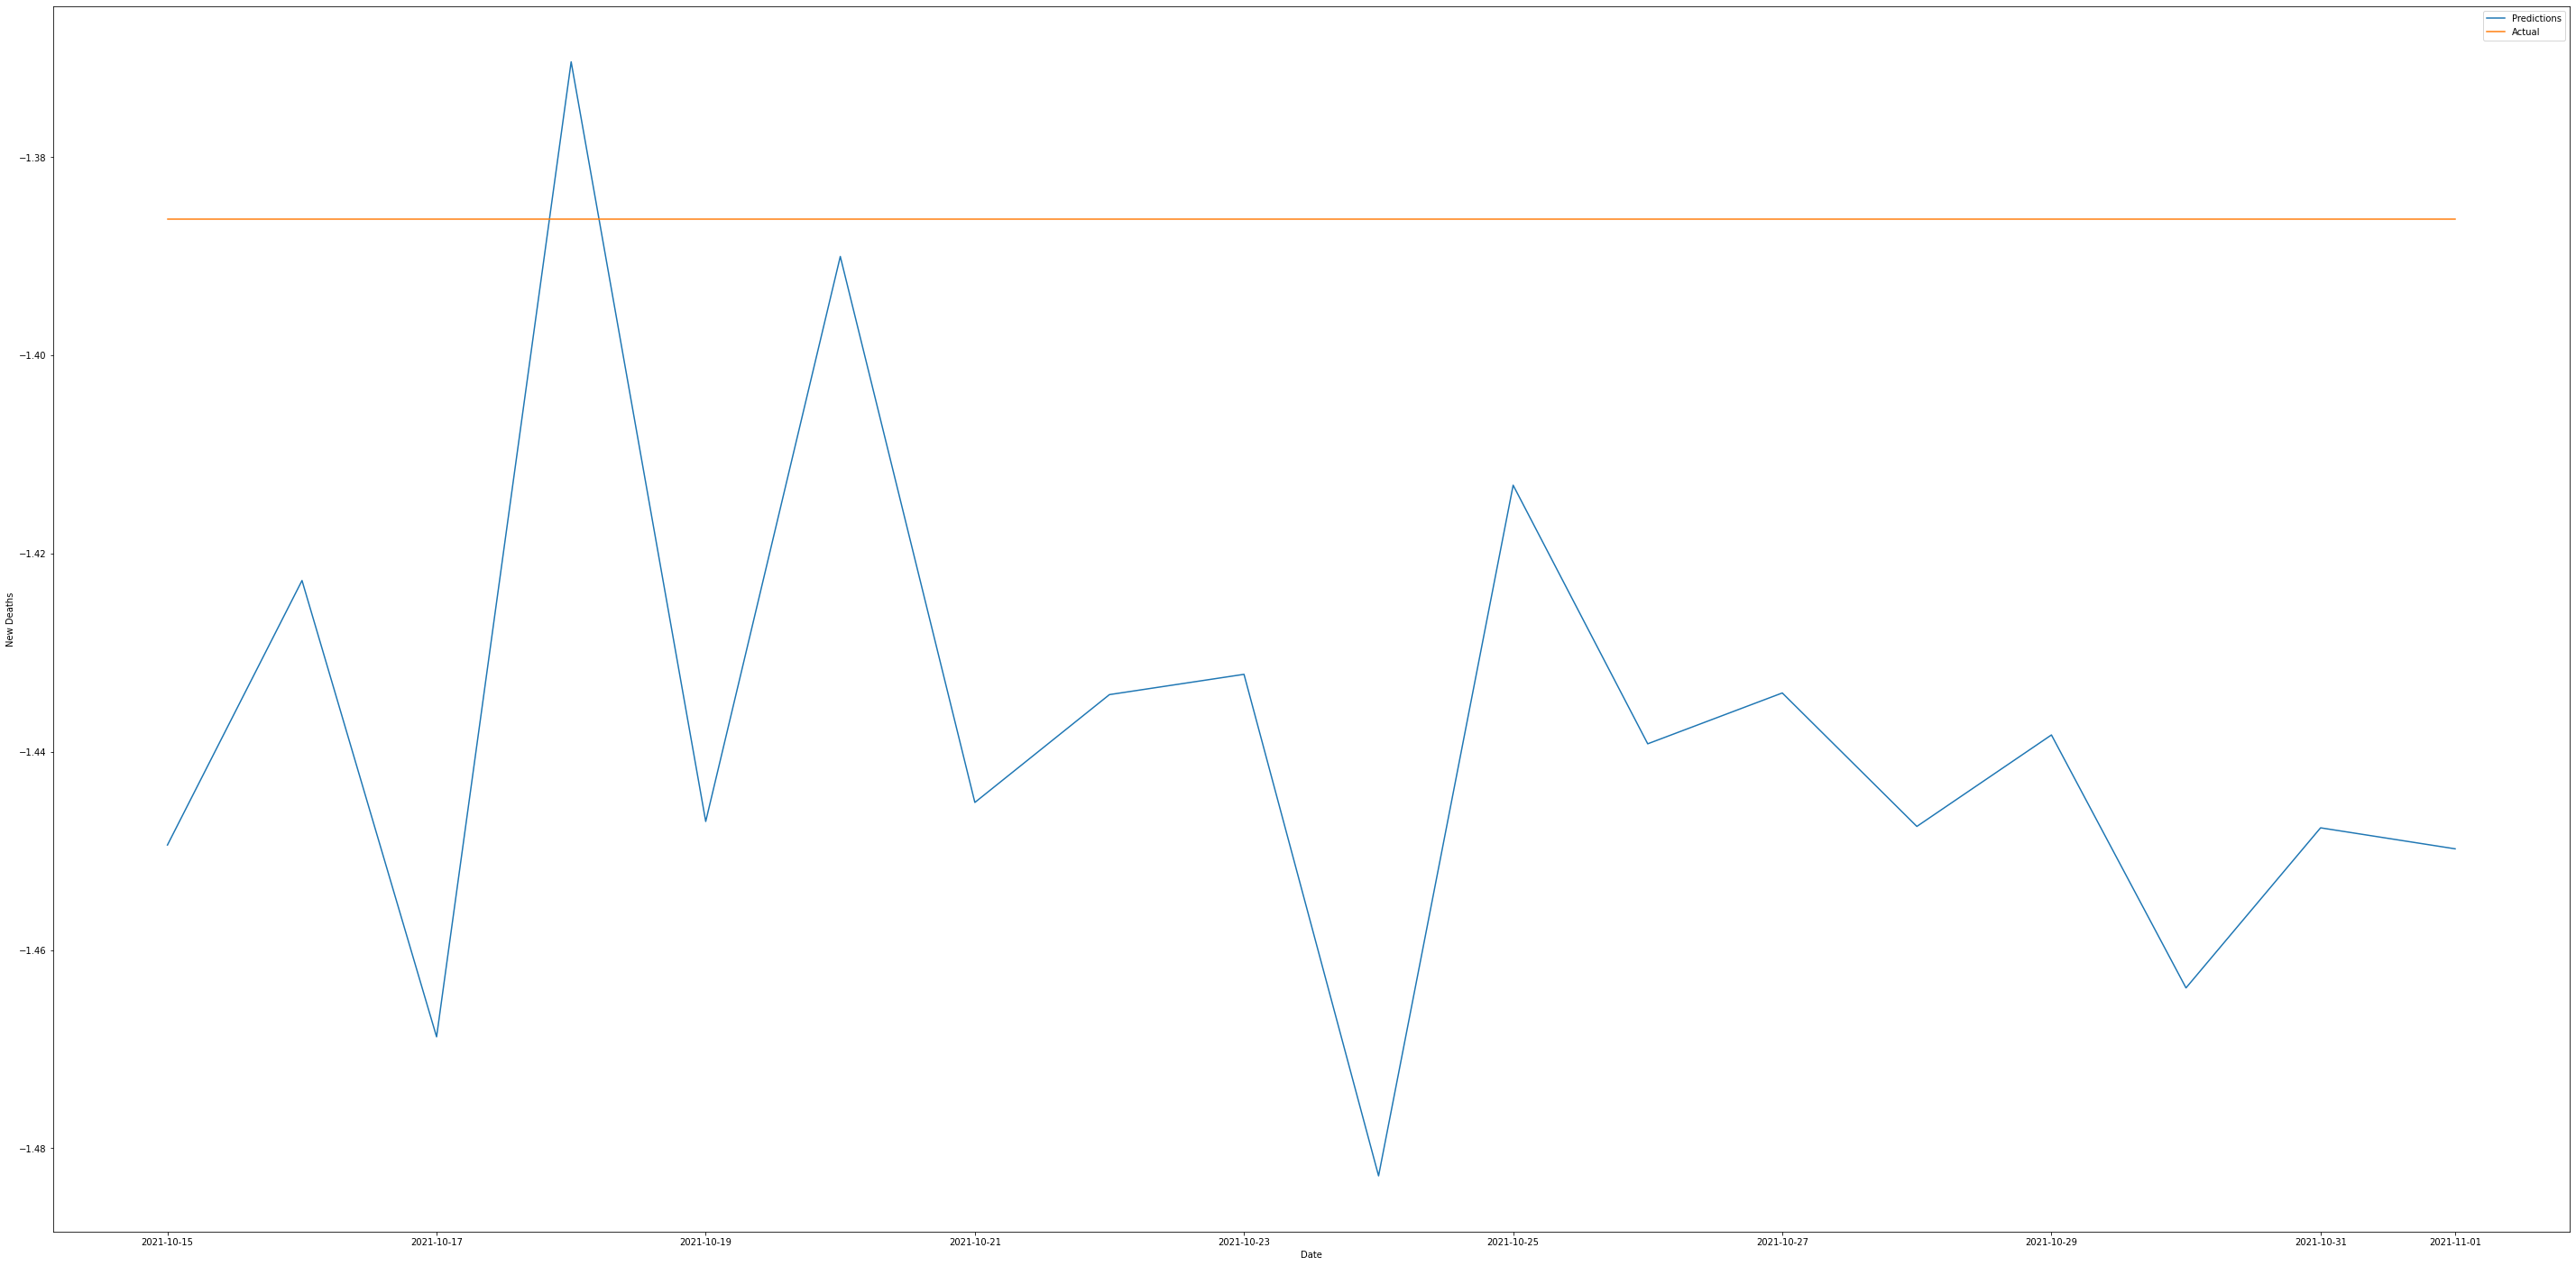

C: 1.0 - SVR Score: 0.9380609142939721


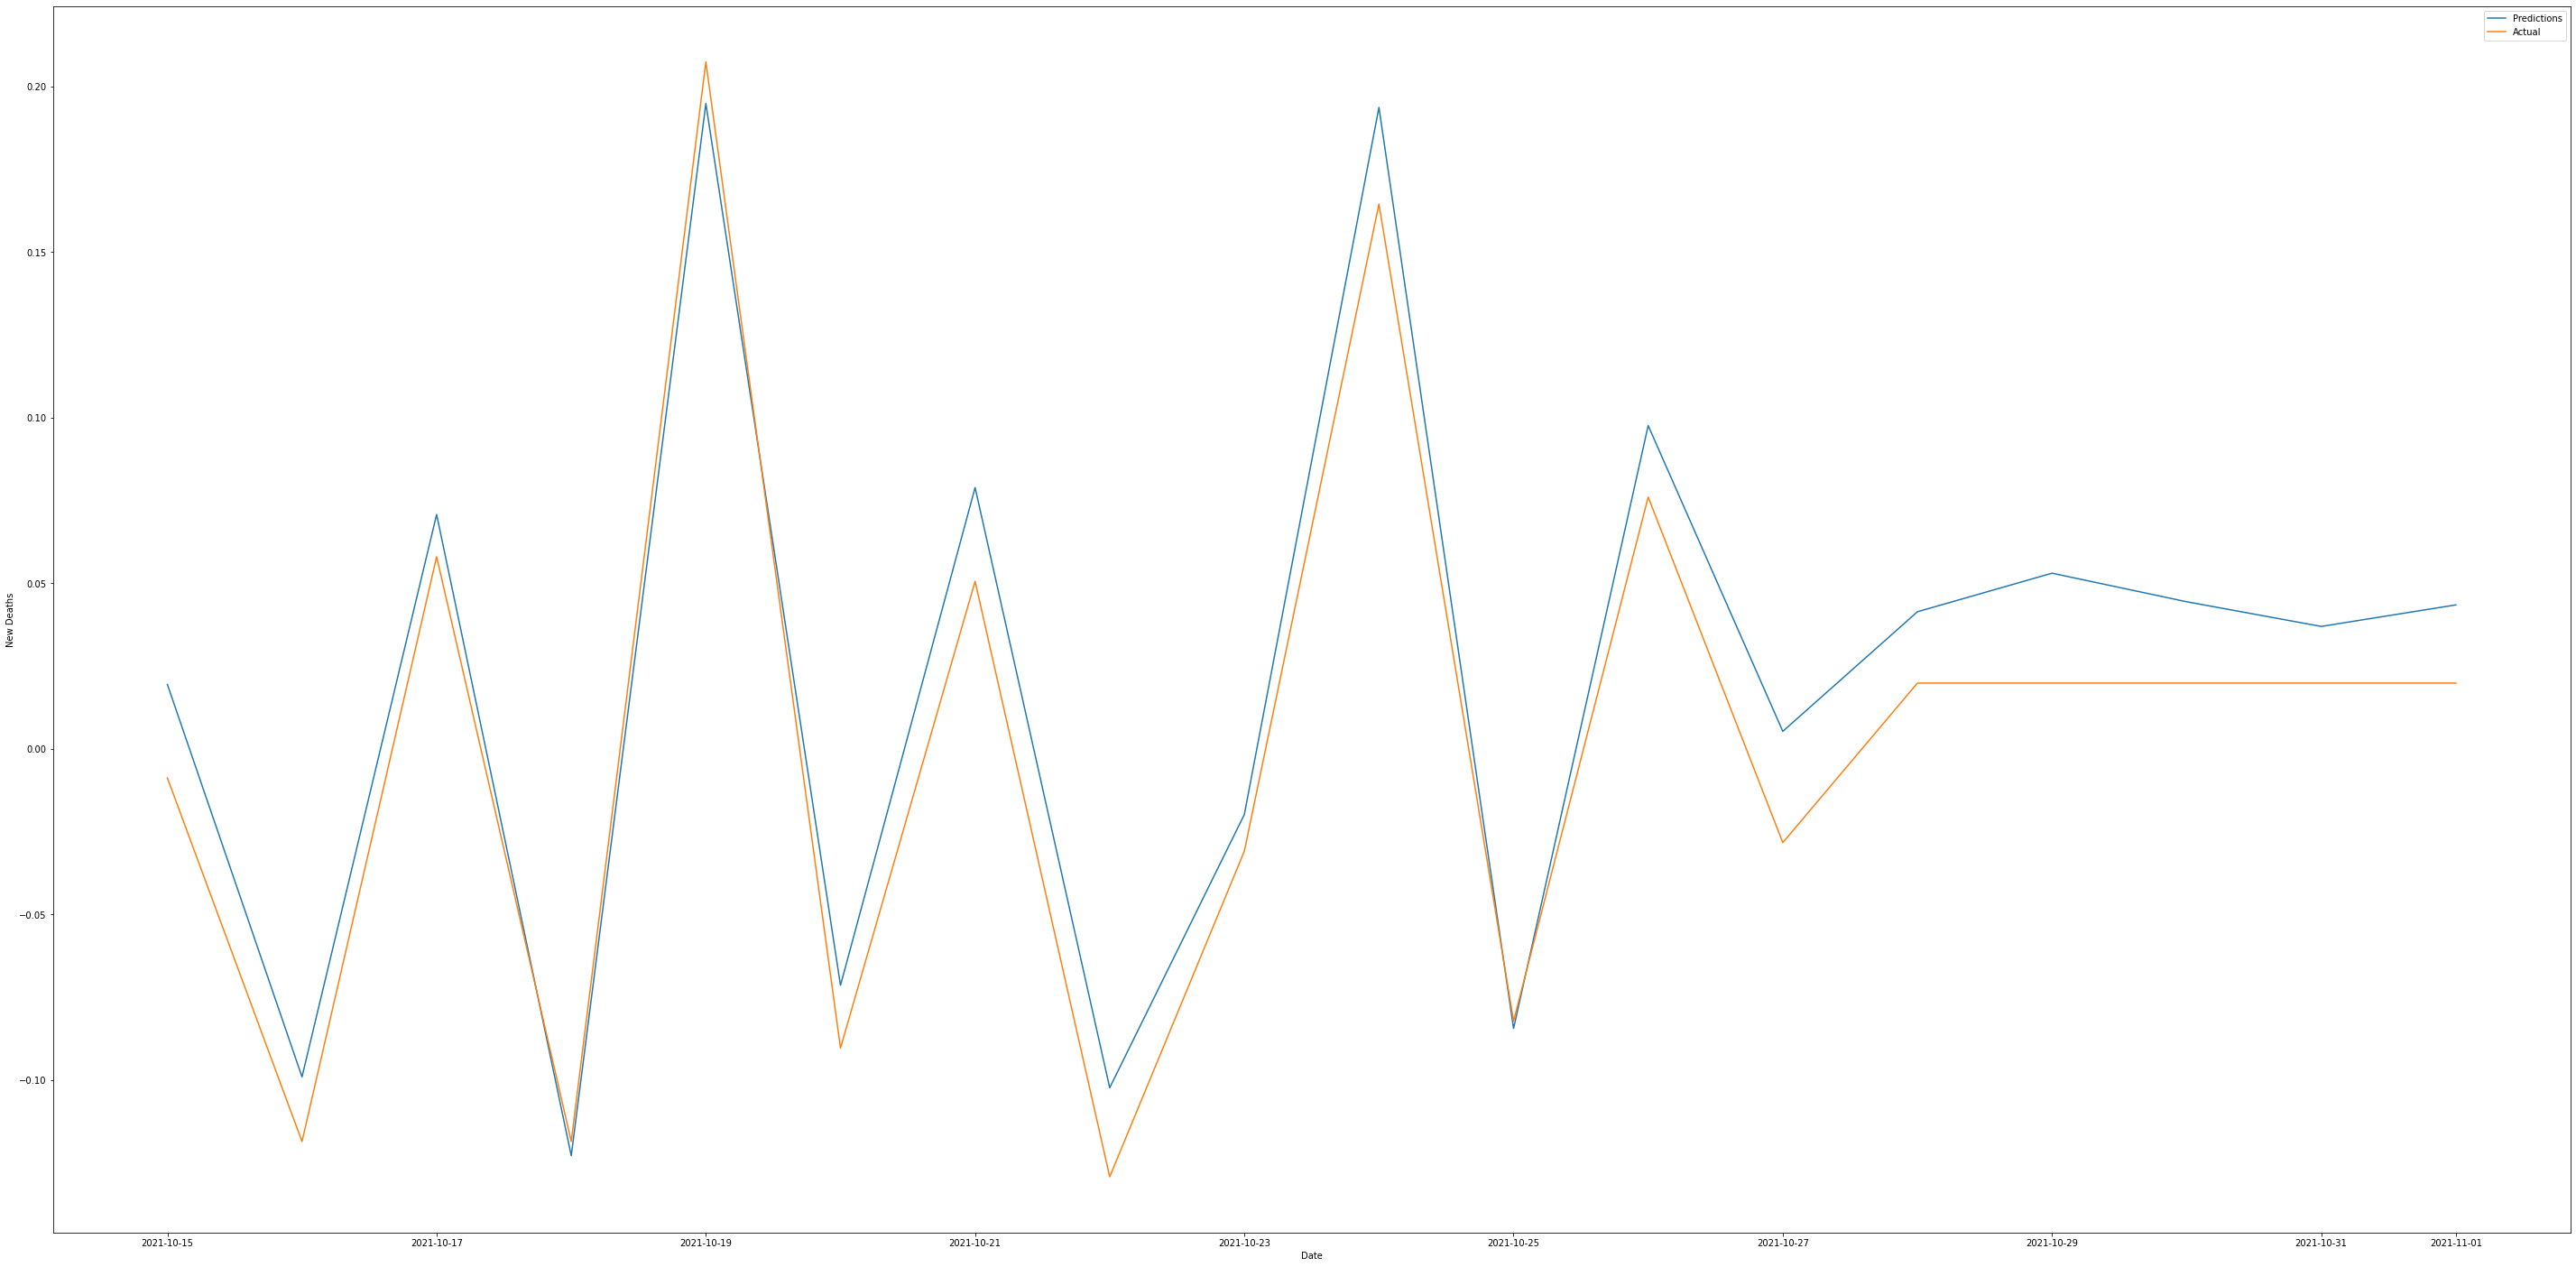

C: 1.0 - SVR Score: 0.9981517541112713


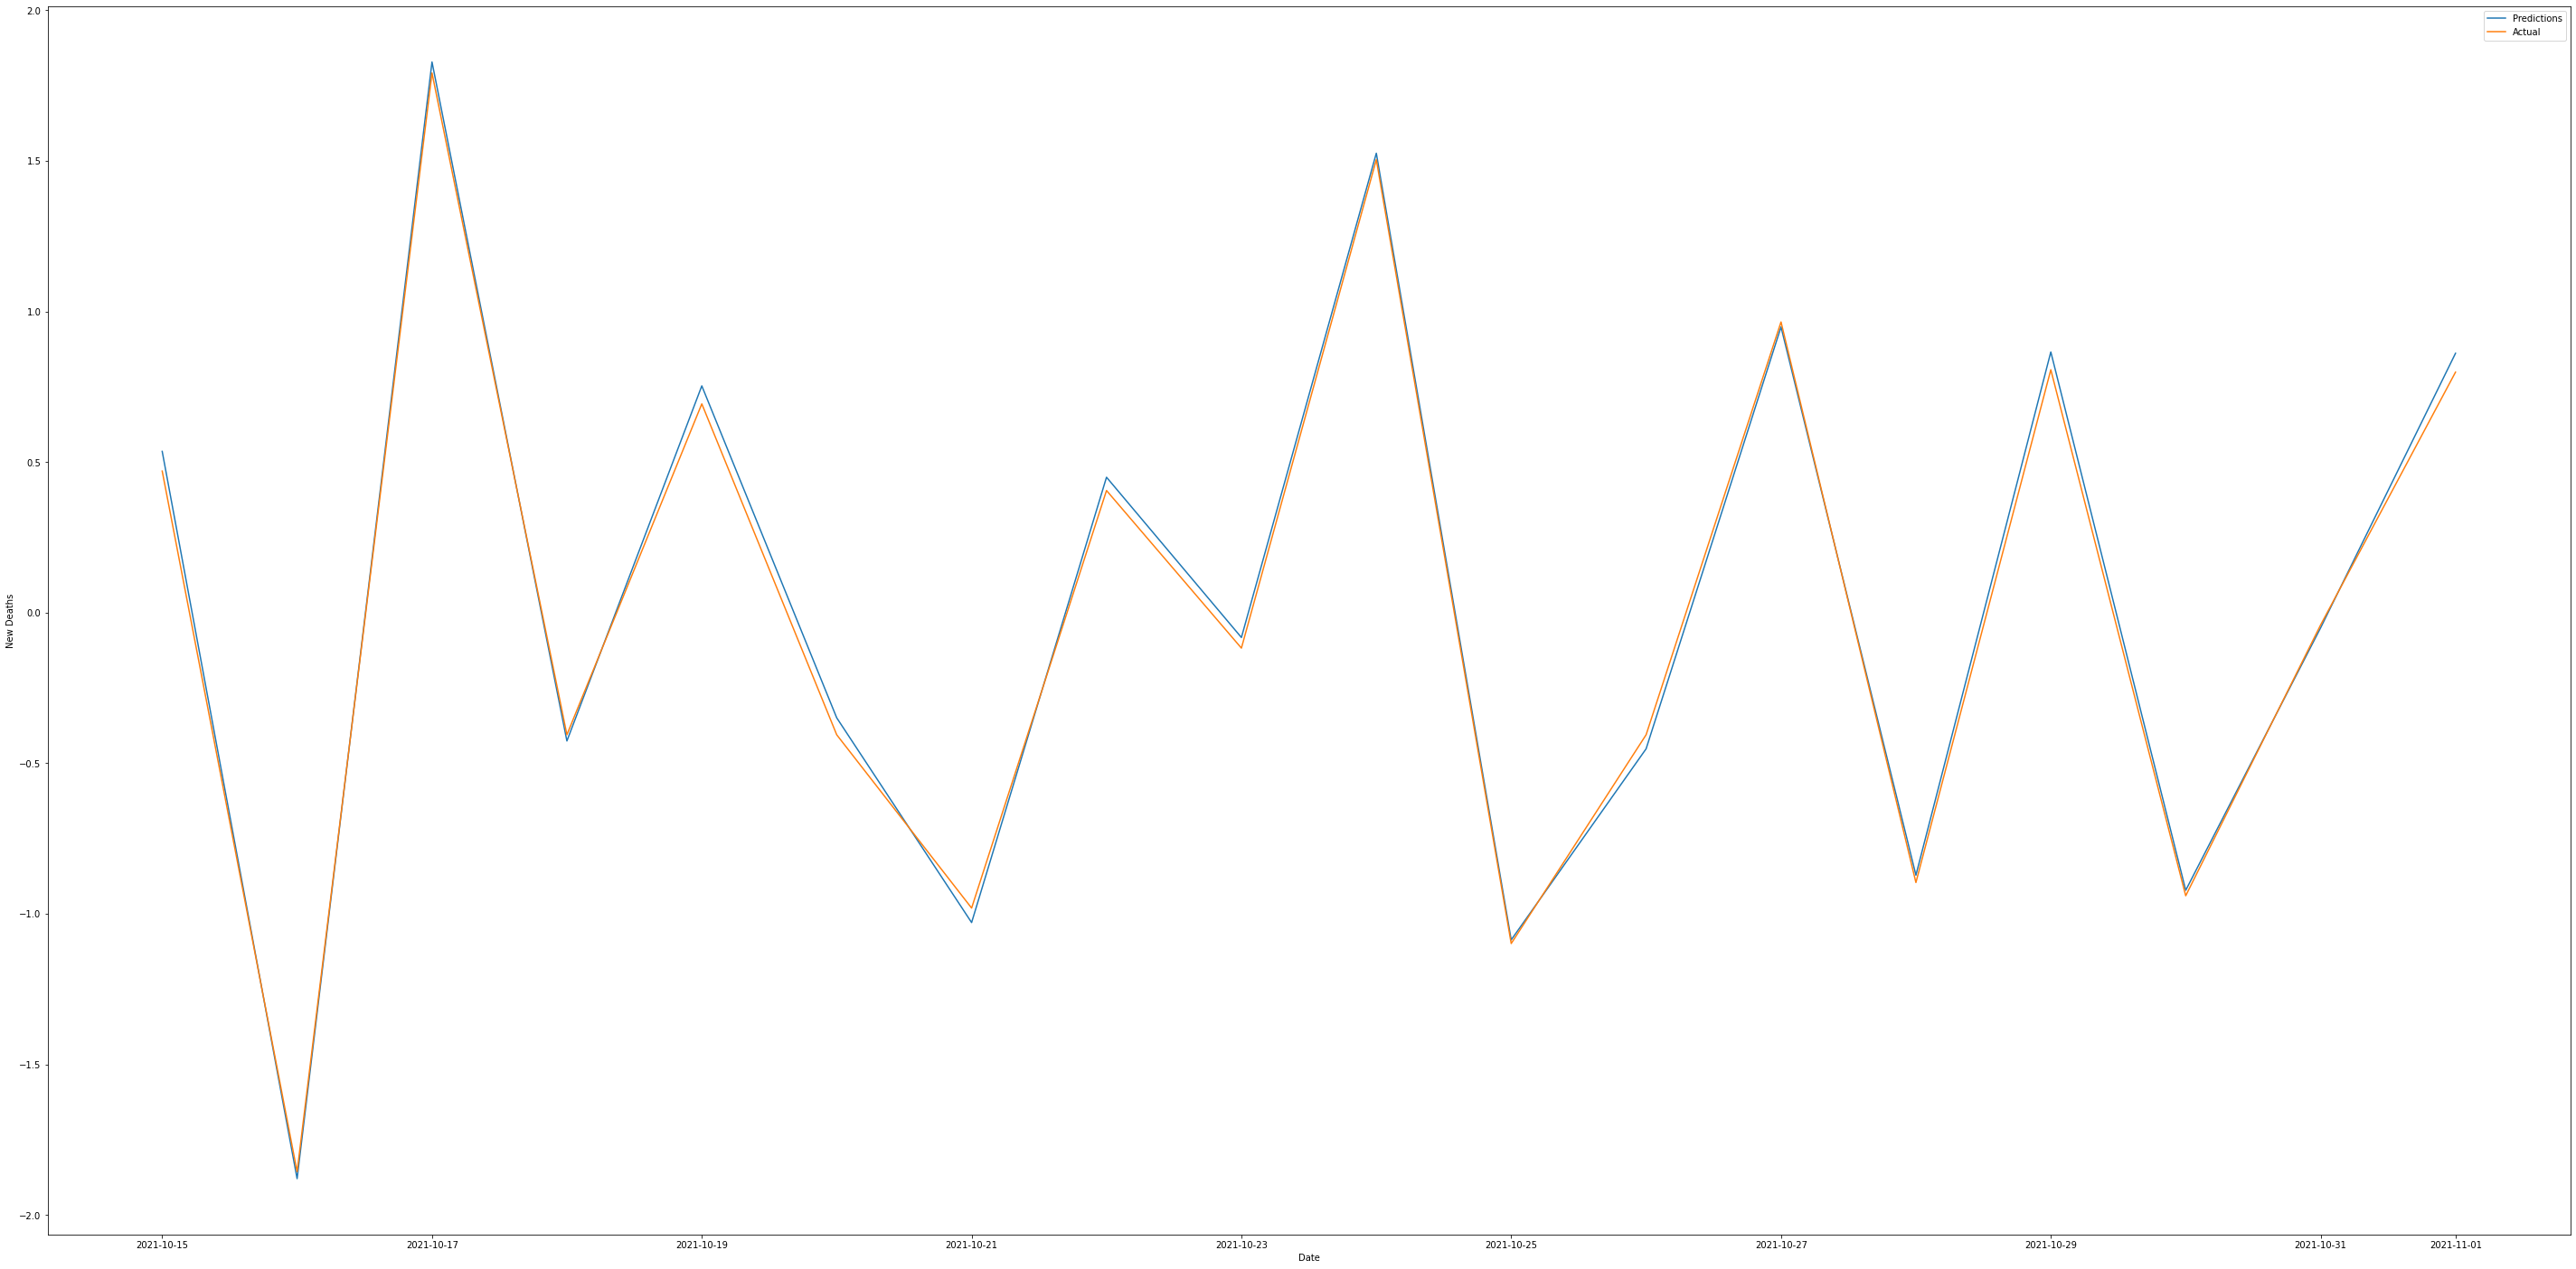

C: 1.0 - SVR Score: 0.9990978887400416


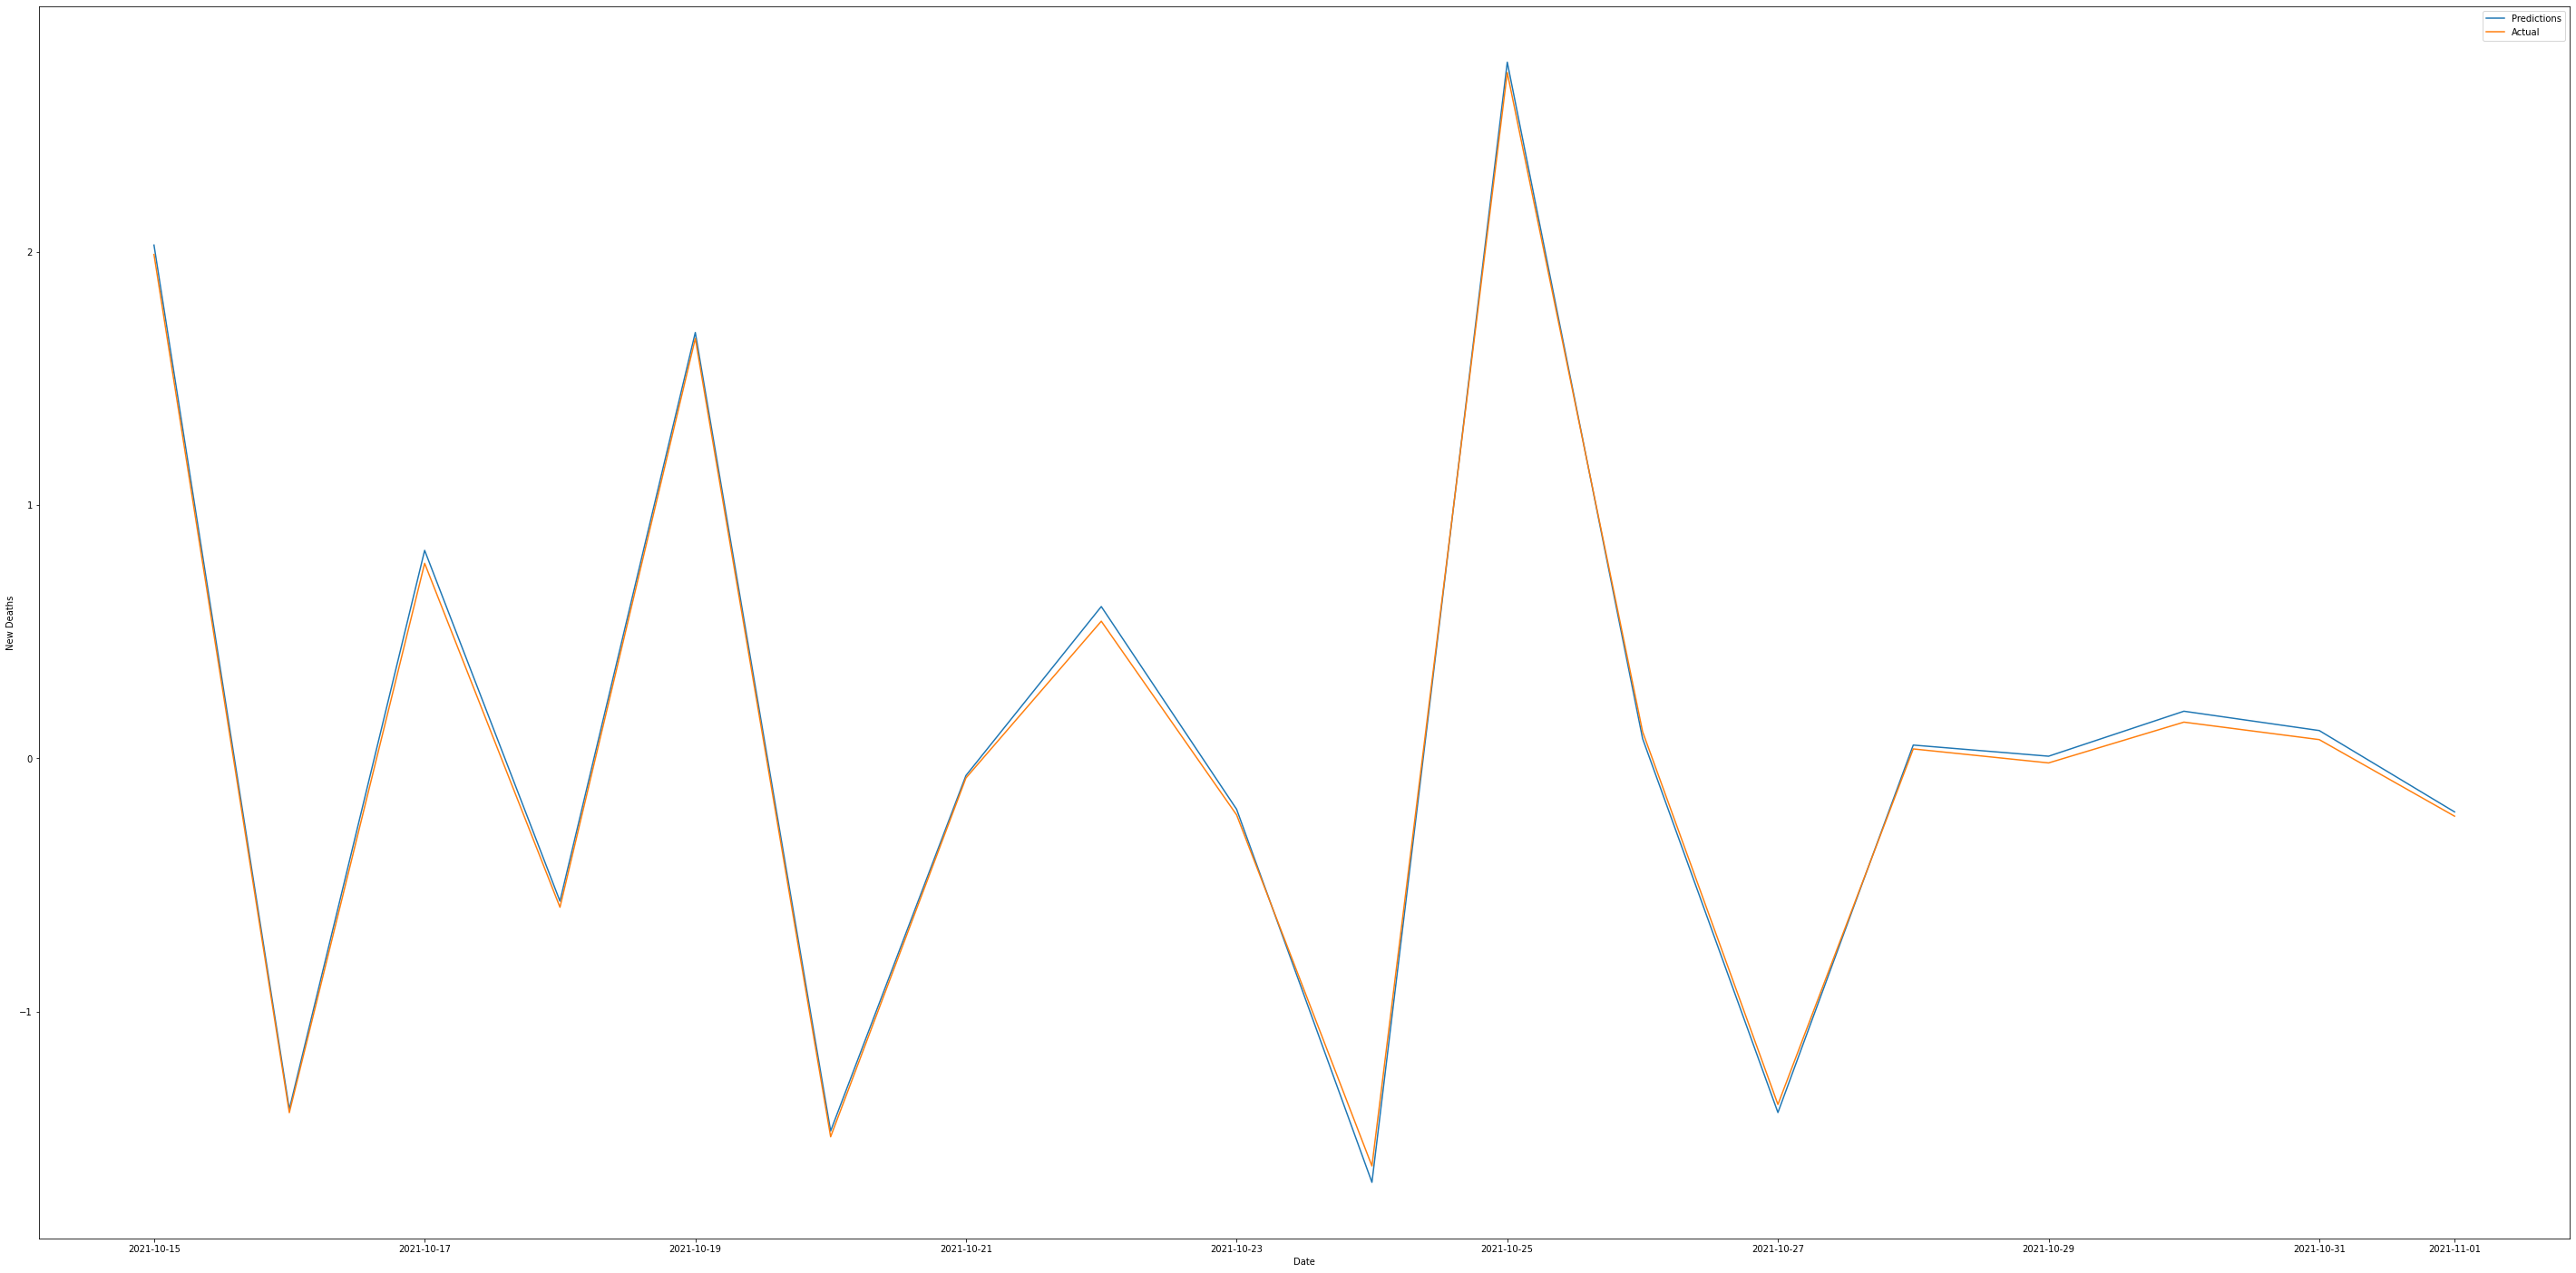

C: 1.0 - SVR Score: 0.996388203098036


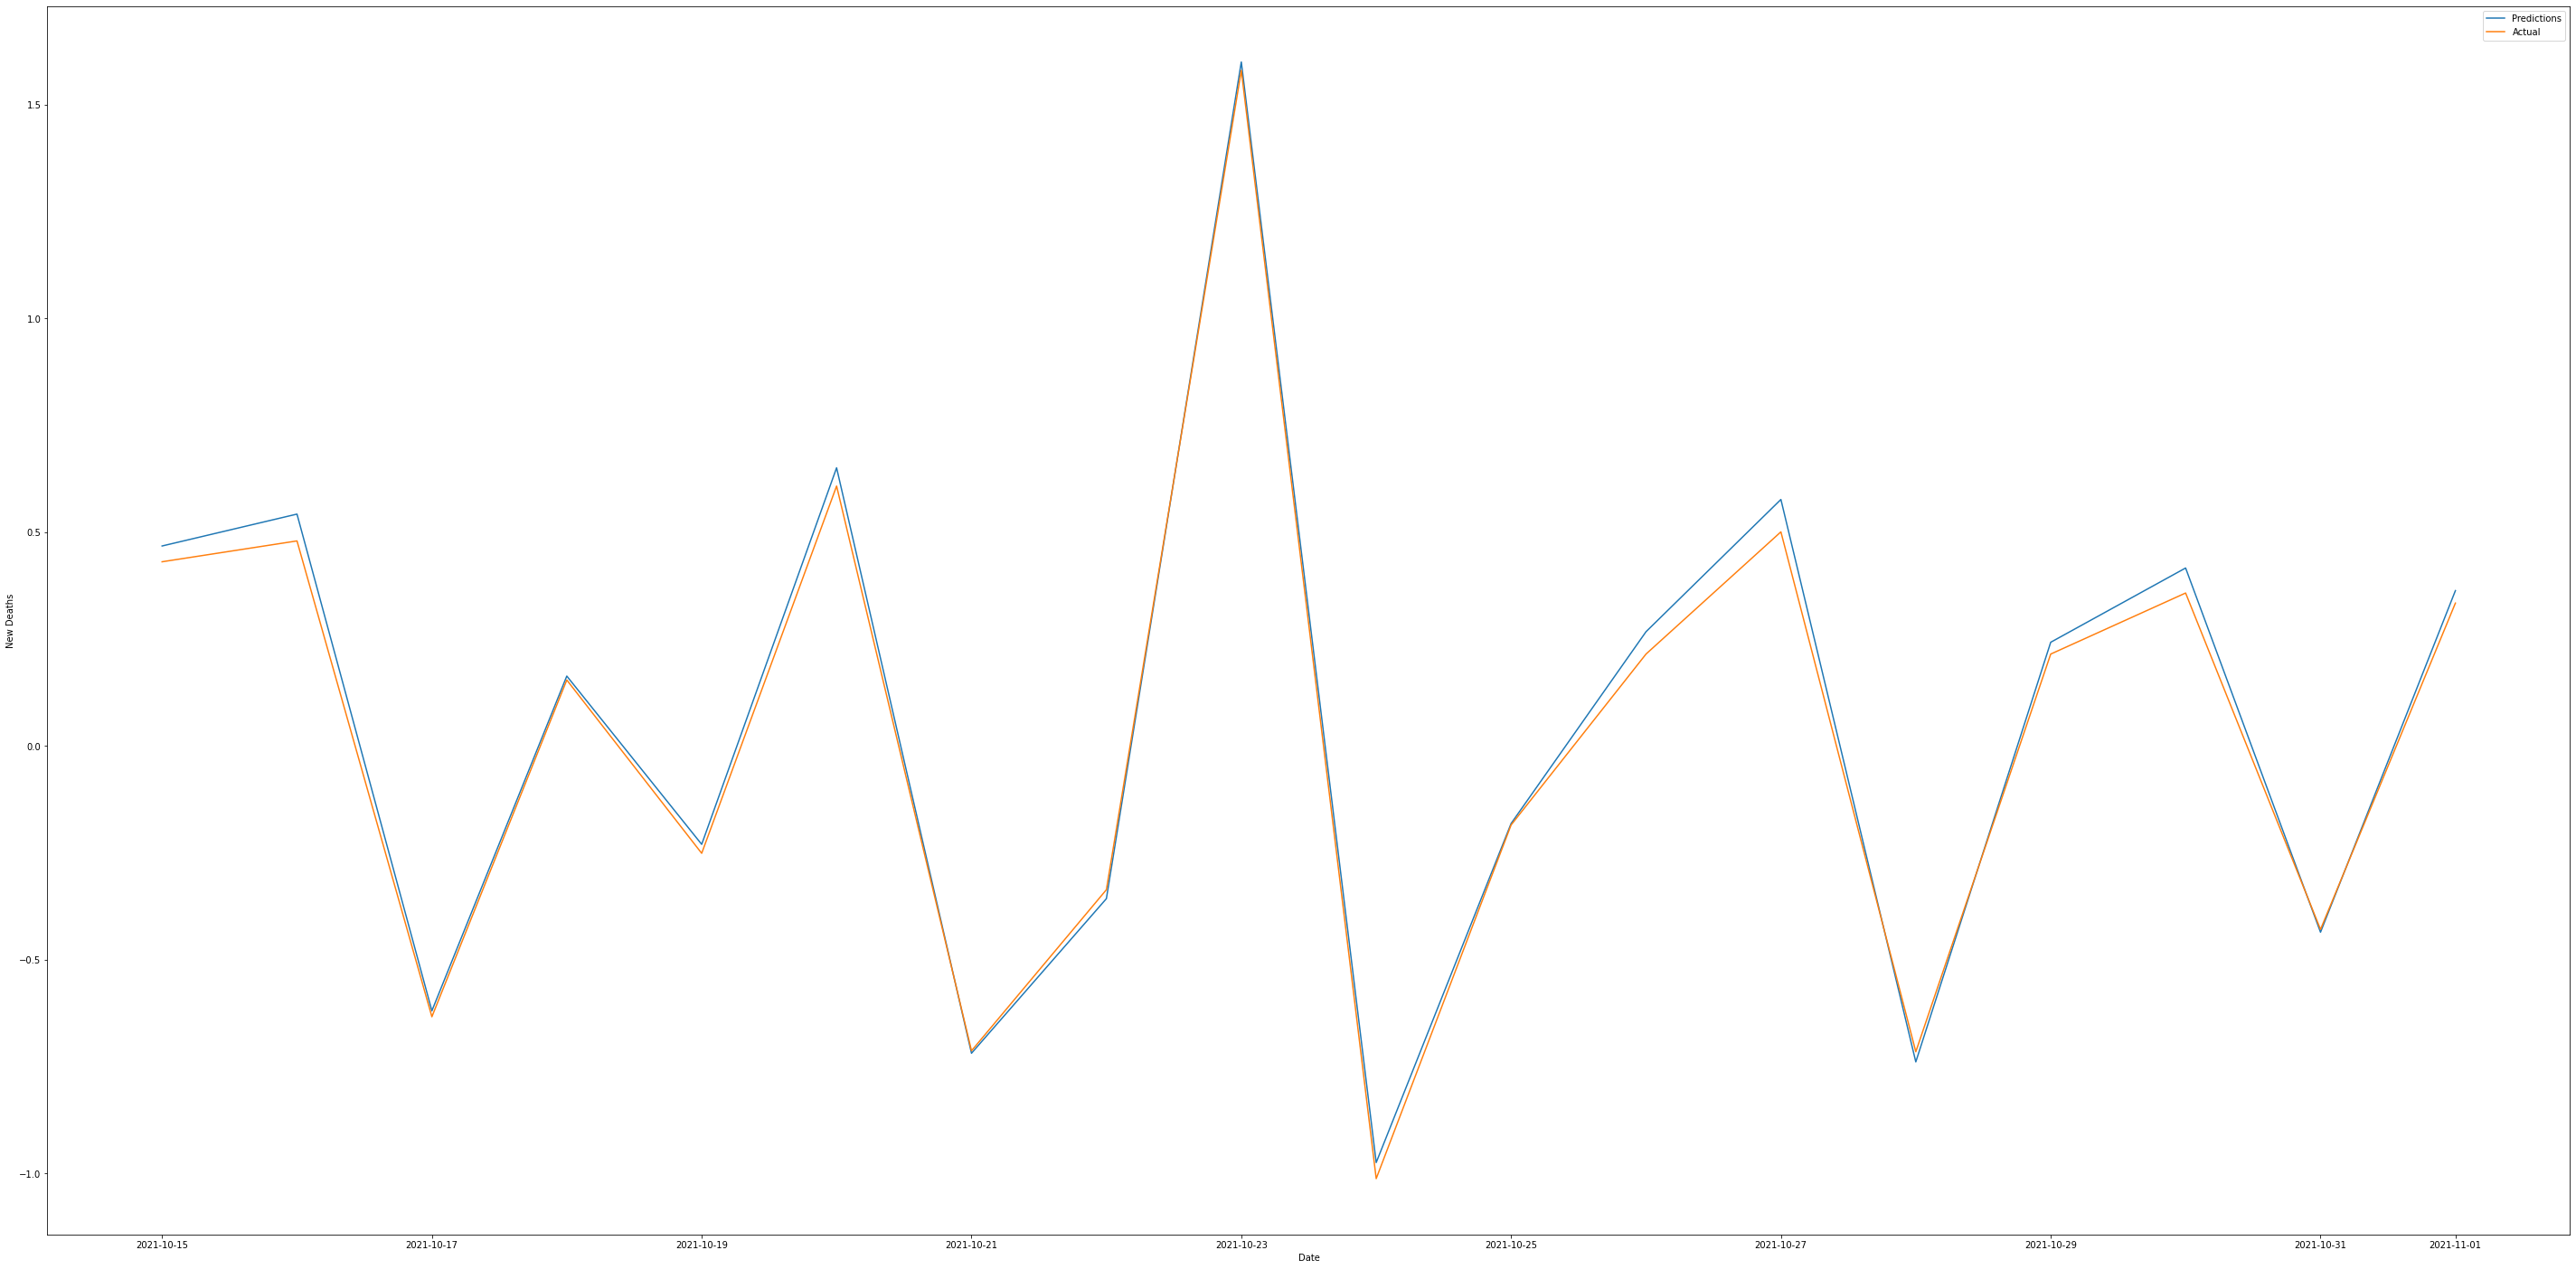

C: 1.0 - SVR Score: -1.0688694656239392e+29


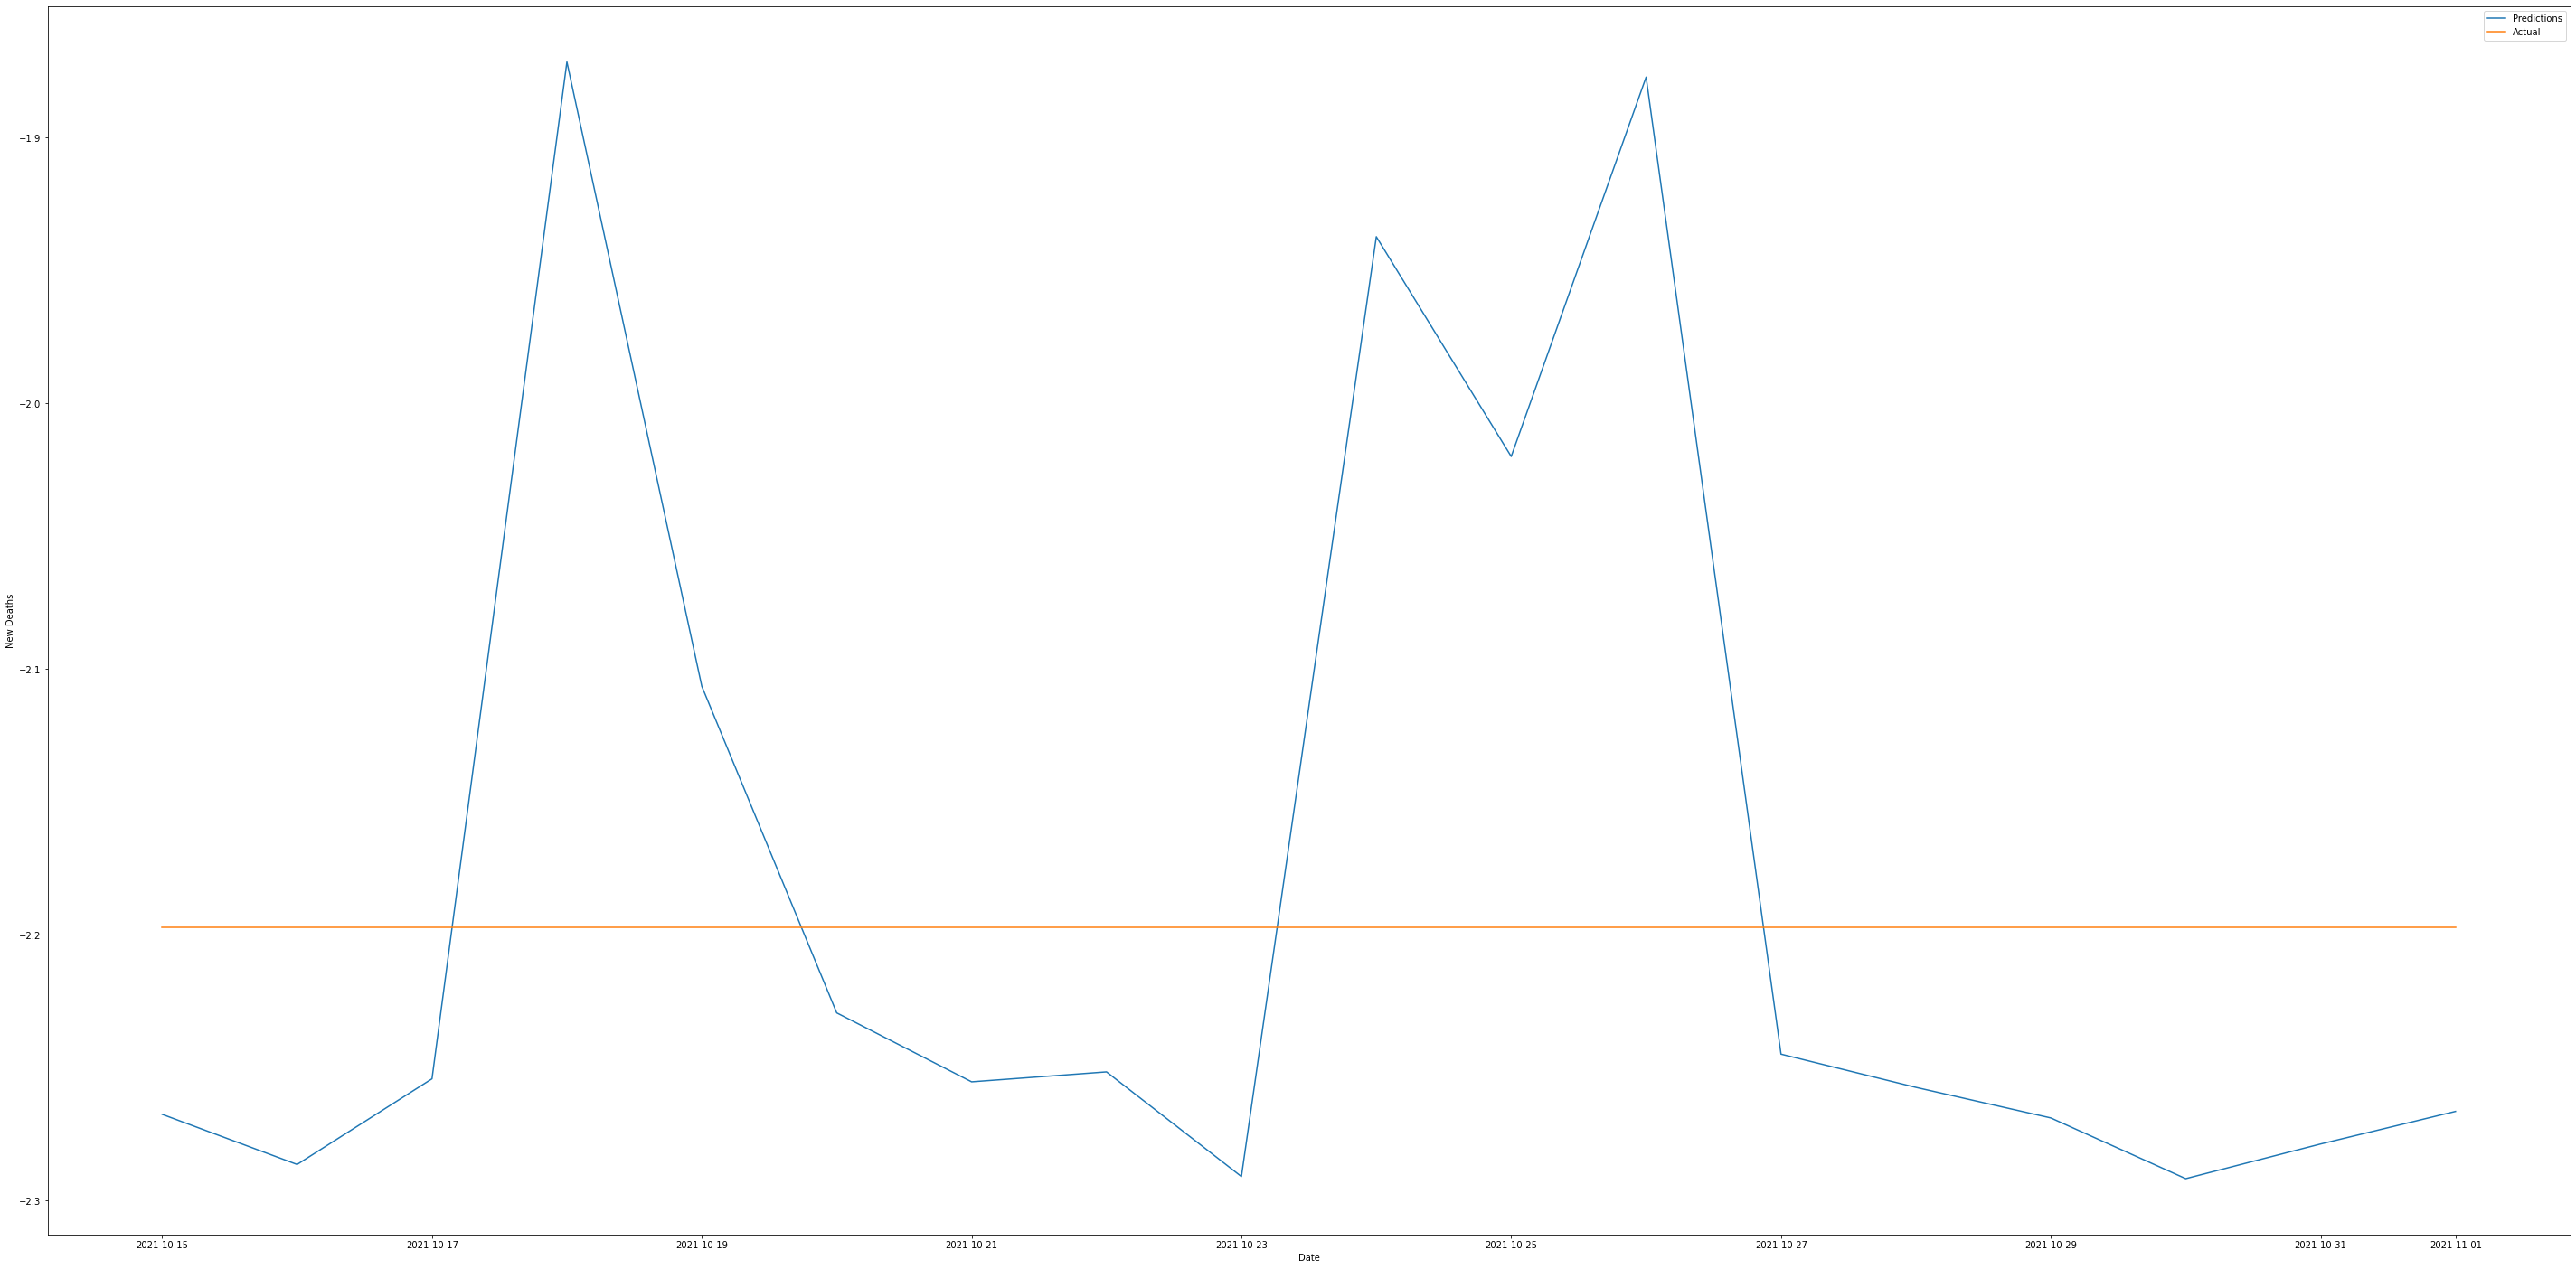

C: 1.0 - SVR Score: 0.8712465260421922


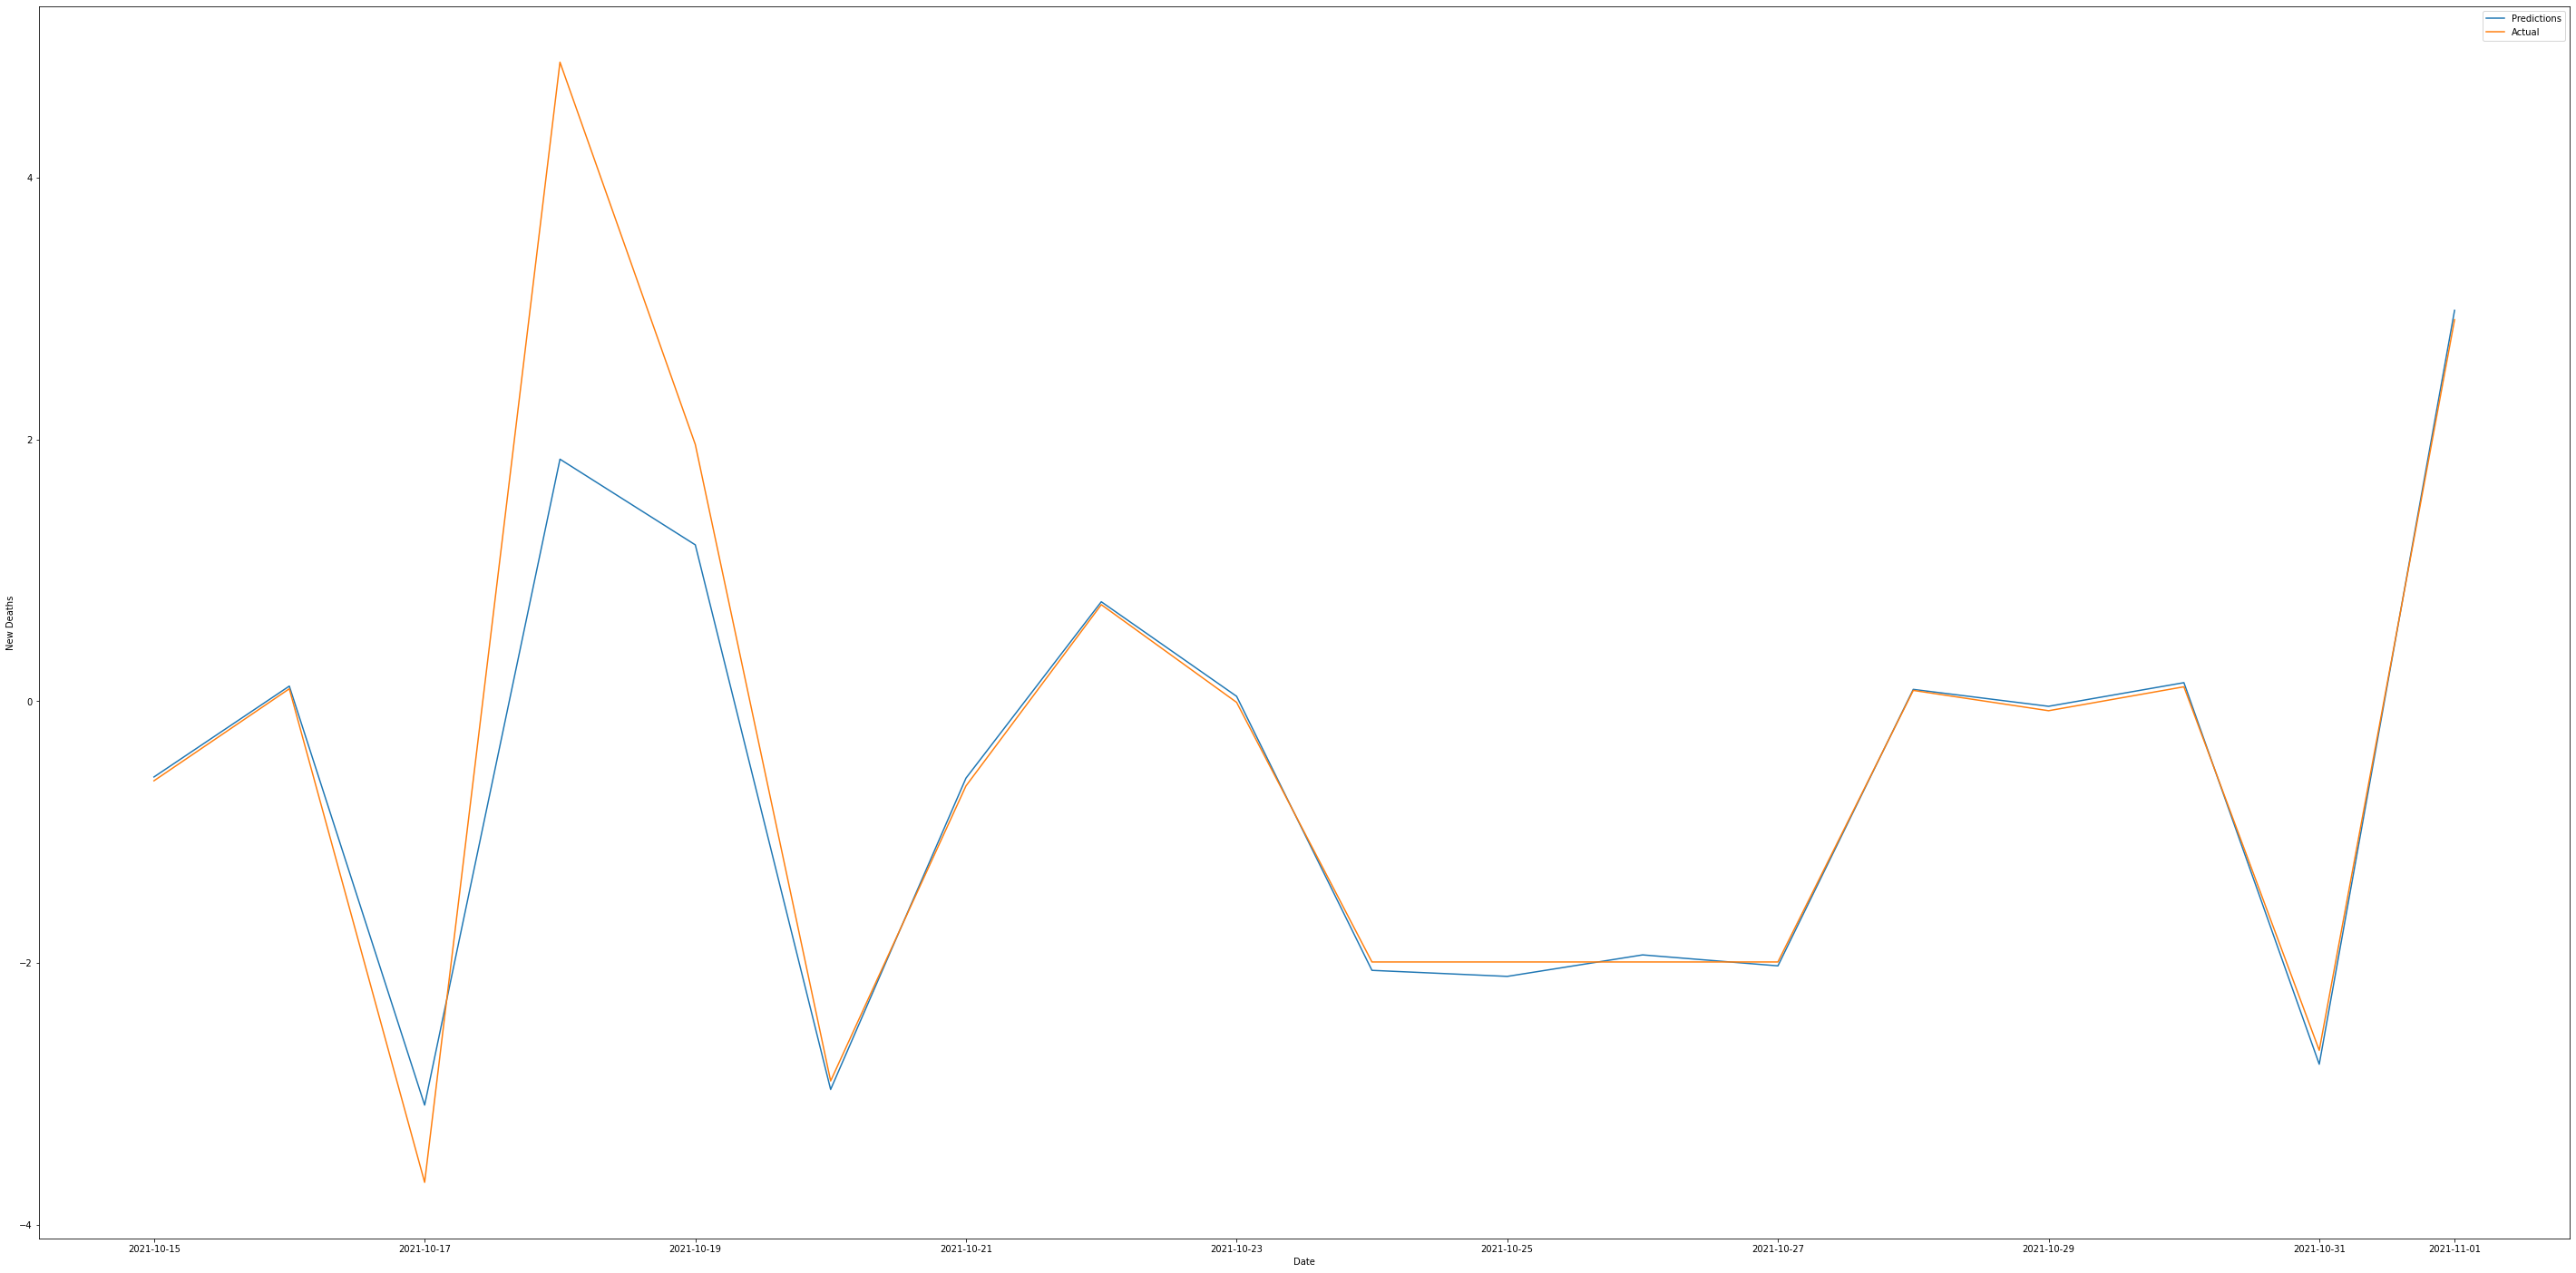

C: 1.0 - SVR Score: 0.9982197833360554


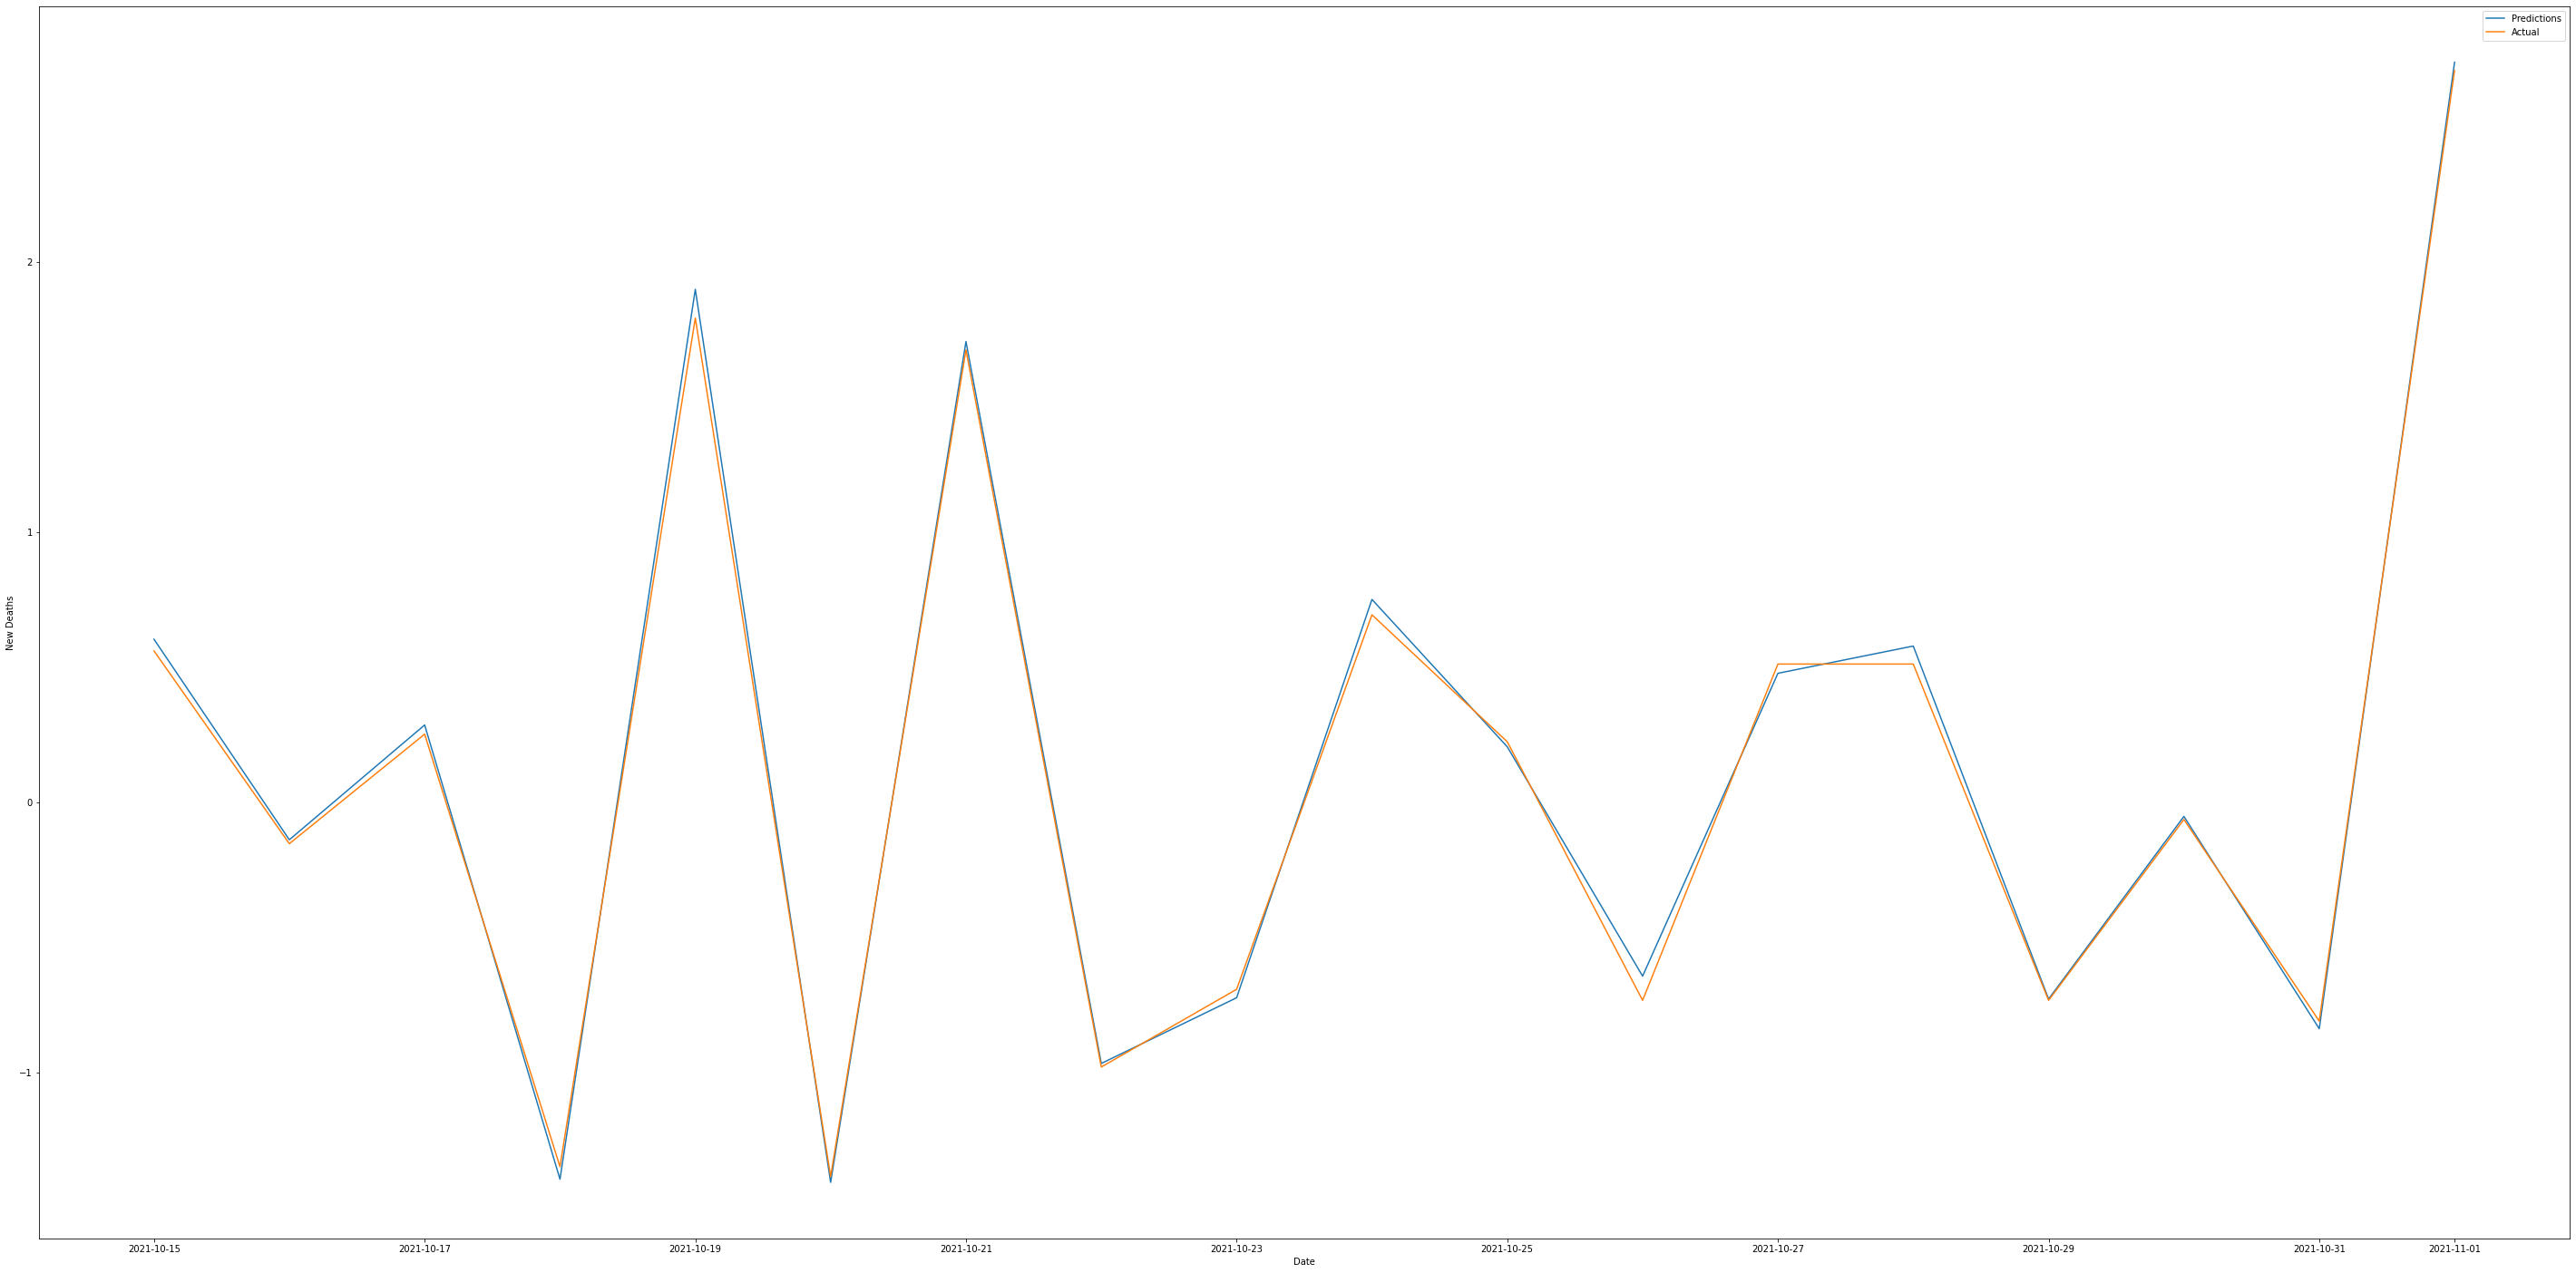

C: 1.0 - SVR Score: 0.9914818514926246


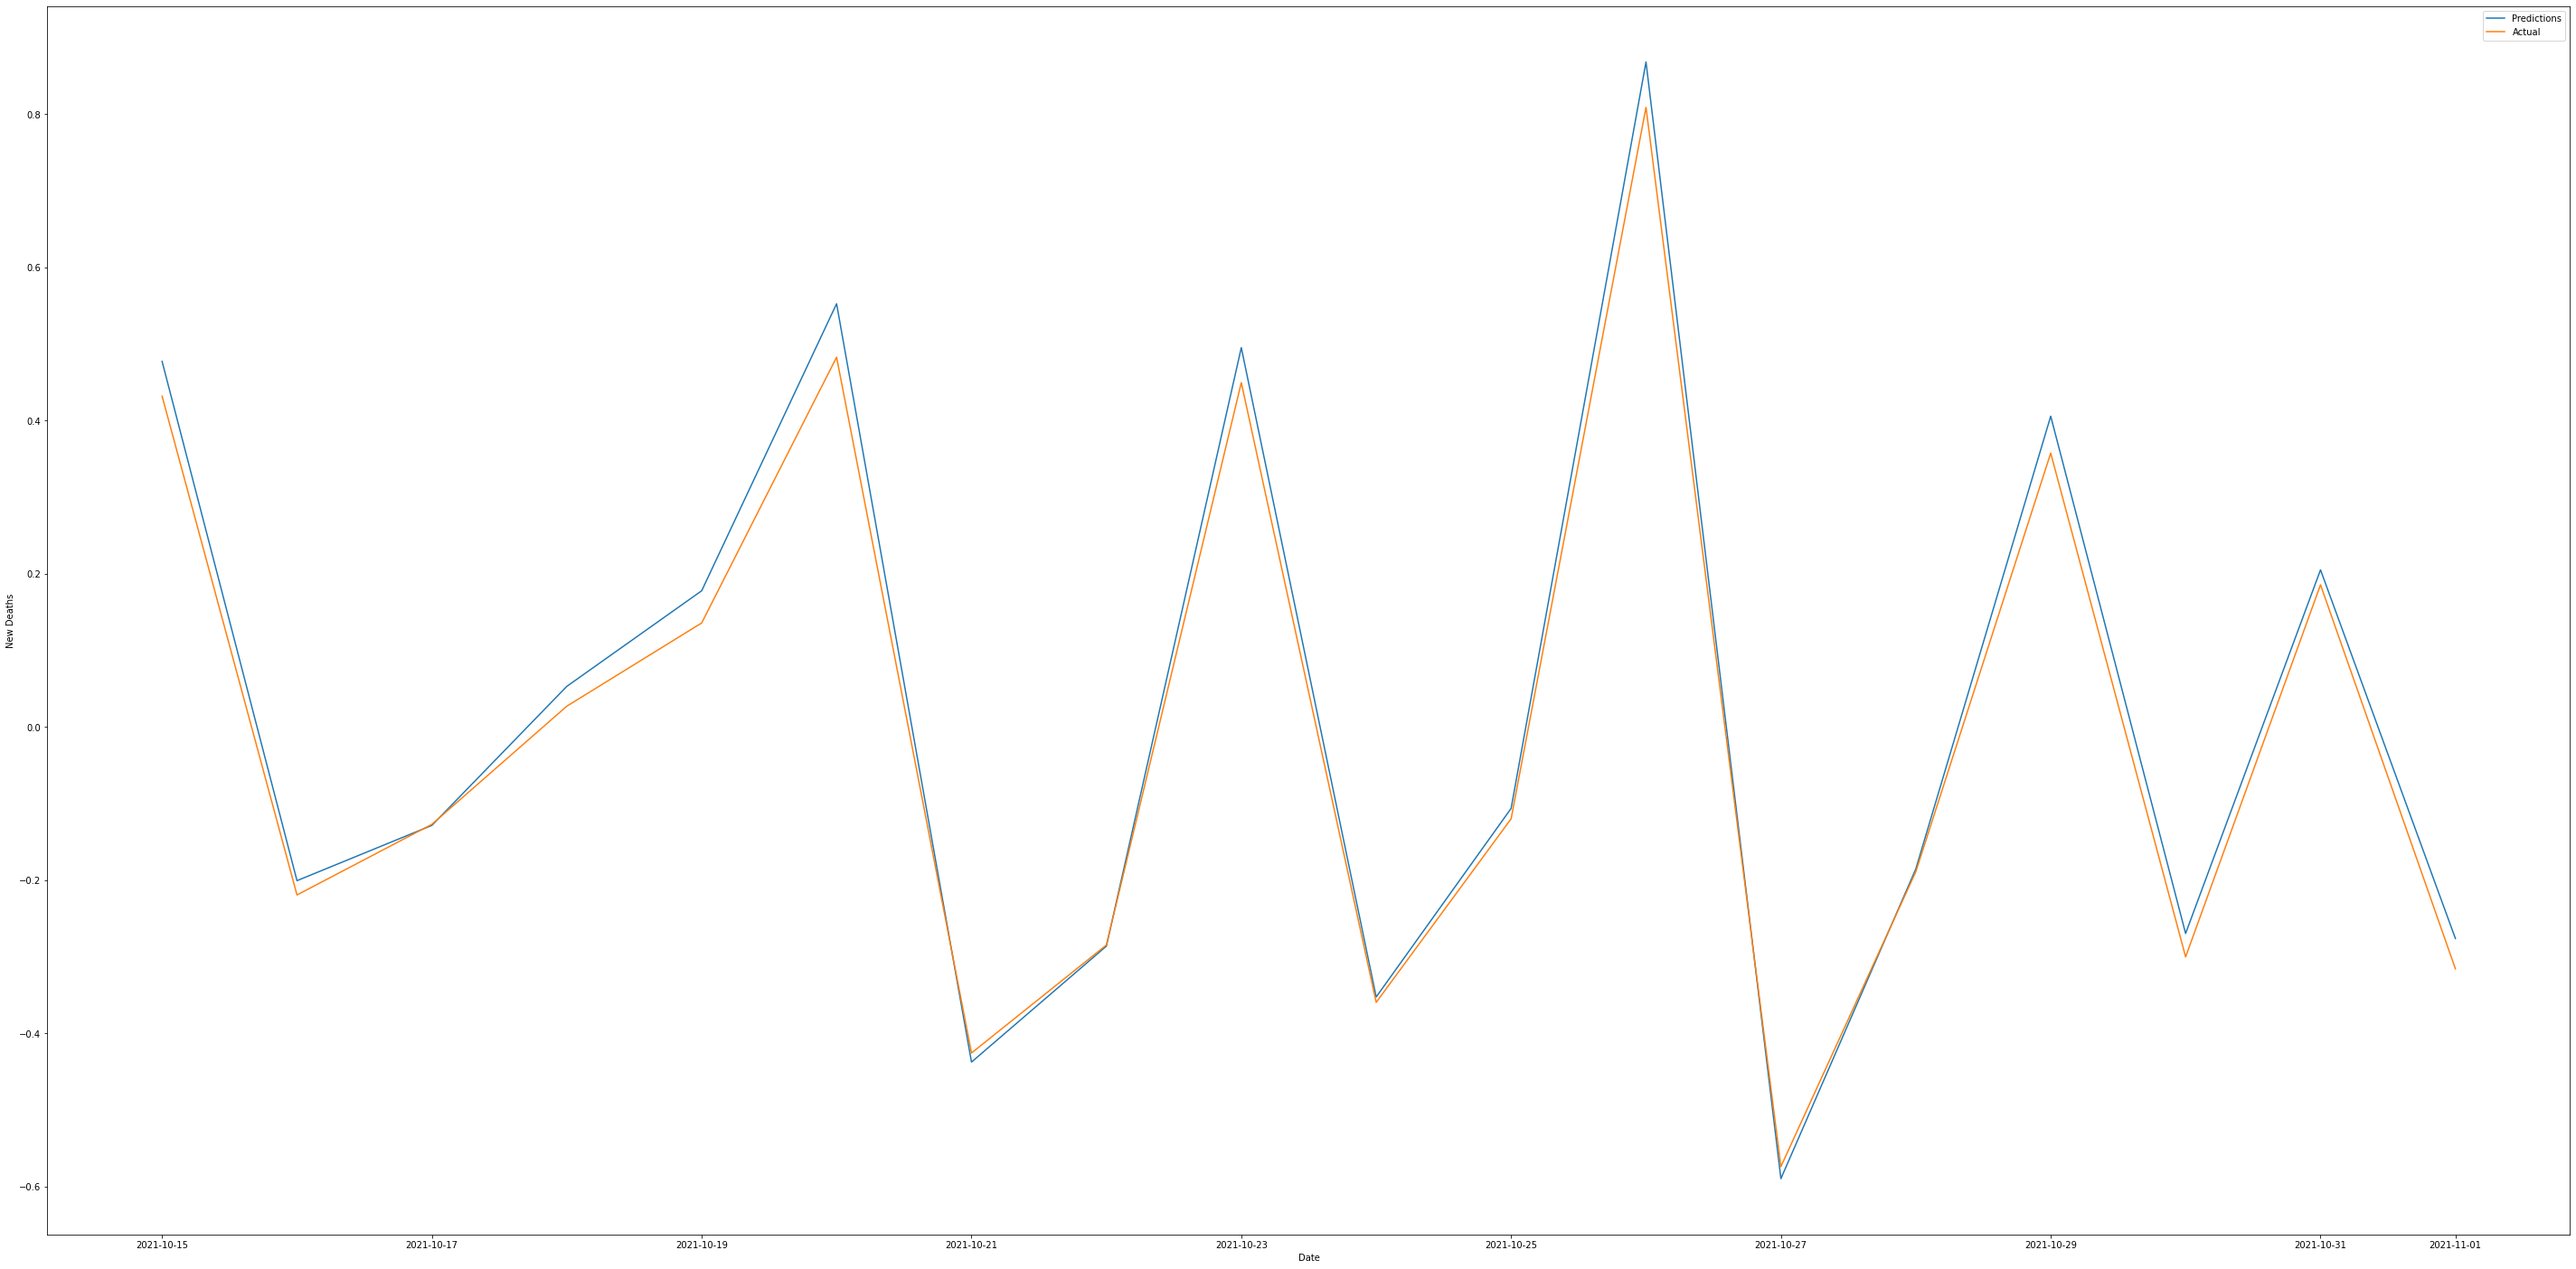

C: 1.0 - SVR Score: -2.3607840252762657


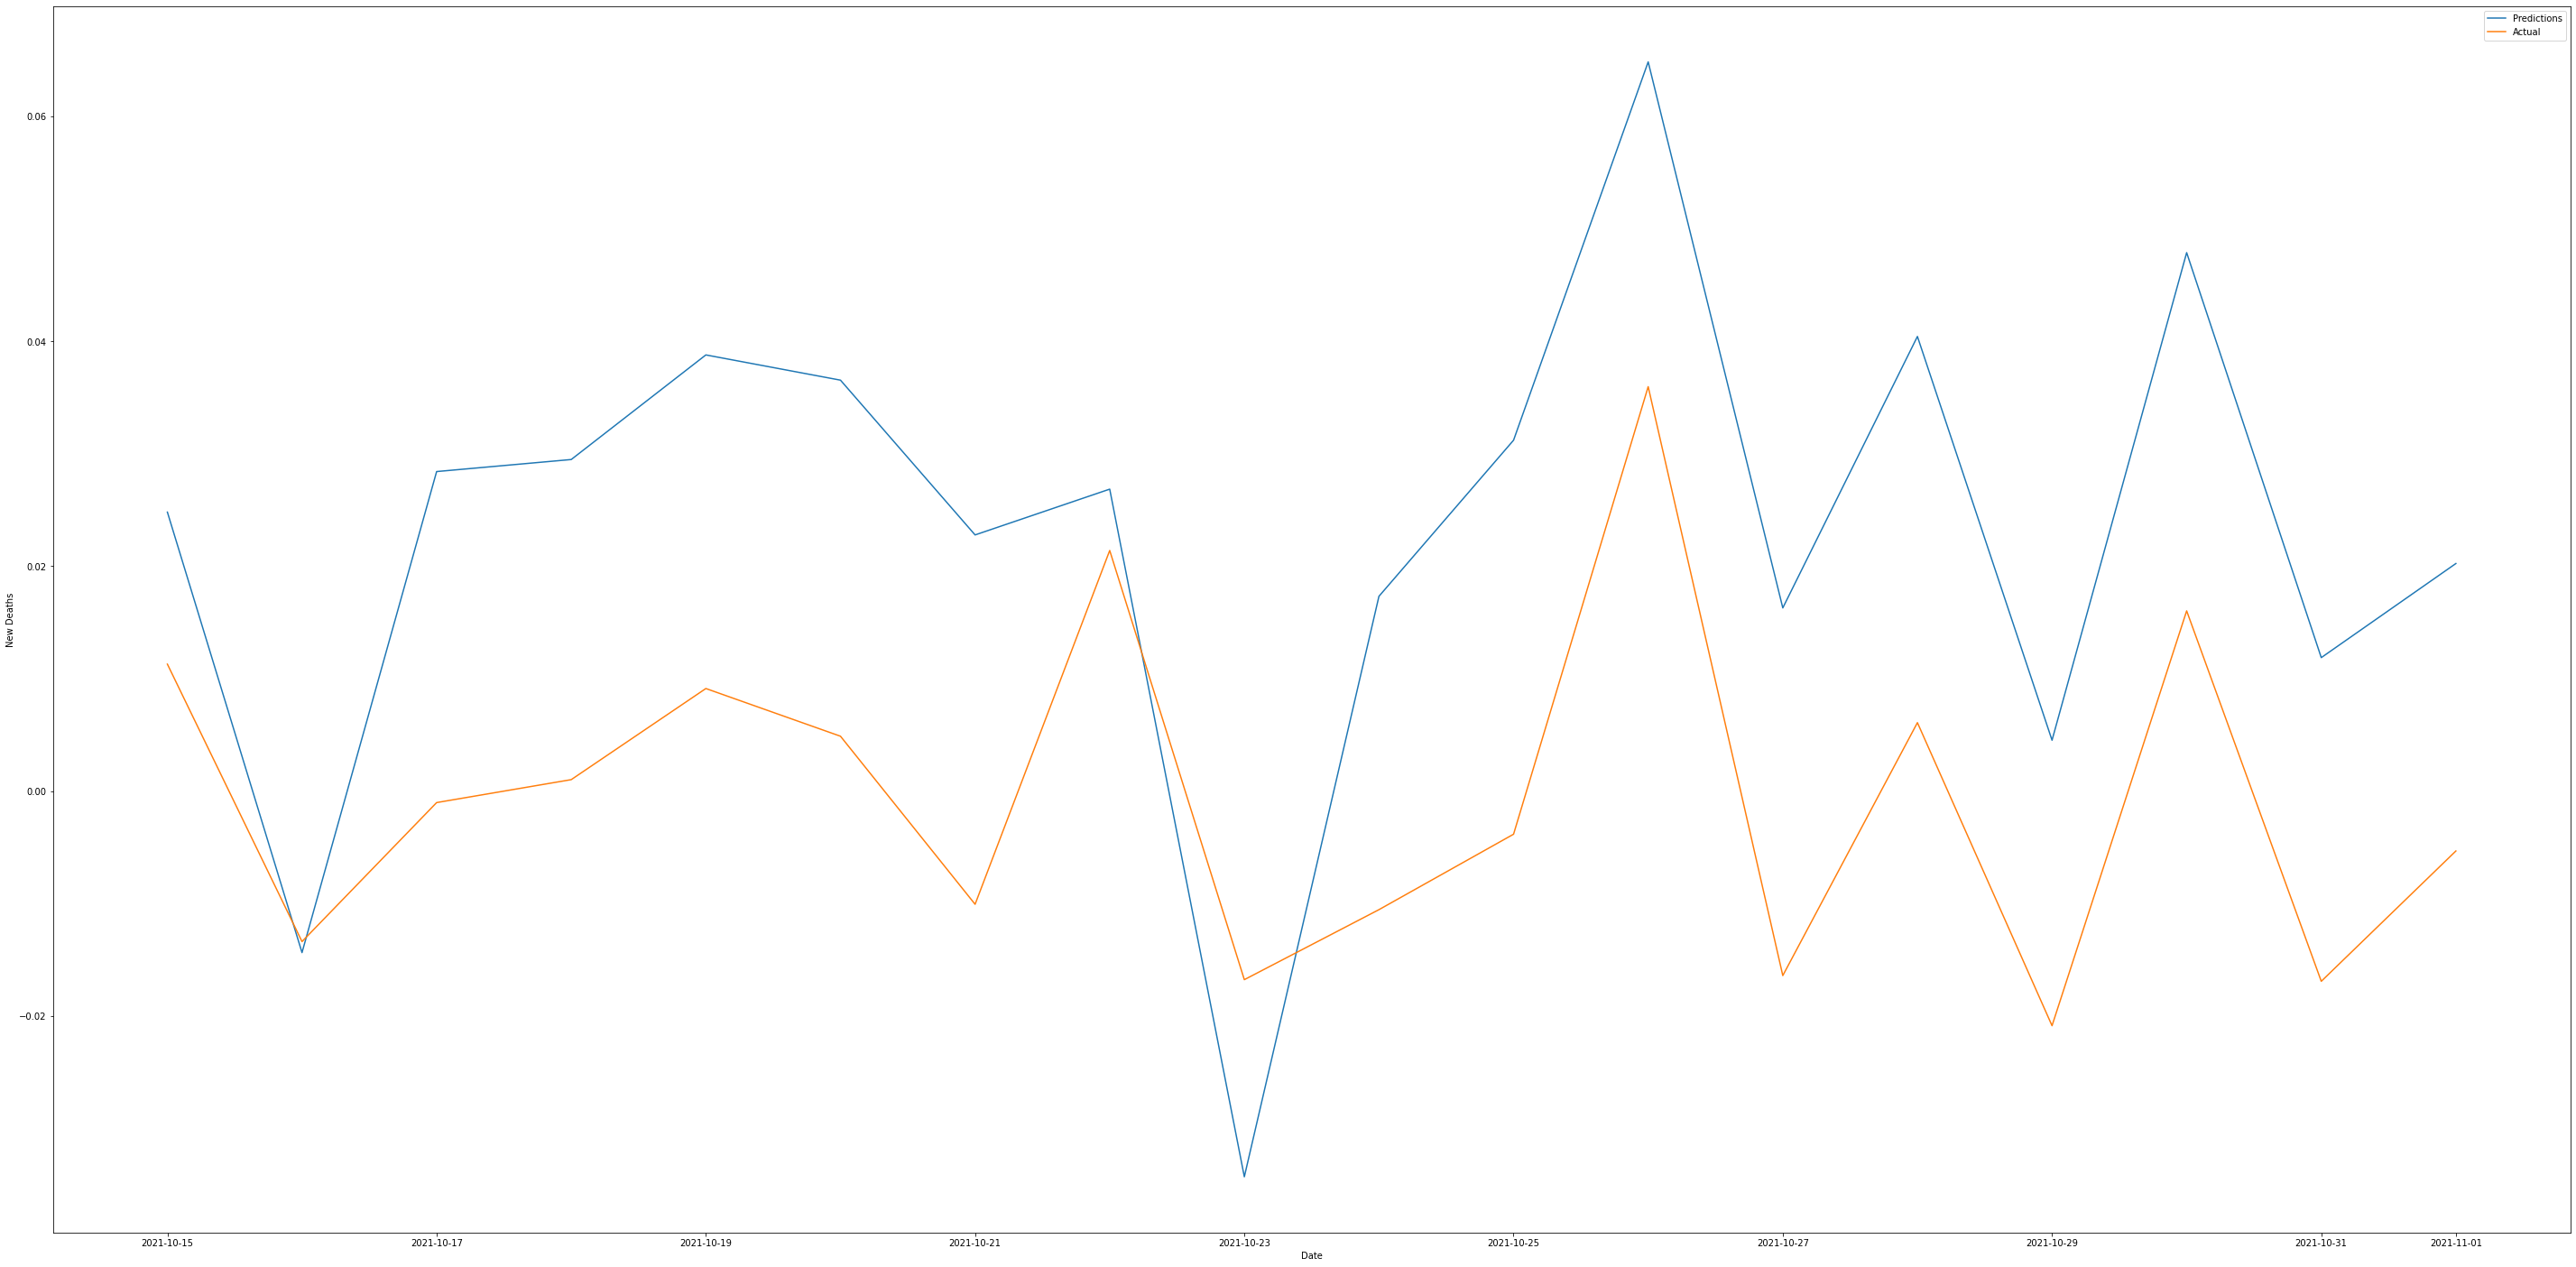

C: 1.0 - SVR Score: 0.8573648109436434


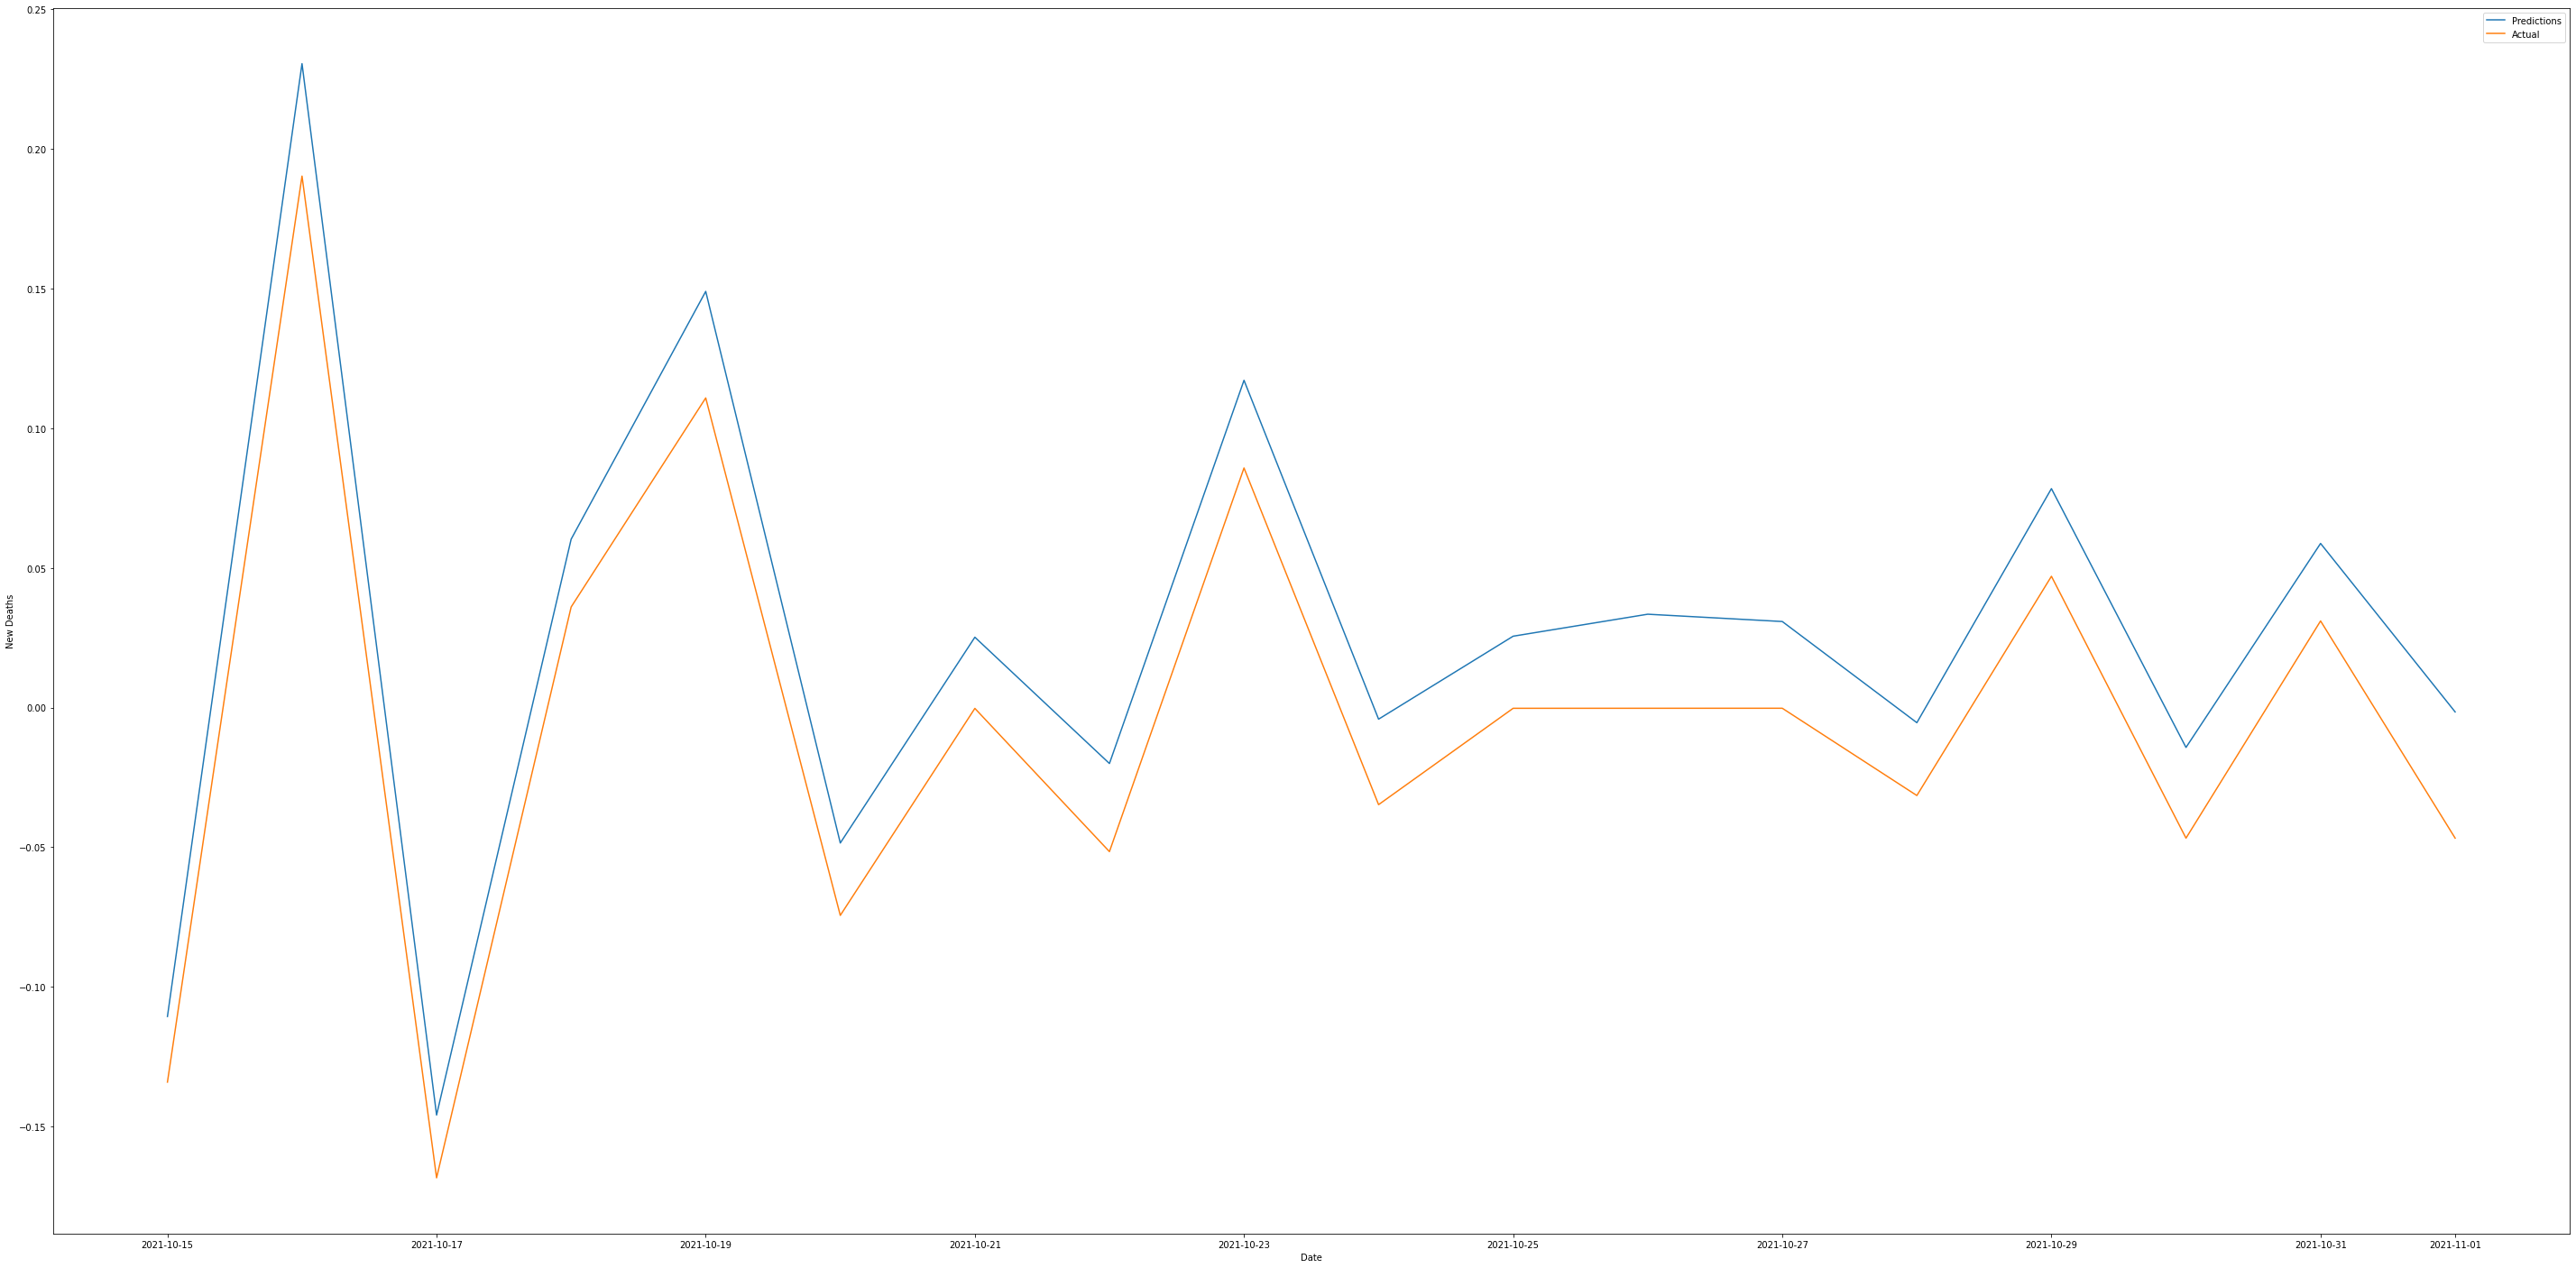

C: 1.0 - SVR Score: 0.9959057630713207


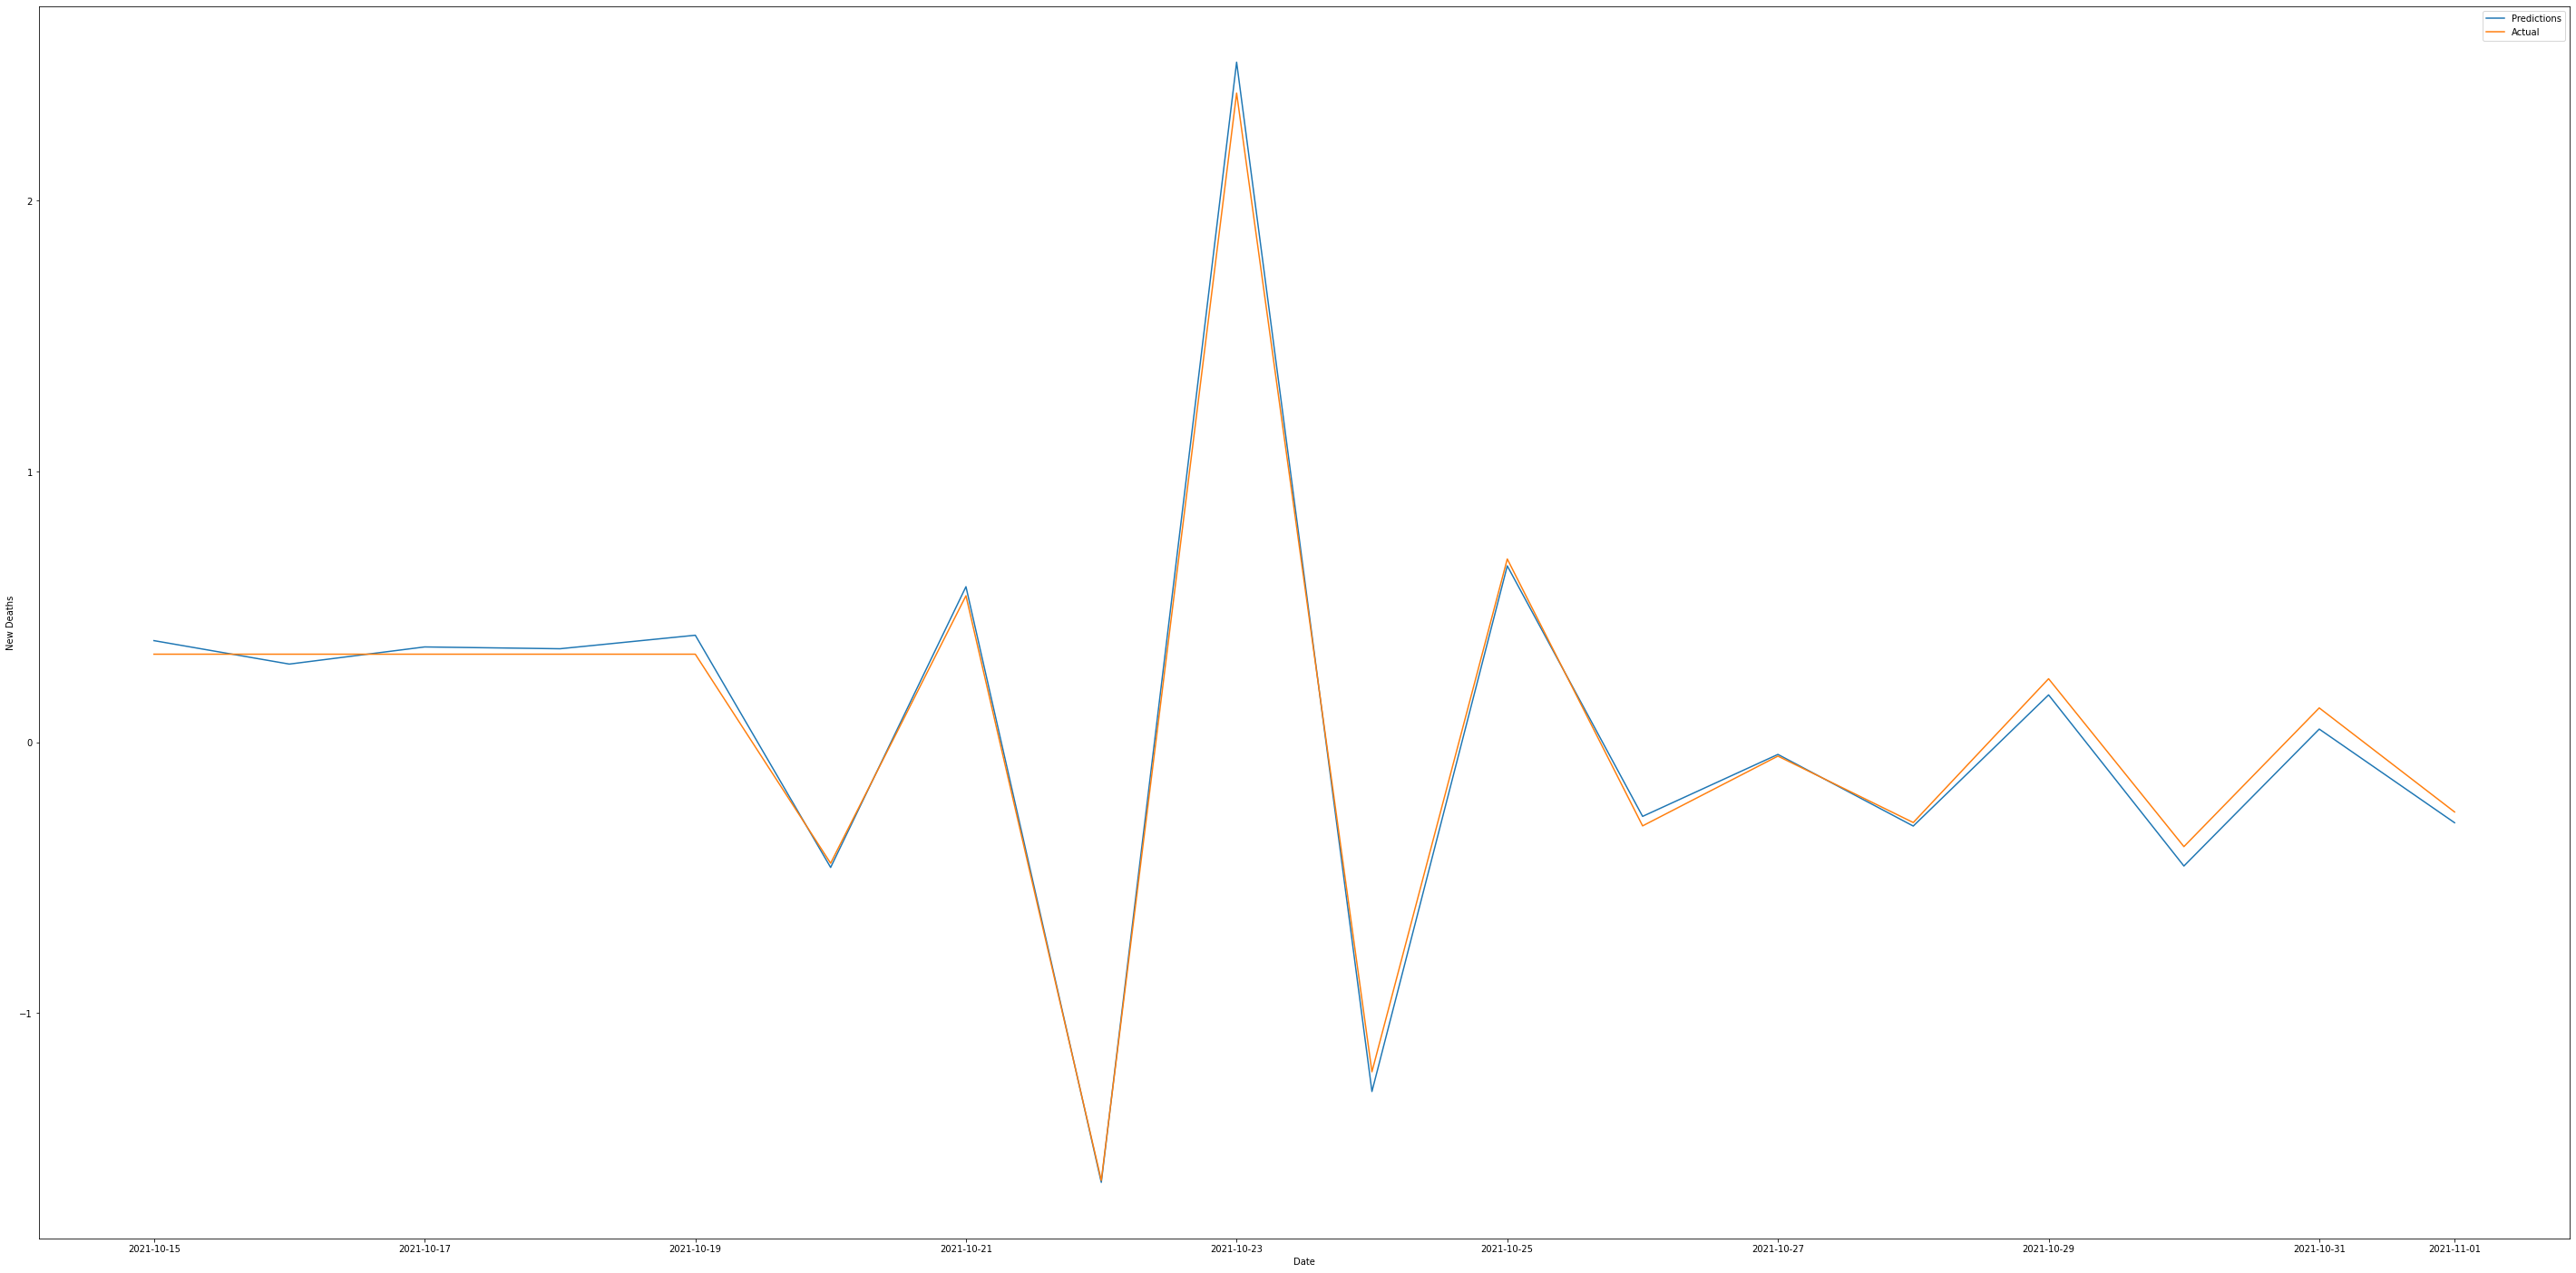

C: 1.0 - SVR Score: 0.9969363051598684


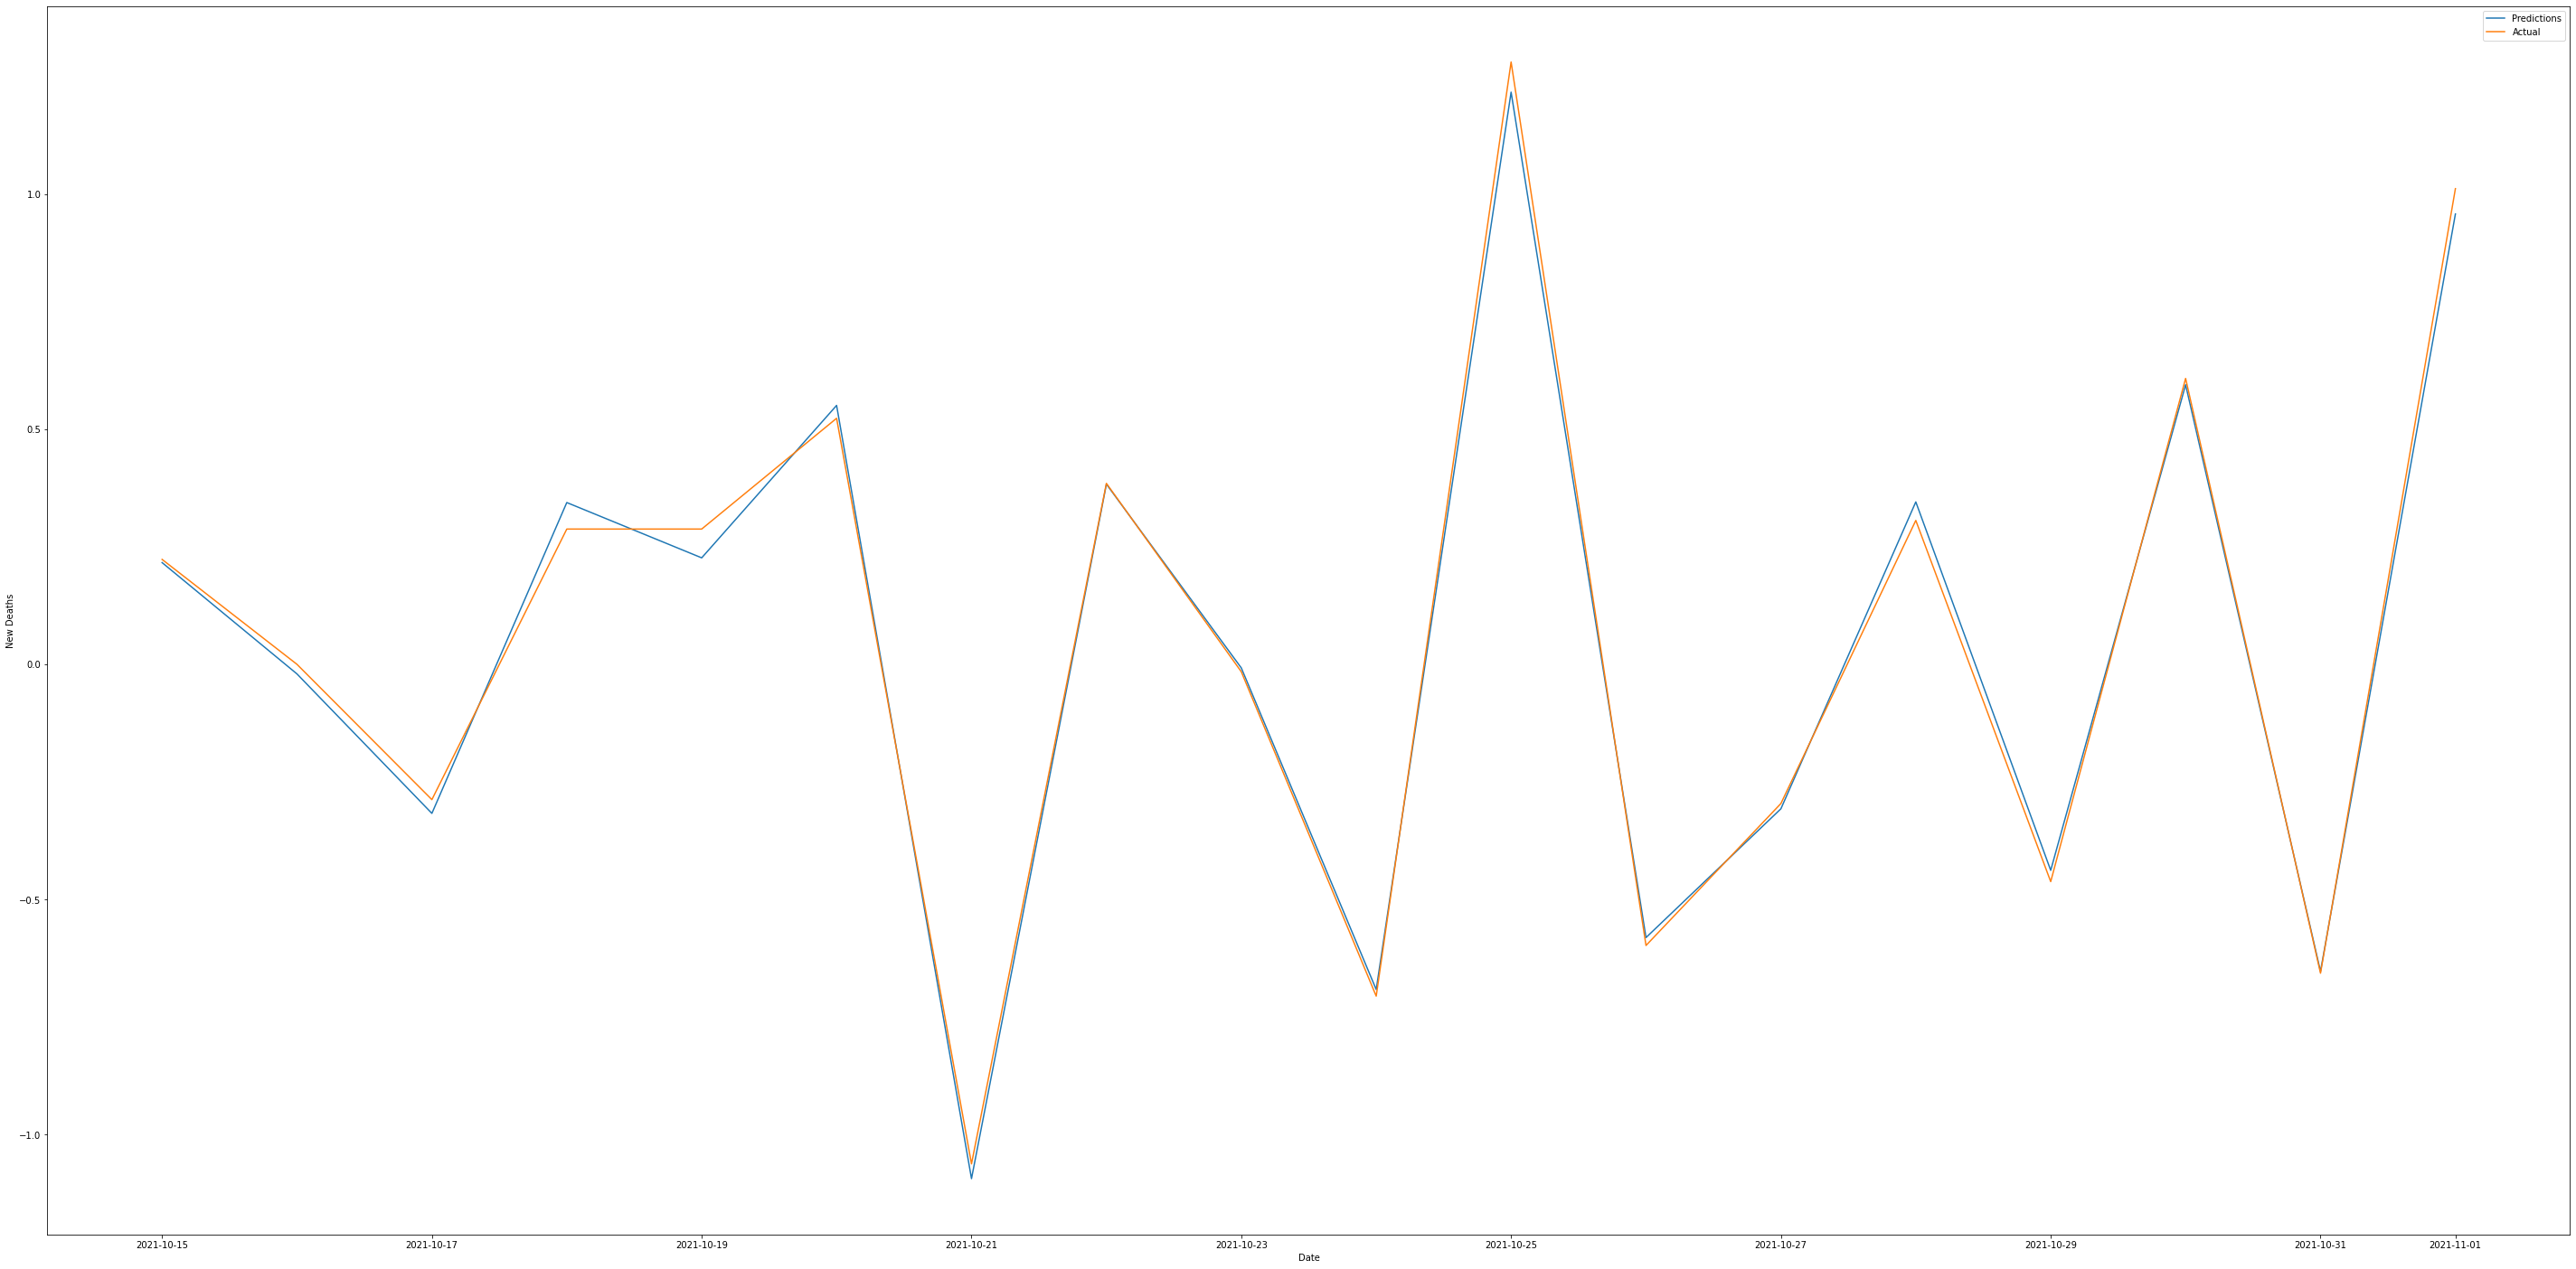

C: 1.0 - SVR Score: 0.9889381076033751


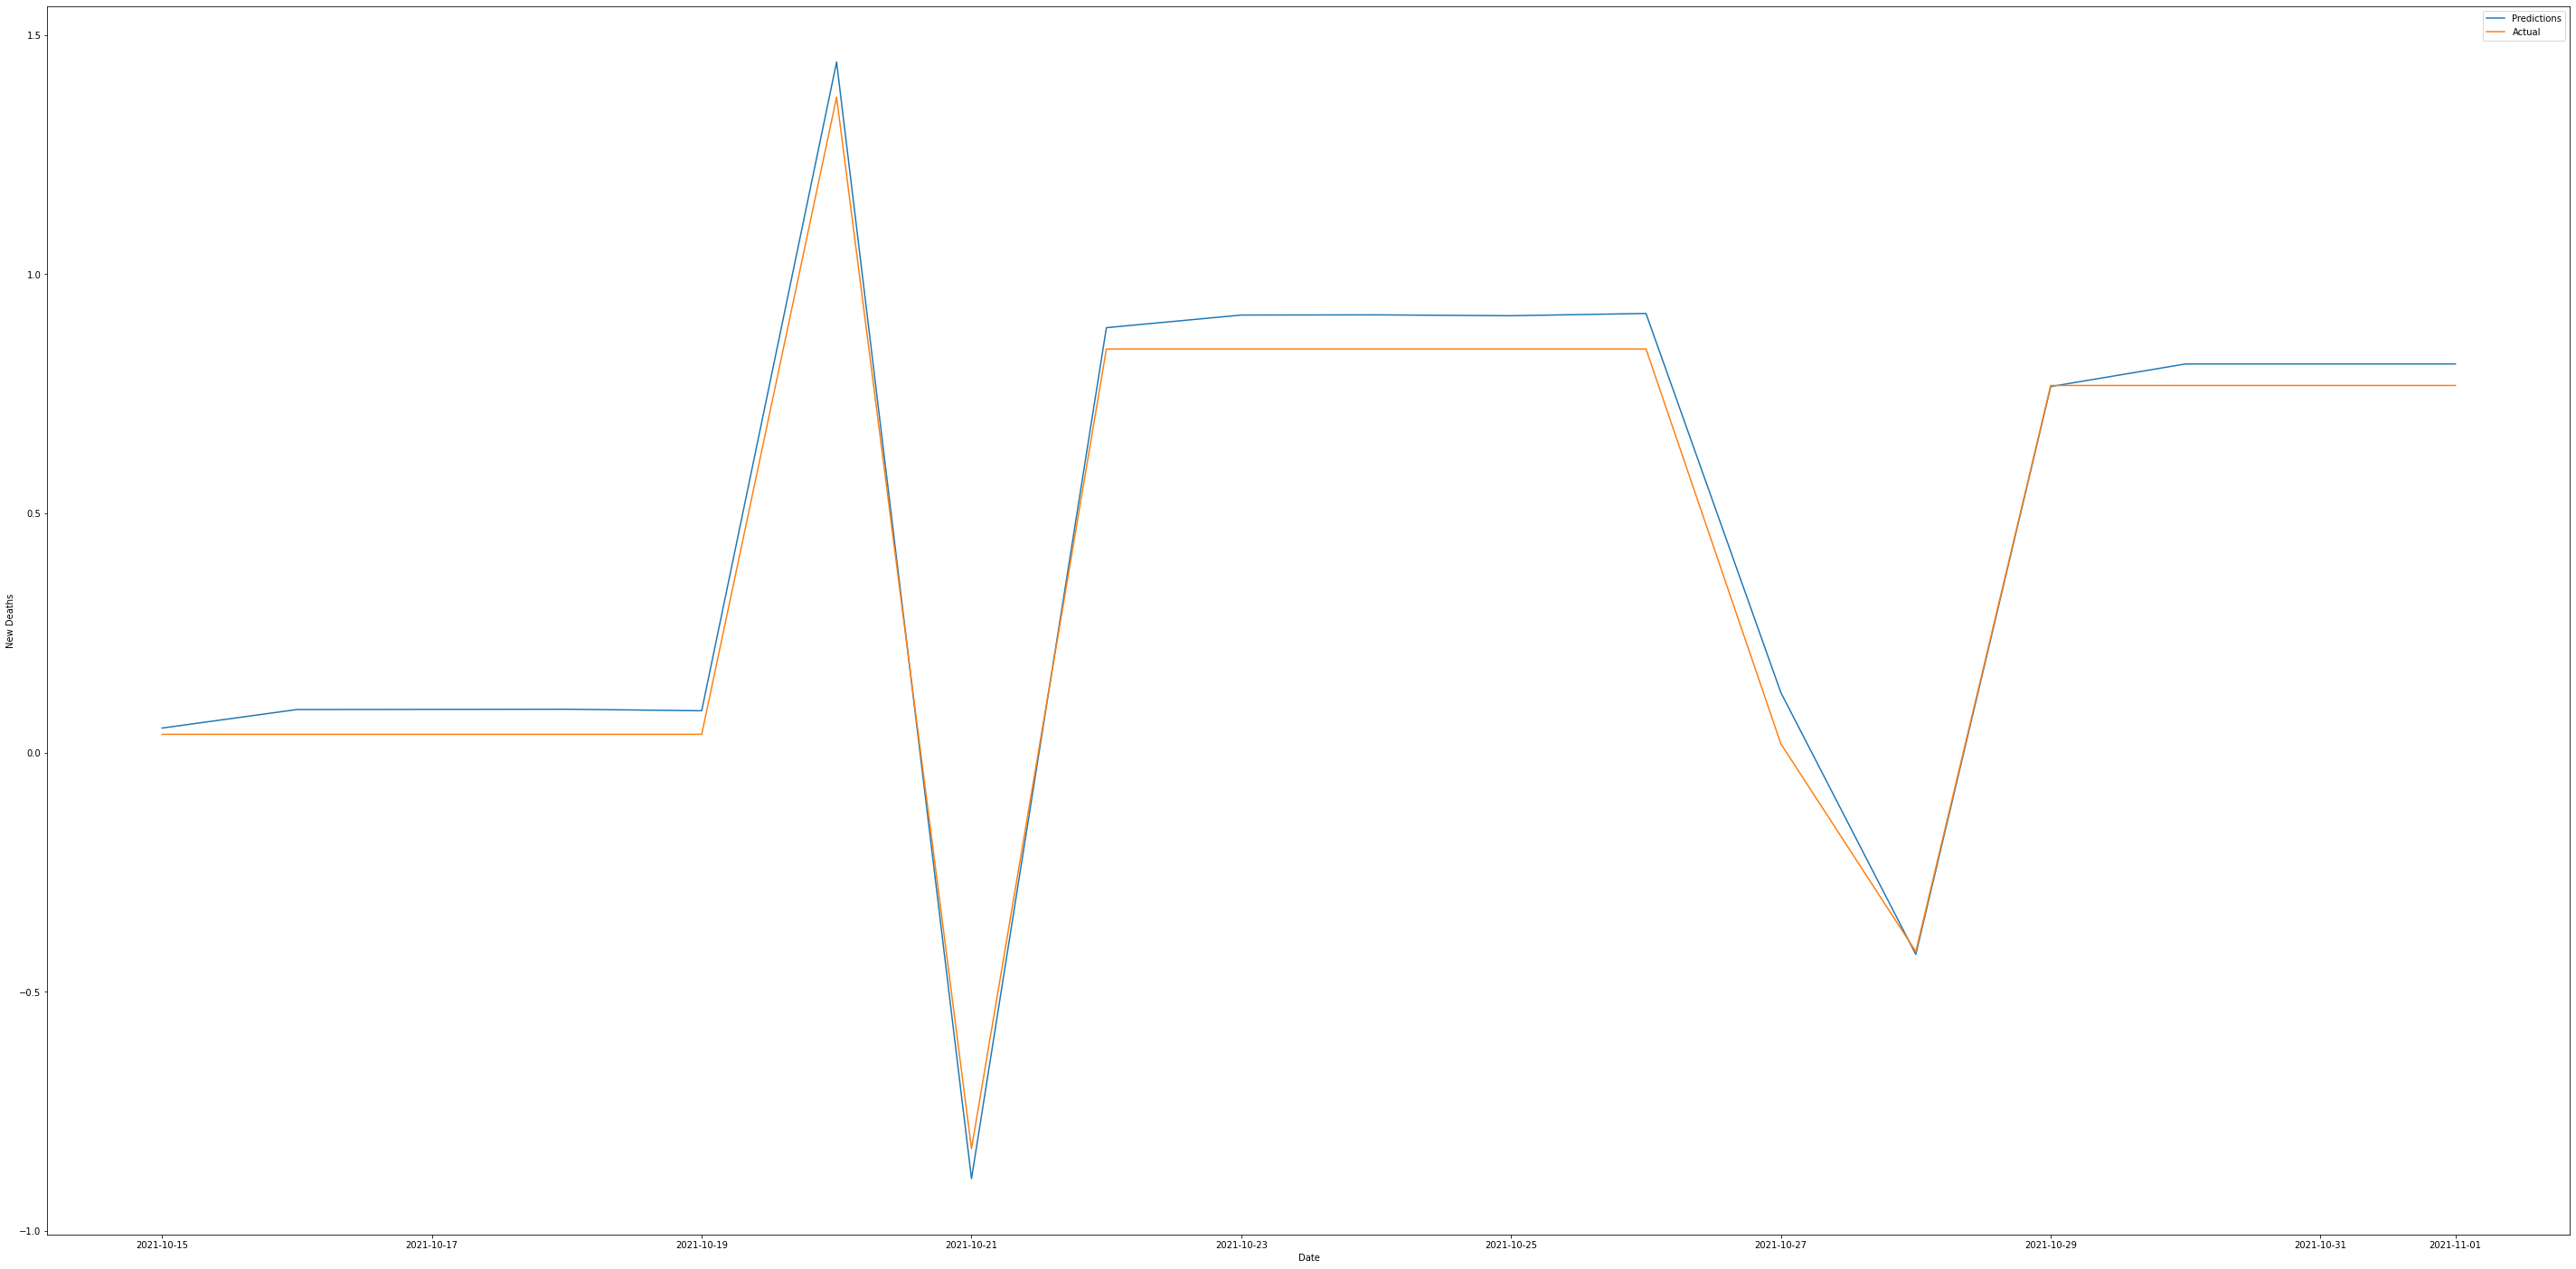

C: 1.0 - SVR Score: 0.9869345137255103


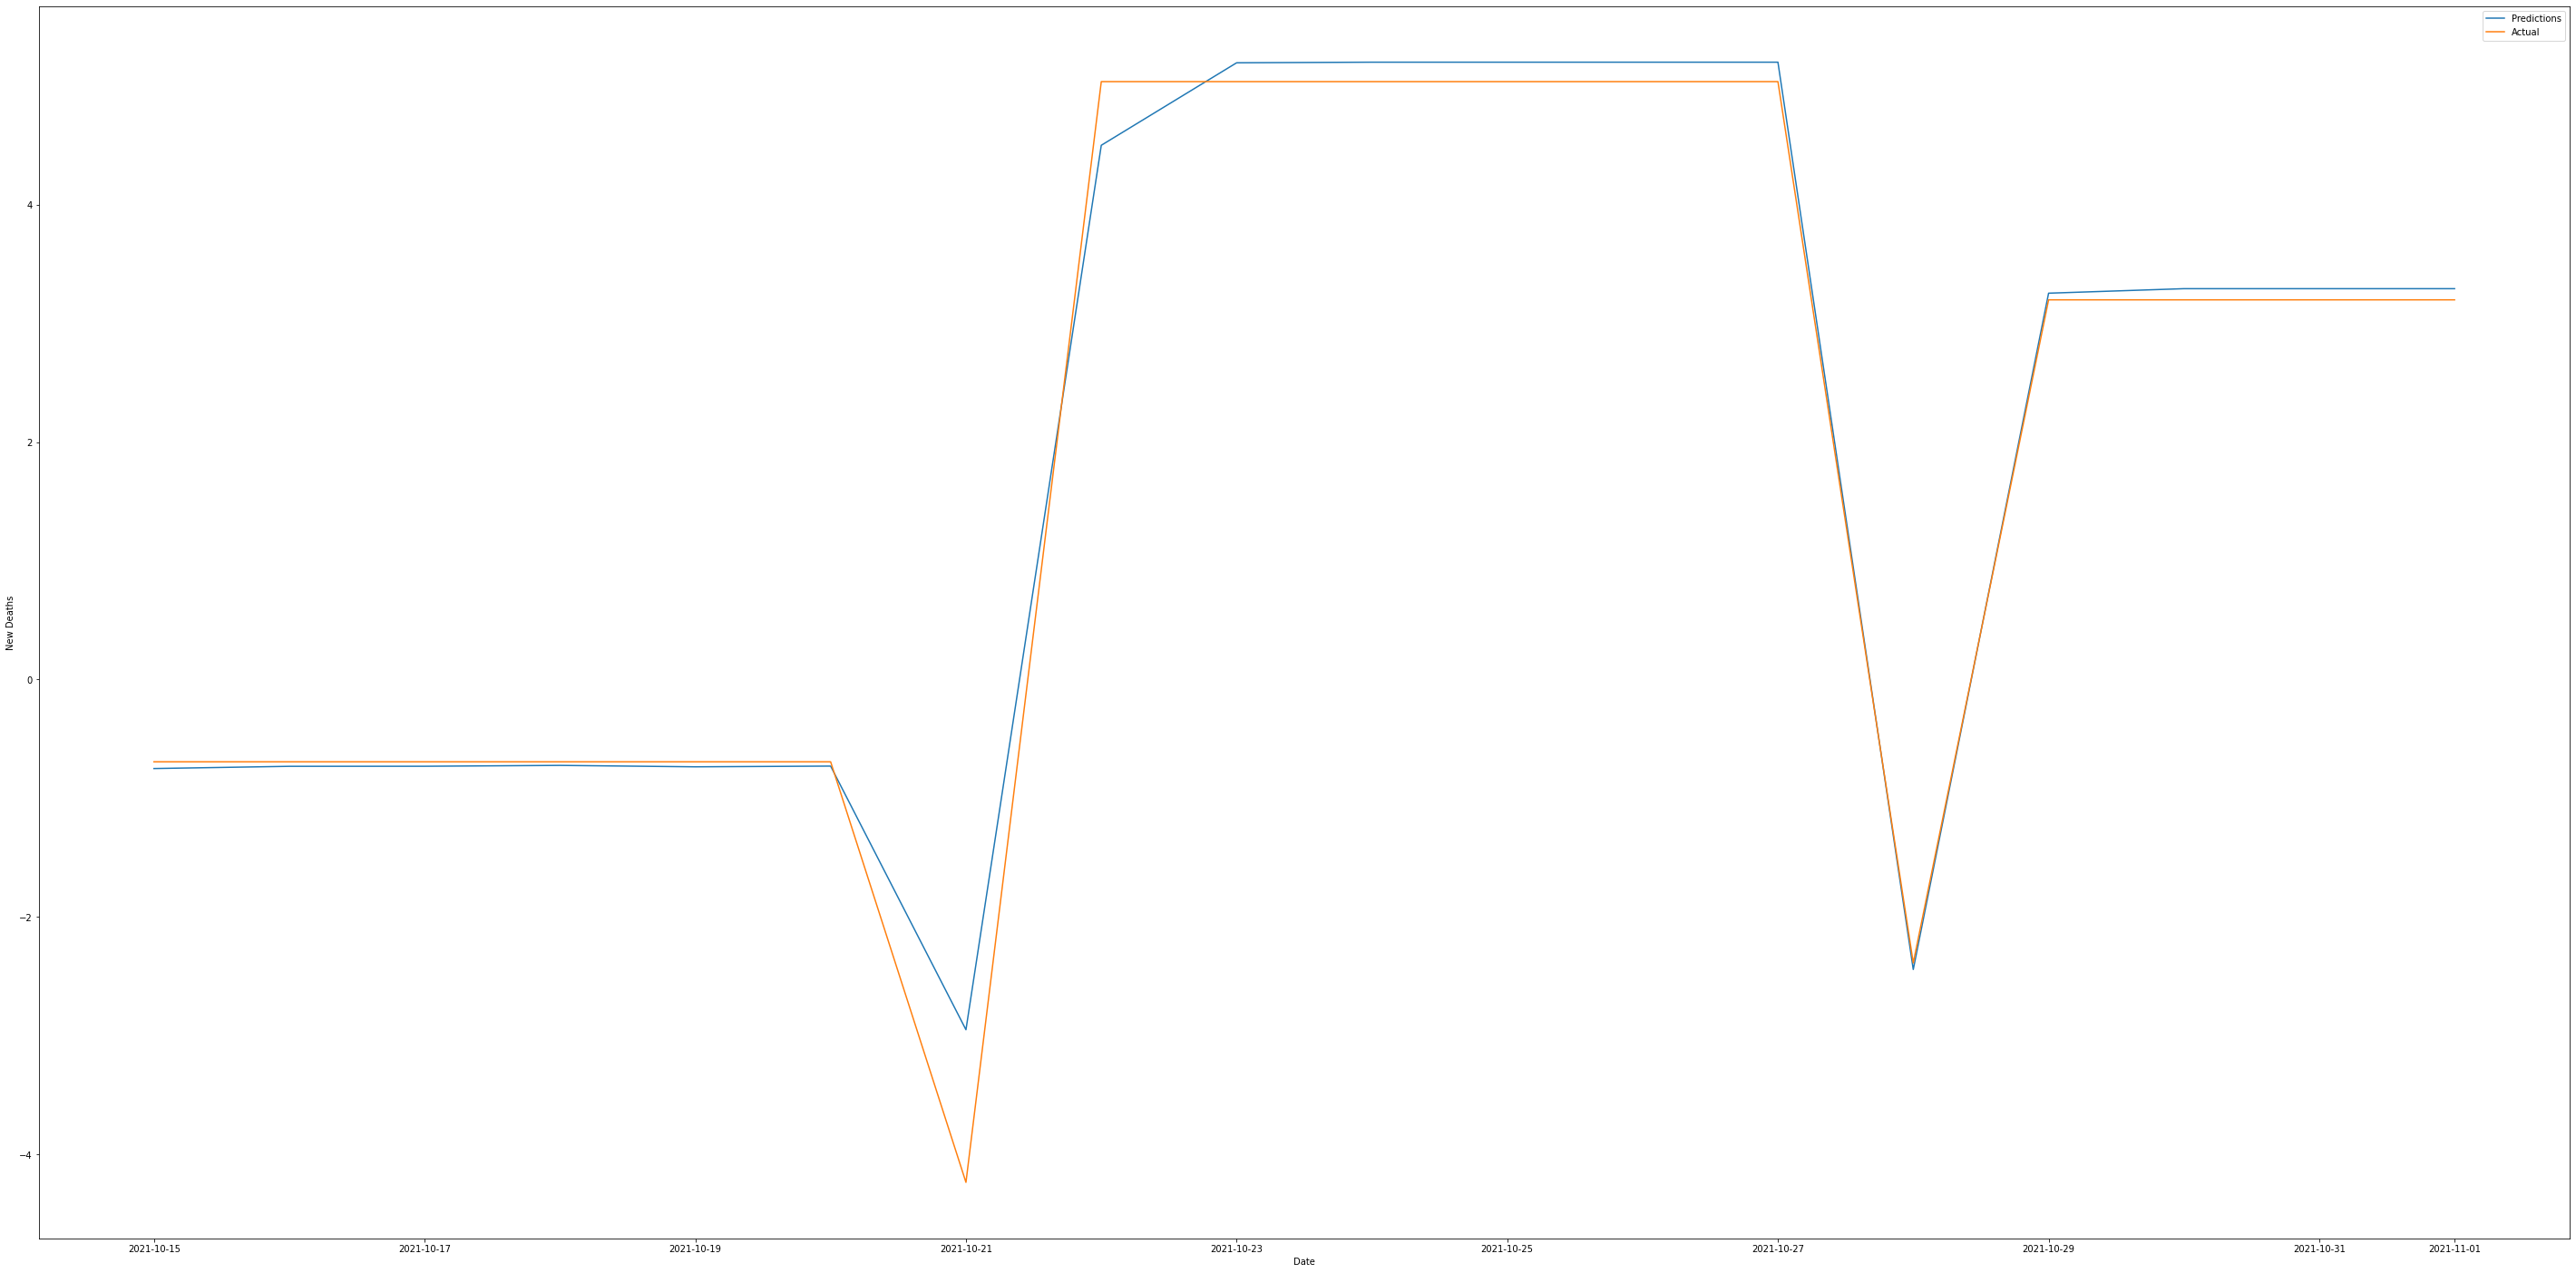

C: 1.0 - SVR Score: 0.8921658347165782


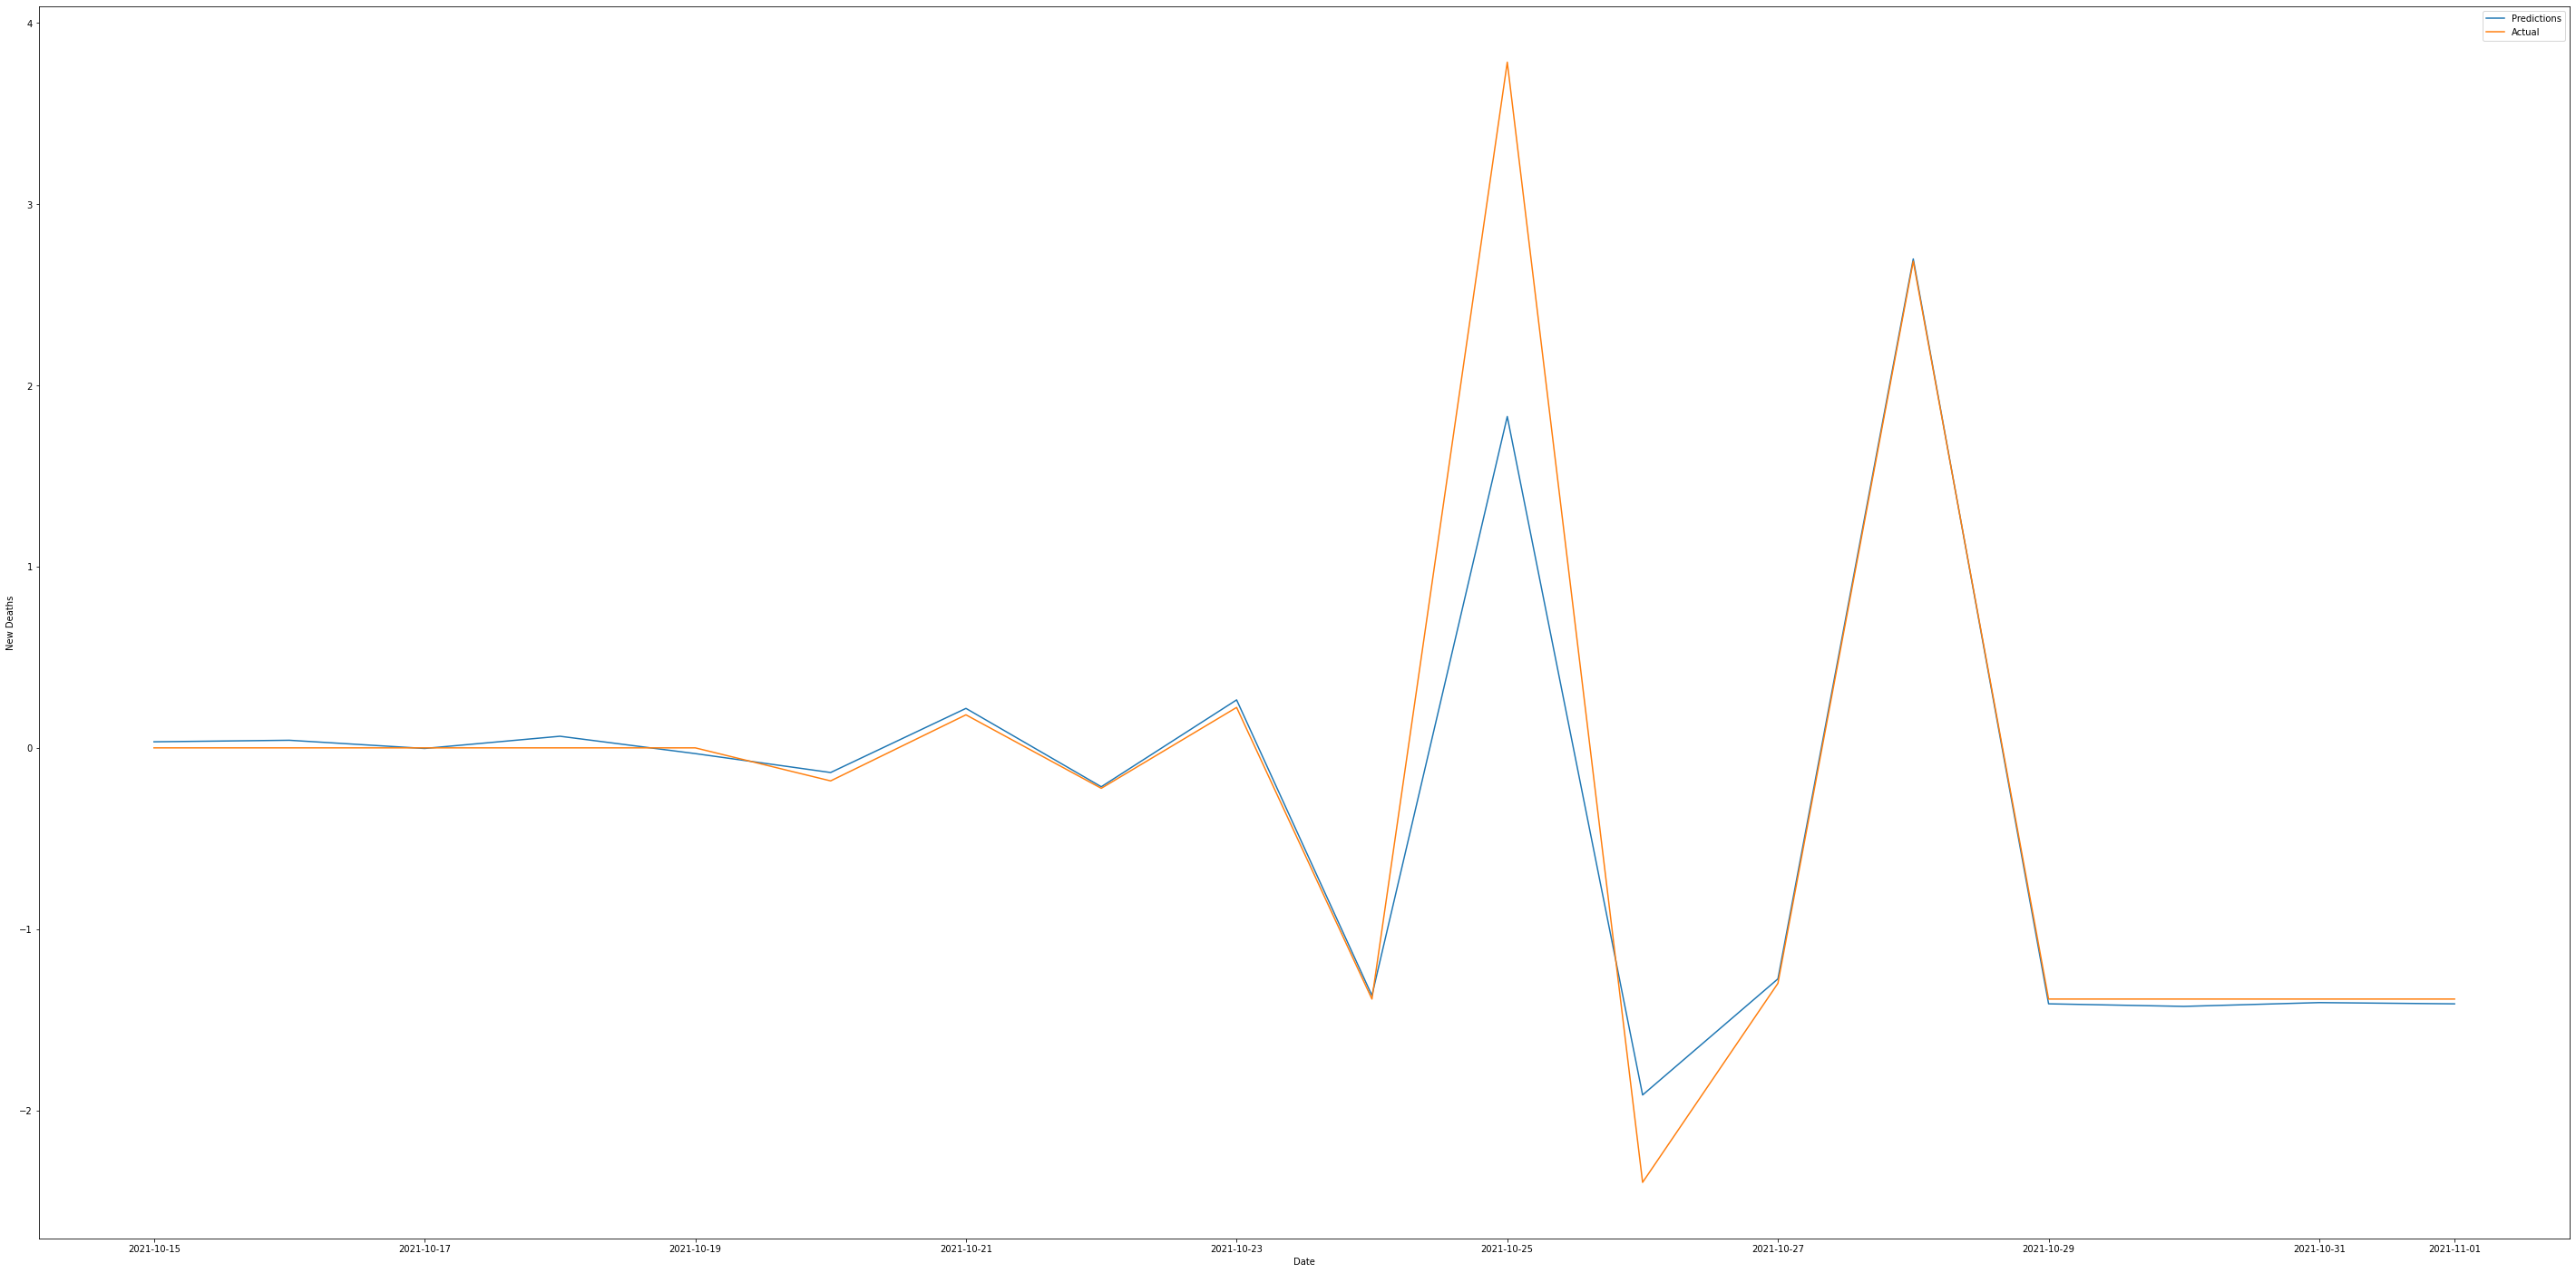

C: 1.0 - SVR Score: 0.9968319040194805


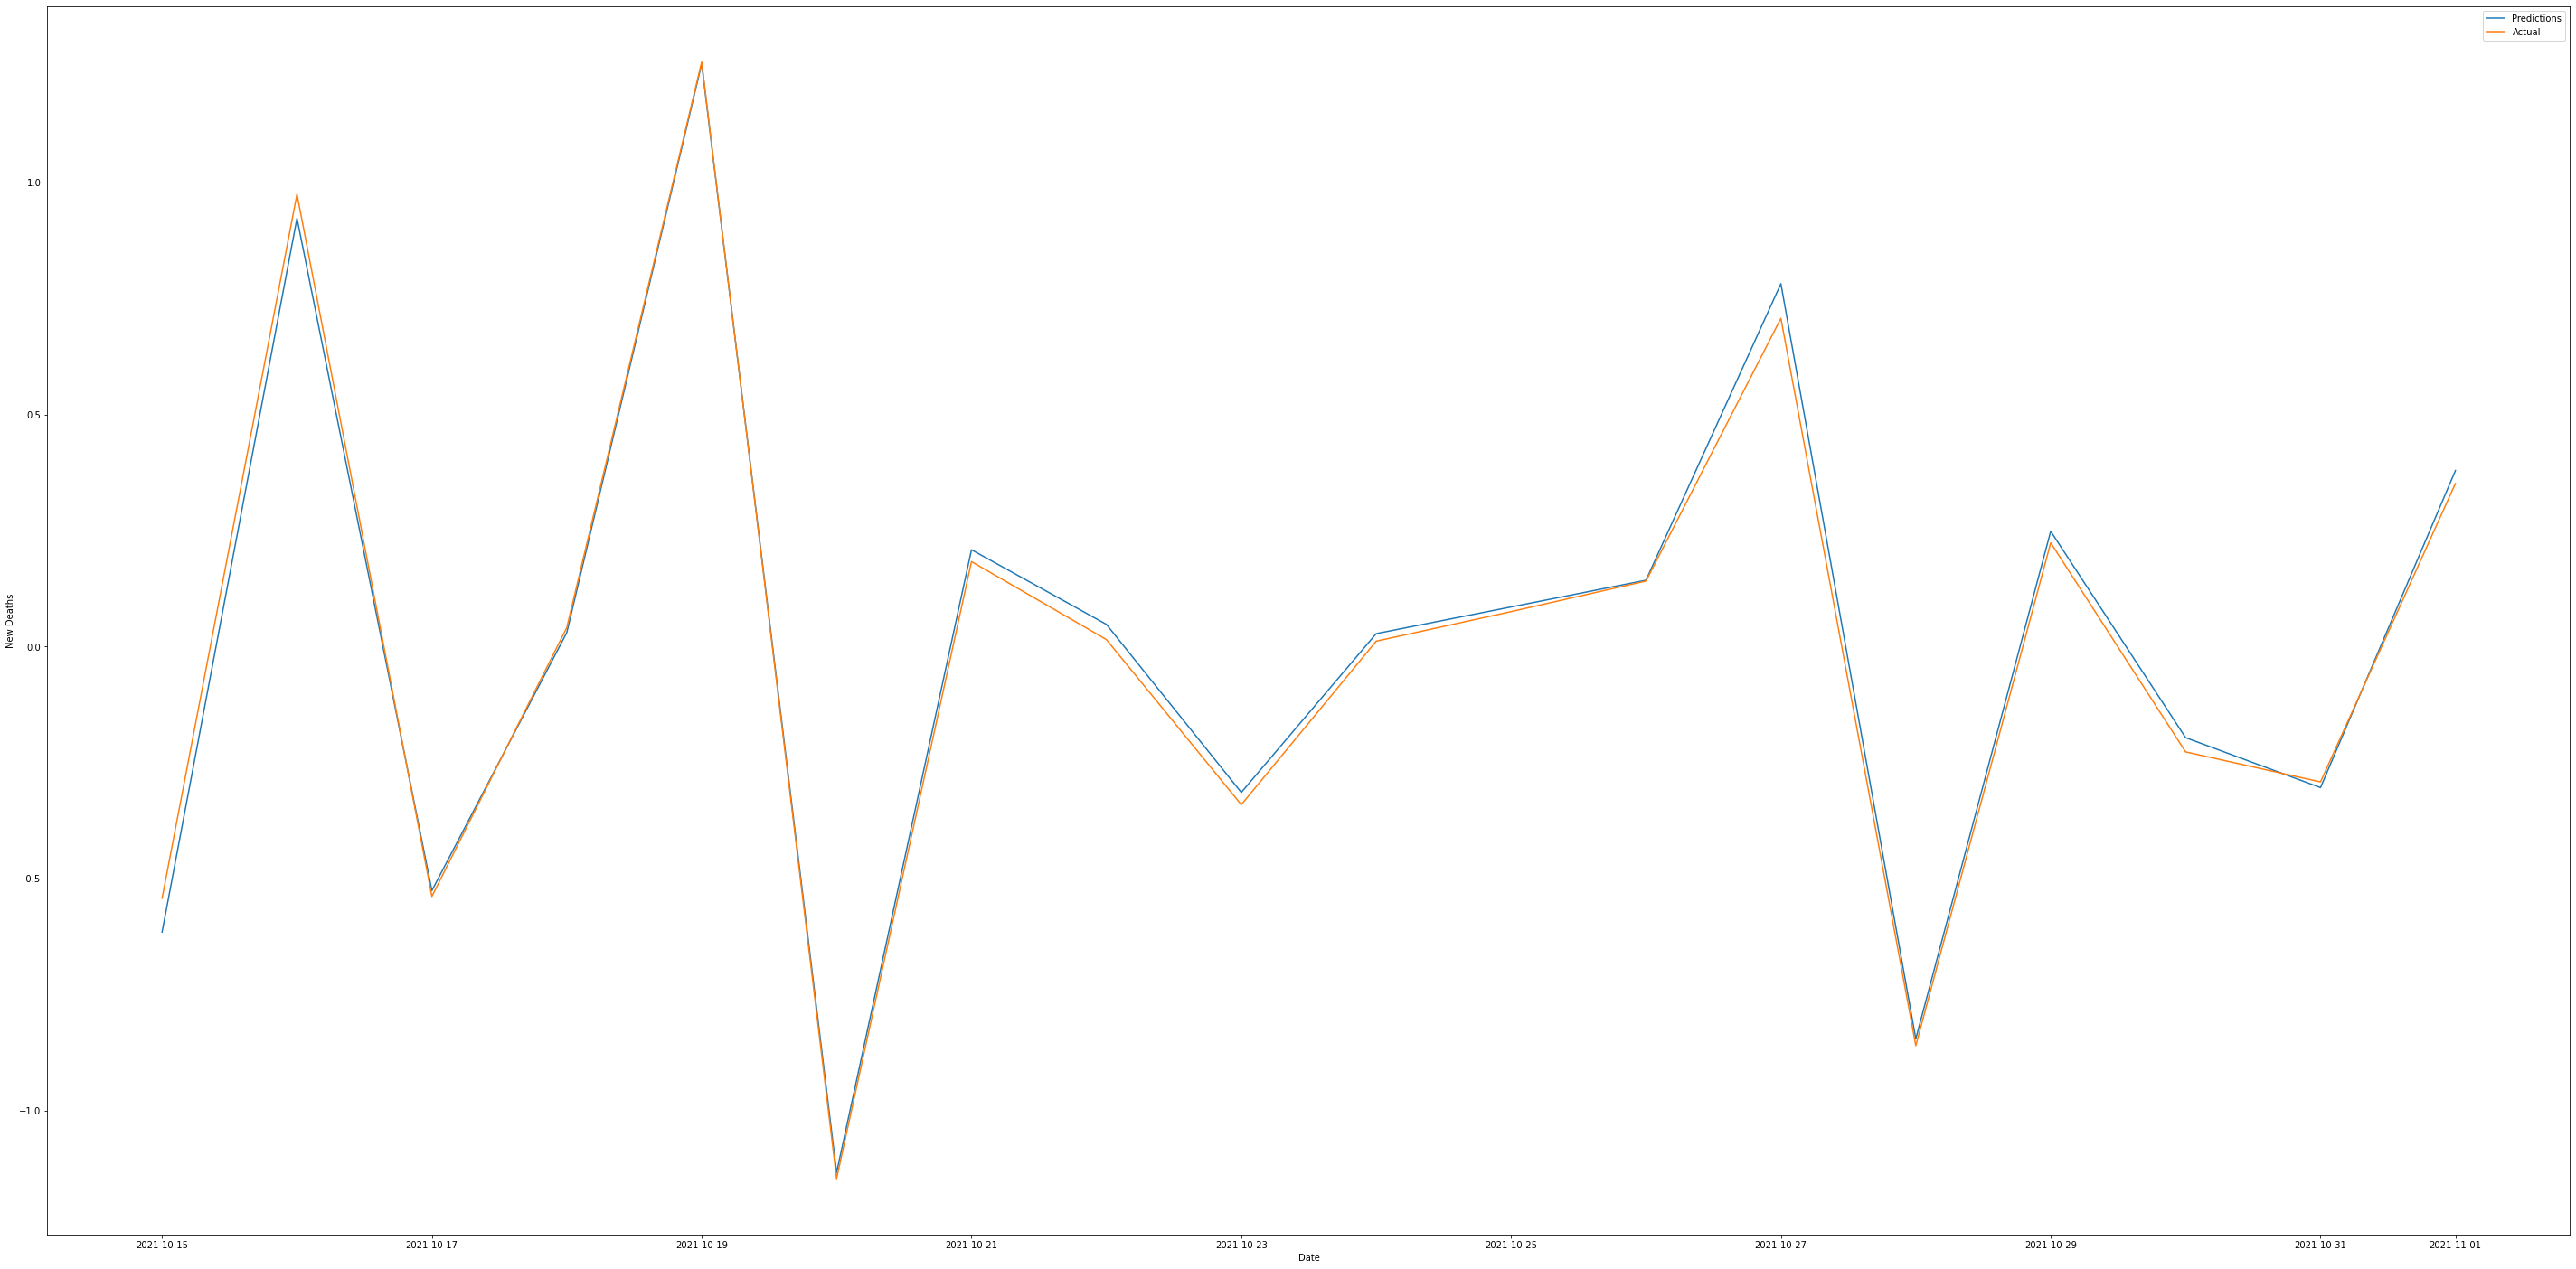

C: 1.0 - SVR Score: 0.9986698684274807


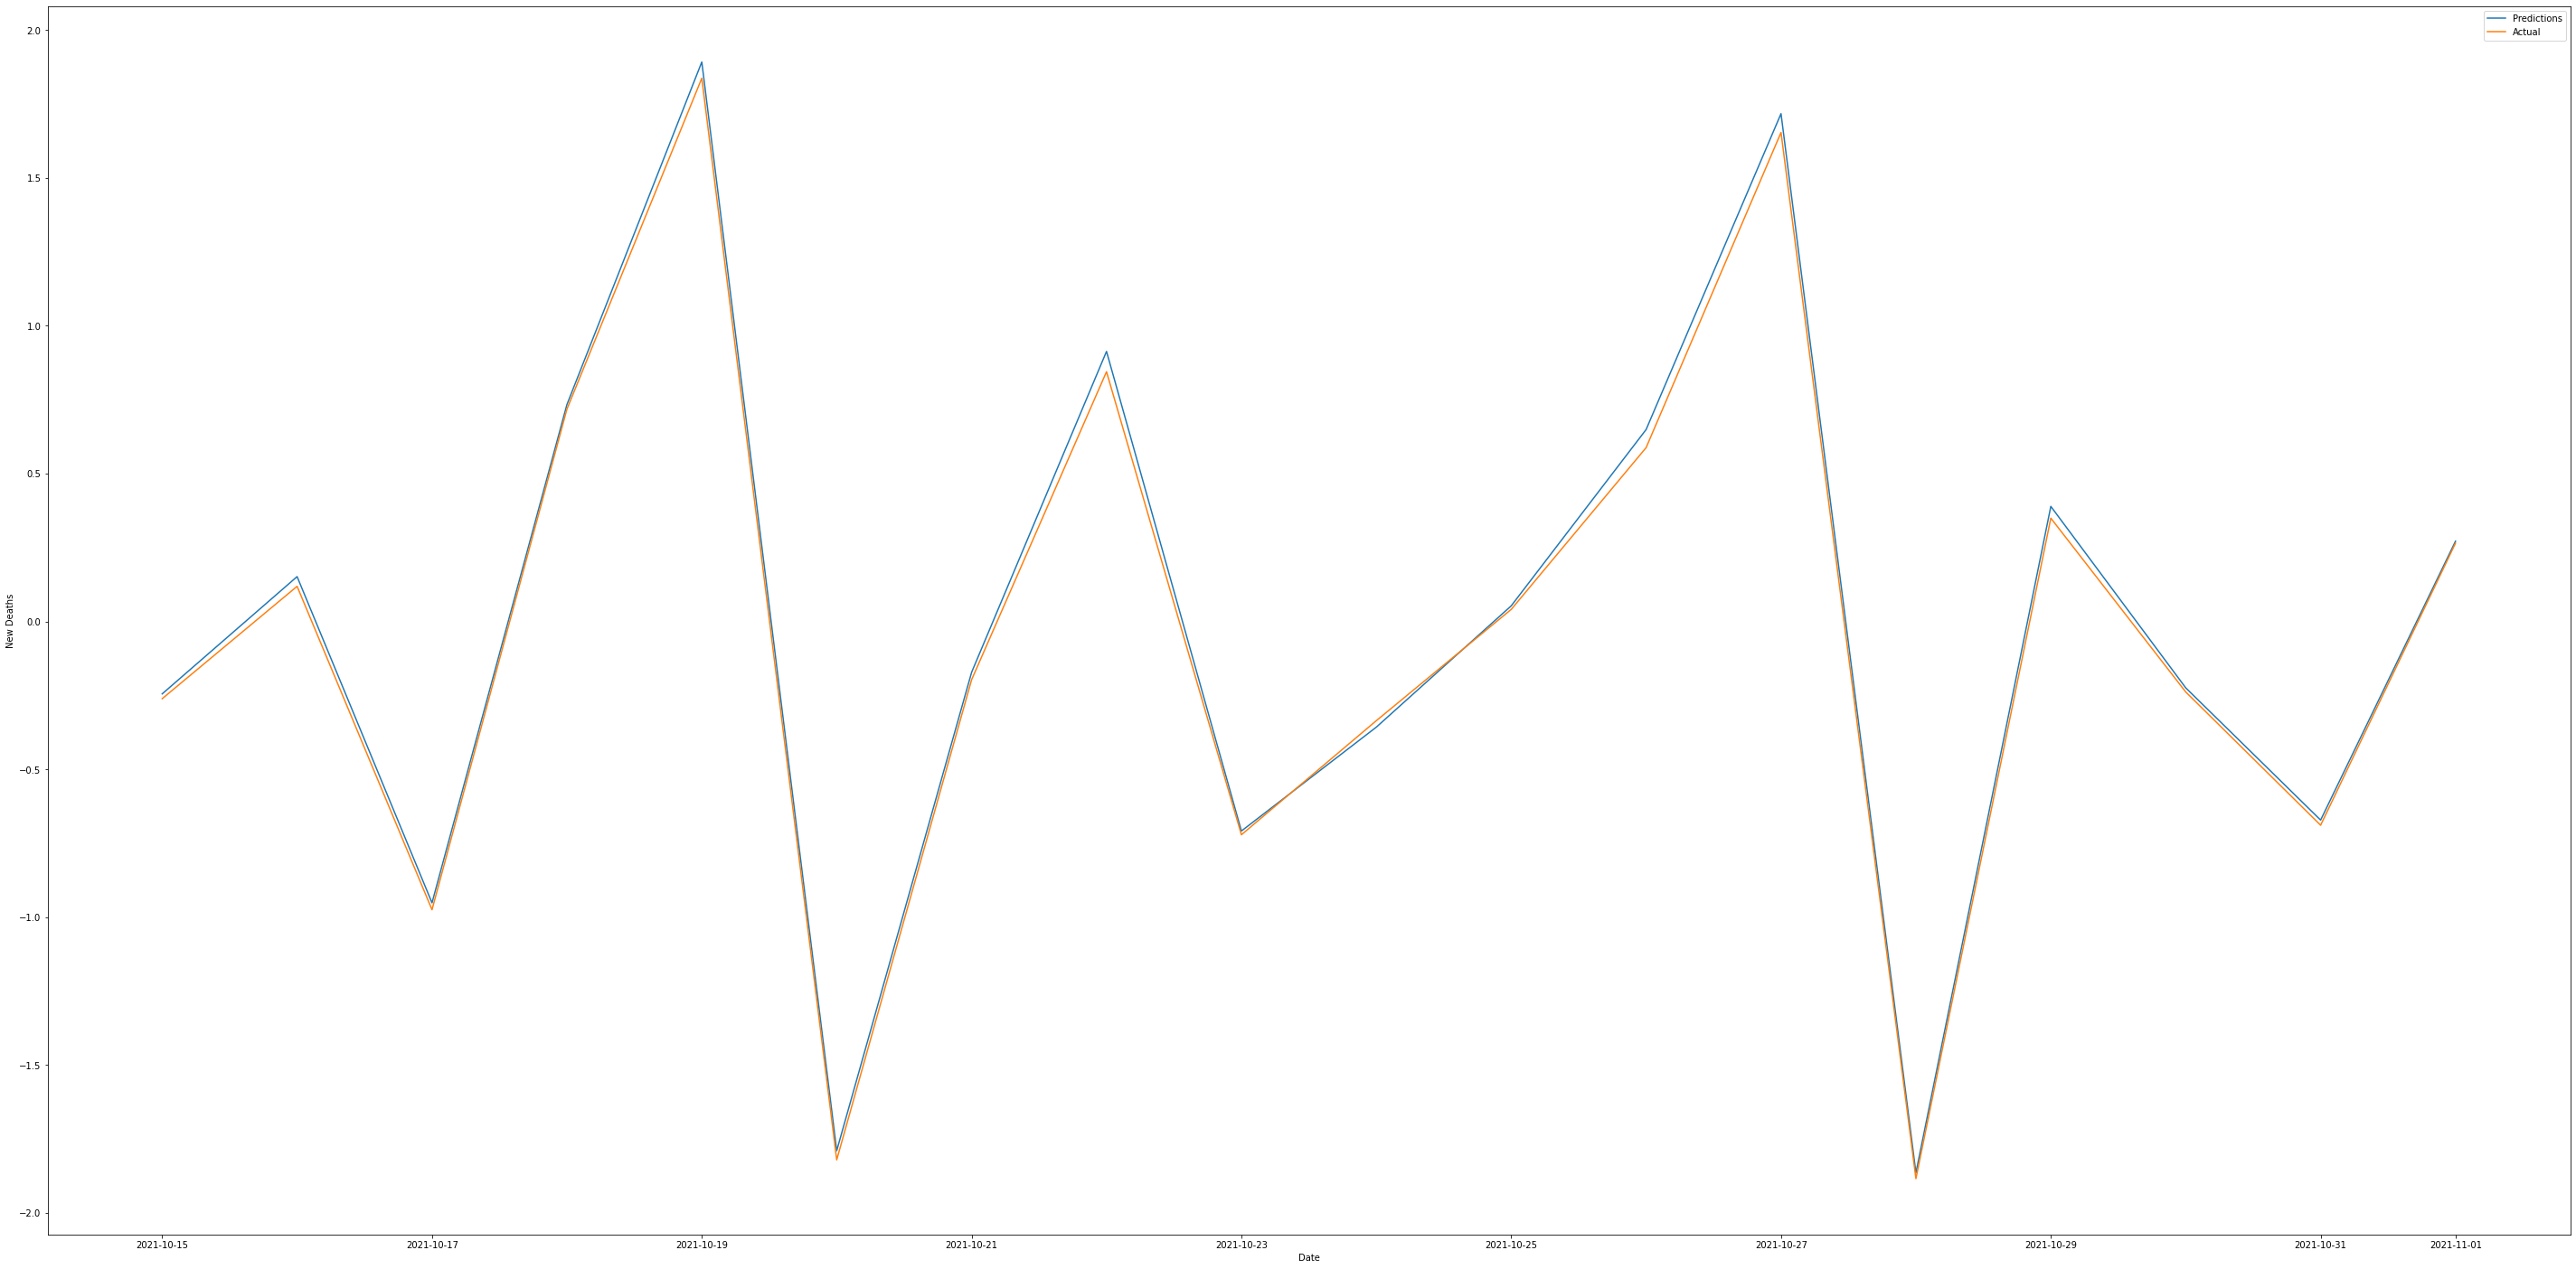

C: 1.0 - SVR Score: 0.9968973947752897


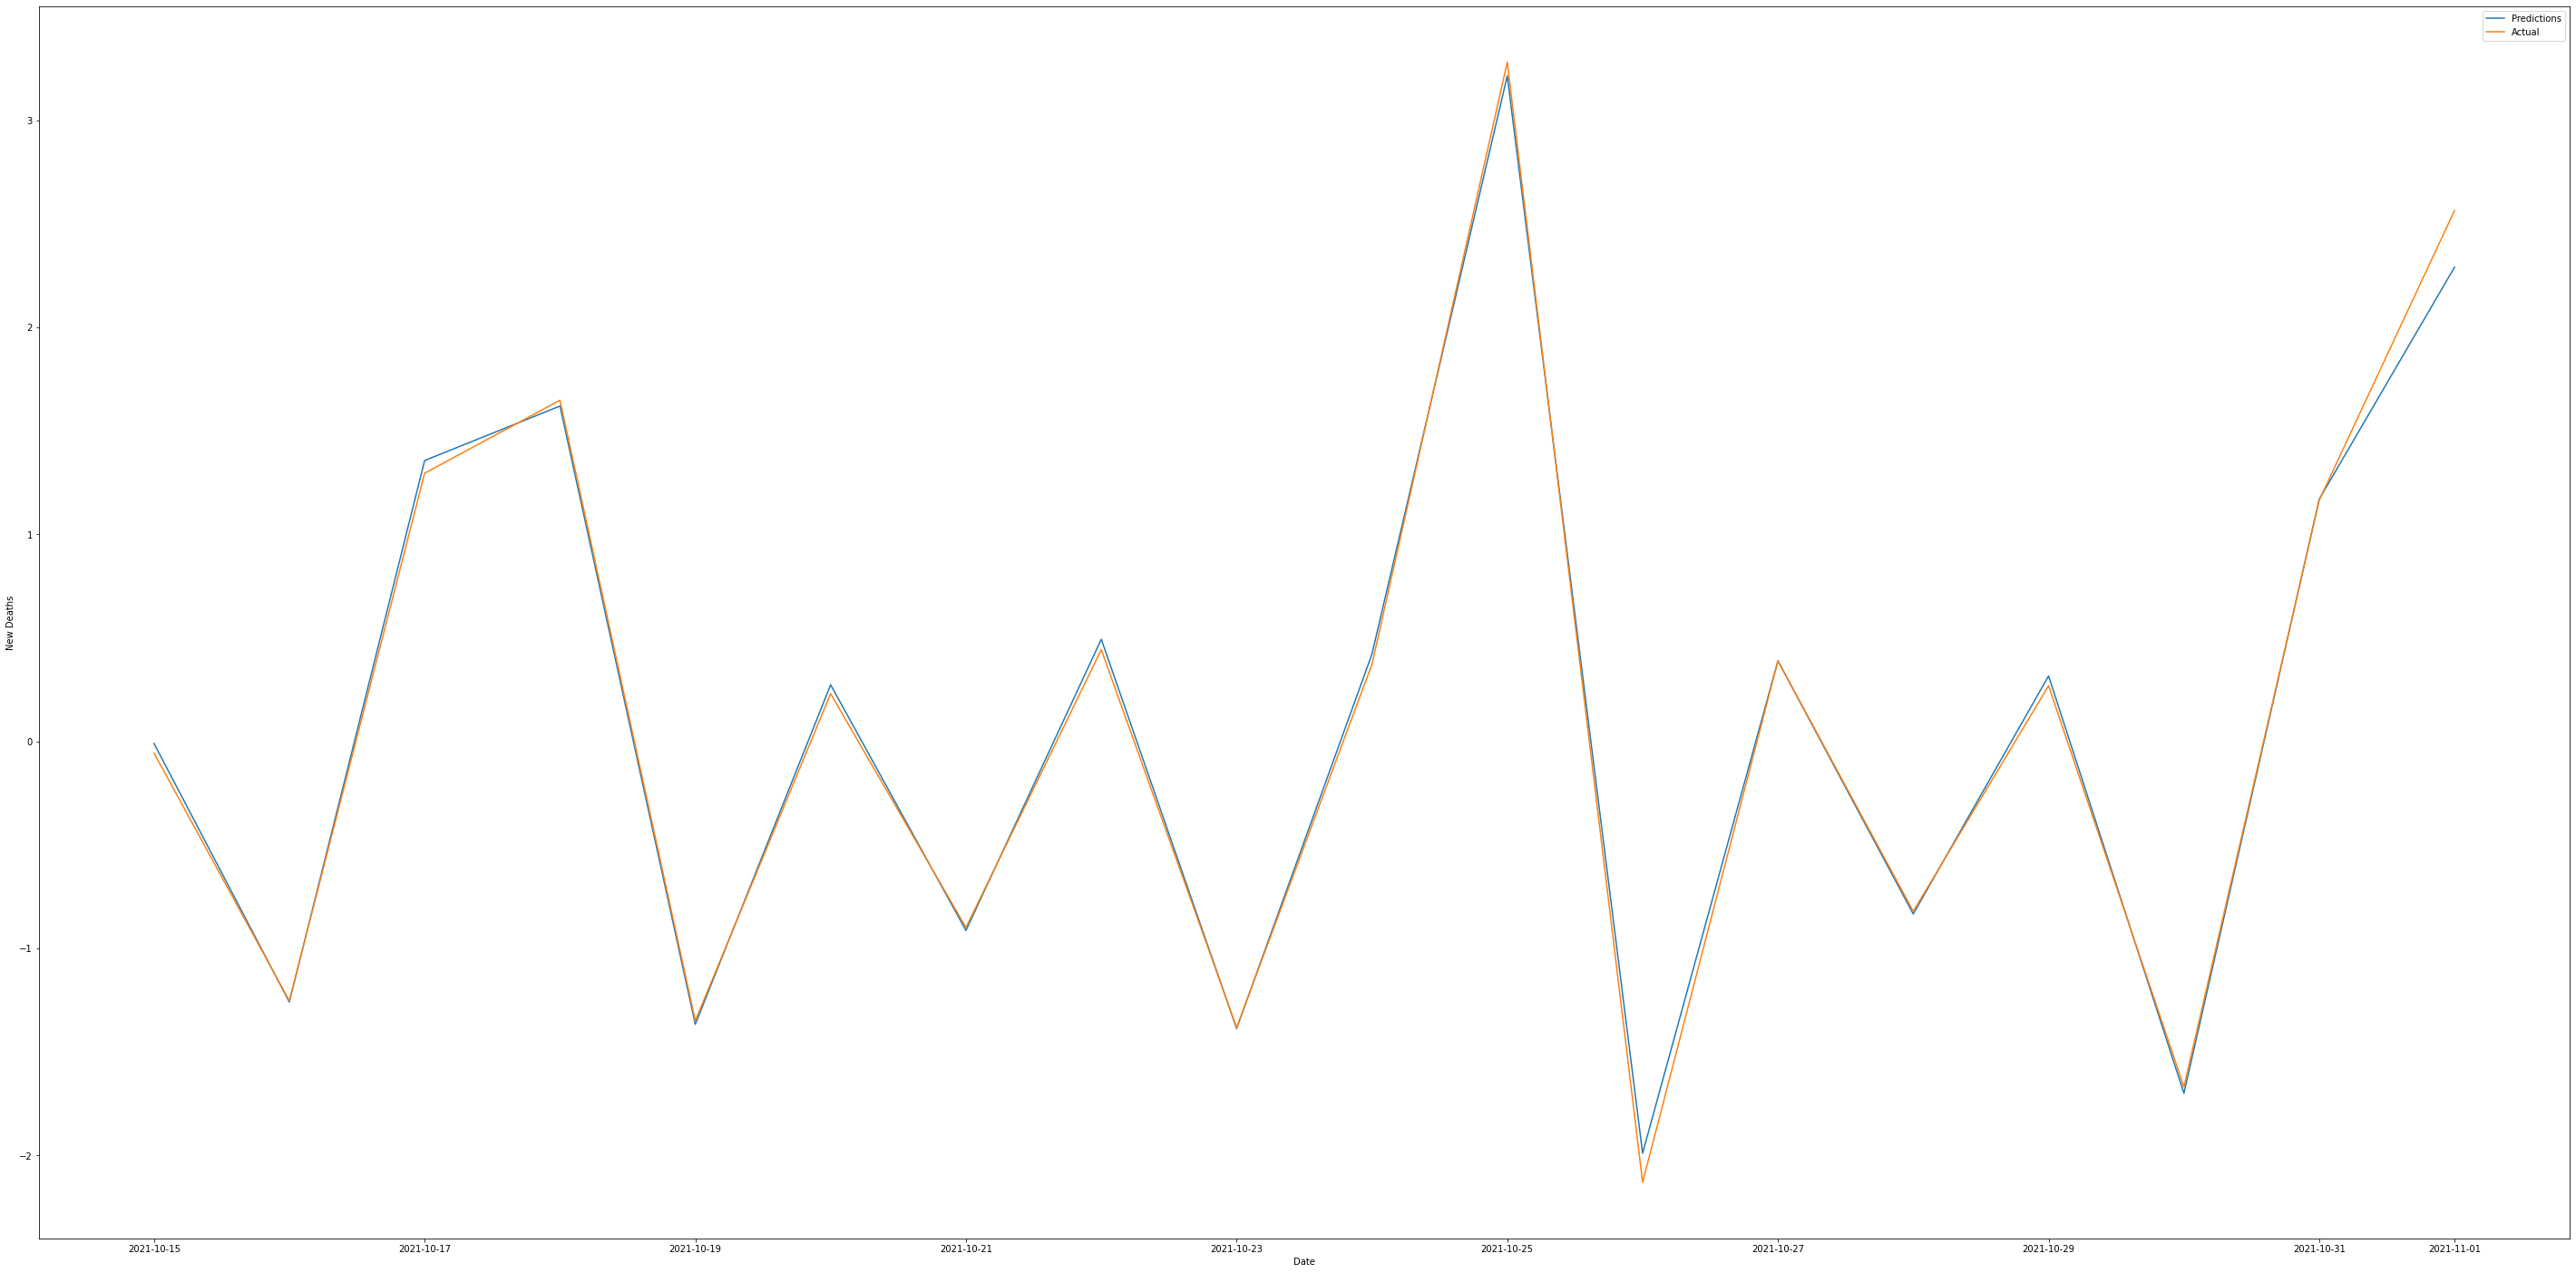

In [365]:
model = svr(svr_train_dataset)
# for each country
for country in countries:
    svr_predict(model, country, svr_test_dataset)

### Cross-Fold Validation 


In [366]:
# model = svr('United States', svr_train_dataset, svr_test_dataset)

In [367]:
# svr_predict(model, country, svr_train_dataset, svr_test_dataset)

In [368]:
# for each country
# for country in countries:
#     print("Country: {}".format(country))
#     svr_predict(model, country)
